<a href="https://colab.research.google.com/github/cralji/RFF-Nerve-UTP/blob/main/ResUNET_Brachial-Plexus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [ ]:
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, confusion_matrix, accuracy_score, classification_report, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LinearRegression,  SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import RFE, SelectKBest, chi2
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import StandardScaler
from xml.etree import cElementTree as ElementTree
from keras_preprocessing.image import ImageDataGenerator
from sklearn.externals.six import StringIO  
from sklearn.naive_bayes import GaussianNB
from pandas.plotting import scatter_matrix
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from IPython.display import Image  
import matplotlib.pyplot as plt
from sklearn import metrics 
from joblib import dump, load
import requests, zipfile, io
from sklearn import svm
import numpy as np
from numpy import mean, std
import seaborn as sns
import cv2
import scipy.io
import pandas as pd
import pydotplus
import os
from glob import glob
from PIL import Image
from math import sqrt
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import Input
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam,SGD
import skimage
from skimage import segmentation

try:
  !pip install scikit-image
except:
  None

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


# Functions 

In [ ]:
#%% functionfor extract the image's mask from xml extensión file. 
def fun2(pathxml,pathimg, img_path, label_path,img_path_nerve, label_path_nerve):
  tree = ElementTree.parse(pathxml)
  root = tree.getroot()
  xy=[]
  d={}
  i=0
  for element in root:
    if len(element)==0:
      d[str(element.tag)]=str(element.text)
    else: 
      d[str(element.tag)]={}
    for sub in element:
      if len(sub)==0:
        d[str(element.tag)][str(sub.tag)]=str(sub.text)
      else:
        d[str(element.tag)][str(sub.tag)]={}
      for sub2 in sub:
        if len(sub2)==0:
          d[str(element.tag)][str(sub.tag)][str(sub2.tag)]=str(sub2.text)
        else:
          if str(sub2.tag)=="pt":
            i+=1
            d[str(element.tag)][str(sub.tag)][str(sub2.tag)+str(i)]={"x":sub2[0].text,"y":sub2[1].text}
            xy.append((sub2[0].text,sub2[1].text))
  pts = np.asarray(xy,np.int32)
  img=plt.imread(pathimg)
  img_poly = plt.imread(pathimg)
  img_labels = np.zeros((img[:,:,0].shape),dtype=np.uint8)
  cv2.fillPoly(img_poly,[pts], (255,0,0));  
  indices=np.where(np.all(img_poly== (255,0,0),axis=-1)) 
  img_labels[indices[0],indices[1]] = 1#255#255#1
  
  cv2.imwrite(img_path, img)
  cv2.imwrite(label_path, img_labels)

  cv2.imwrite(img_path_nerve, img)
  cv2.imwrite(label_path_nerve, img_labels)

# Load Data

## Download Dataset

In [ ]:
FILEID = "1aWcmETxflatj1gtBGEvdw1PdIOw7YyJH"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O train.zip && rm -rf /tmp/cookies.txt


FILEID = "1mi69Hm_1L0ZfbtKaJbuzfymS3EubsKPy"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O test.zip && rm -rf /tmp/cookies.txt

--2021-07-07 13:15:45--  https://docs.google.com/uc?export=download&confirm=_4Ie&id=1aWcmETxflatj1gtBGEvdw1PdIOw7YyJH
Resolving docs.google.com (docs.google.com)... 74.125.20.113, 74.125.20.139, 74.125.20.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-6o-docs.googleusercontent.com/docs/securesc/nodn3ued1e1l2e8f1kehc7gfnq5bllkk/1h8ohl4ge3ah3u905k5qp3gisisc22jj/1625663700000/05137136237839183901/10708121289108624877Z/1aWcmETxflatj1gtBGEvdw1PdIOw7YyJH?e=download [following]
--2021-07-07 13:15:45--  https://doc-0o-6o-docs.googleusercontent.com/docs/securesc/nodn3ued1e1l2e8f1kehc7gfnq5bllkk/1h8ohl4ge3ah3u905k5qp3gisisc22jj/1625663700000/05137136237839183901/10708121289108624877Z/1aWcmETxflatj1gtBGEvdw1PdIOw7YyJH?e=download
Resolving doc-0o-6o-docs.googleusercontent.com (doc-0o-6o-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to 

In [ ]:
!mkdir train
!mkdir test
!unzip -q train.zip -d train
!unzip -q test.zip -d test

In [ ]:
files_path = glob('./train/*.tif')
files_path = [filepath_ for filepath_ in files_path if 'mask' not in filepath_]
files_mask = [files[:-4]+'_mask.tif' for files in files_path]

# files_path_test = glob('./test/*.tif')
# files_path_test = [filepath_ for filepath_ in files_path_test if 'mask' not in filepath_]
# files_mask_test = [files[:-4]+'_mask.tif' for files in files_path_test]

In [ ]:
void = [np.unique(cv2.imread(mask,cv2.IMREAD_GRAYSCALE)).size==2 for mask in files_mask]
print('All have nerve in train?: {}'.format(np.all(void)))

All have nerve in train?: False


In [ ]:
for_test_files,for_test_mask = [files for c,files in zip(void,files_path) if not(c)],[mask for c,mask in zip(void,files_mask) if not(c)]
files_path,files_mask = [files for c,files in zip(void,files_path) if c],[mask for c,mask in zip(void,files_mask) if c]

# df_train = pd.DataFrame({'filepath':files_path,'mask':files_mask})
# df_test_images = pd.DataFrame({'filepath':files_path_test + for_test_files,'mask':files_mask_test+for_test_mask})

### Split sets

In [ ]:
files_path,files_path_test,files_mask,files_mask_test = train_test_split(np.array(files_path),
                                                                         np.array(files_mask),
                                                                         test_size=0.2)
df_train = pd.DataFrame({'filepath':files_path.tolist(),'mask':files_mask.tolist()})
df_test_images = pd.DataFrame({'filepath':files_path_test.tolist(),
                               'mask':files_mask_test.tolist()})

In [ ]:
df_test_images

filepath                     mask
0     ./train/31_26.tif   ./train/31_26_mask.tif
1     ./train/20_65.tif   ./train/20_65_mask.tif
2      ./train/6_24.tif    ./train/6_24_mask.tif
3    ./train/29_117.tif  ./train/29_117_mask.tif
4    ./train/42_109.tif  ./train/42_109_mask.tif
..                  ...                      ...
460  ./train/31_118.tif  ./train/31_118_mask.tif
461   ./train/36_69.tif   ./train/36_69_mask.tif
462     ./train/8_9.tif     ./train/8_9_mask.tif
463   ./train/5_112.tif   ./train/5_112_mask.tif
464   ./train/41_33.tif   ./train/41_33_mask.tif

[465 rows x 2 columns]

In [ ]:
df_train_images,df_val_images = train_test_split(df_train, test_size=0.2)
# df_train_images,df_val_images = train_test_split(df_train_images, test_size=0.2)

In [ ]:
def preprocessing_mask(mask):
  mask[mask > 0.5] = 255
  mask[mask <= 0.5] = 0
  return mask

In [ ]:
seed = 1993
batch_size = 32
height,width = 128,128
image_datagen = ImageDataGenerator(rotation_range=10,
                                   horizontal_flip =True,
                                   vertical_flip=True,
                                   rescale=1./255)

image_datagen_mask = ImageDataGenerator(rotation_range=10,
                                   horizontal_flip =True,
                                   vertical_flip=True,
                                   rescale=1./255,
                                   preprocessing_function = preprocessing_mask)

generator_train_img = image_datagen.flow_from_dataframe(df_train_images,
                                                        x_col = 'filepath',
                                                        batch_size = batch_size,
                                                        class_mode = None,
                                                        directory = None,
                                                        target_size = (height,width),
                                                        seed = seed)

generator_train_mask = image_datagen_mask.flow_from_dataframe(df_train_images,
                                                         x_col='mask',
                                                         class_mode = None,
                                                         directory = None,
                                                         color_mode="grayscale", 
                                                         batch_size = batch_size,
                                                         target_size = (height,width),
                                                         seed = seed)

train_gen = zip(generator_train_img,generator_train_mask)


generator_val_img = image_datagen.flow_from_dataframe(df_val_images,
                                                        x_col='filepath',
                                                        class_mode = None,
                                                        directory = None,
                                                        target_size = (height,width),
                                                        batch_size = batch_size,
                                                        seed = seed)

generator_val_mask = image_datagen_mask.flow_from_dataframe(df_val_images,
                                                         x_col='mask',
                                                         class_mode = None,
                                                         directory = None,
                                                         color_mode="grayscale",
                                                         target_size = (height,width),
                                                         batch_size = batch_size,
                                                         seed = seed)

val_gen = zip(generator_val_img,generator_val_mask)


generator_test_img = image_datagen.flow_from_dataframe(df_test_images,
                                                        x_col='filepath',
                                                        class_mode = None,
                                                        directory = None,
                                                        target_size = (height,width),
                                                        batch_size = batch_size,
                                                        seed = seed)

generator_test_mask = image_datagen_mask.flow_from_dataframe(df_test_images,
                                                         x_col='mask',
                                                         class_mode = None,
                                                         directory = None,
                                                         color_mode="grayscale",
                                                         target_size = (height,width),
                                                         batch_size = batch_size,
                                                         seed = seed)

test_gen = zip(generator_test_img,generator_test_mask)


Found 1486 validated image filenames.
Found 1486 validated image filenames.
Found 372 validated image filenames.
Found 372 validated image filenames.
Found 465 validated image filenames.
Found 465 validated image filenames.


Shape_in: (32, 128, 128, 3)


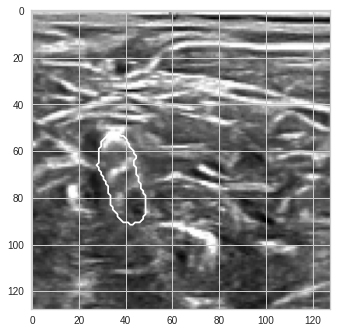

array([0., 1.], dtype=float32)

In [ ]:
i,j = next(test_gen)
print('Shape_in: {}'.format(i.shape))
plt.imshow(i[0,:,:,:])
edges_est = segmentation.clear_border(j[0,:,:,0])
plt.contour(edges_est,[0.5])
plt.show()
np.unique(j[0,:,:,0])

# Build Model 

## need functions

In [ ]:
def dice_coef(y_true, y_pred, smooth = 1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def renny_entropy(ytrue,ypred):
    Ke = tf.matmul(ypred,ypred,transpose_b=True)
    Ke = Ke/tf.linalg.trace(Ke)
    #entropy_renny  = (1/(1-2))*tf.math.log((1/tf.constant(32*32,dtype=ypred.dtype))*tf.linalg.trace(tf.matmul(Ke,Ke,transpose_a=True)))
    entropy_renny = tf.constant(1/(1-2))*tf.linalg.trace(tf.matmul(Ke,Ke,transpose_a=True))
    return entropy_renny


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred, smooth = 1.):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true) + K.sum(y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def sensitivity(y_true, y_pred):
    s = K.sum(y_true, axis=(1,2,3))
    y_true_c = s / (s + K.epsilon())
    s_ = K.sum(y_pred, axis=(1,2,3))
    y_pred_c = s_ / (s_ + K.epsilon())
   
    true_positives = K.sum(K.round(K.clip(y_true_c * y_pred_c, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true_c, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    s = K.sum(y_true, axis=(1,2,3))
    y_true_c = s / (s + K.epsilon())
    s_ = K.sum(y_pred, axis=(1,2,3))
    y_pred_c = s_ / (s_ + K.epsilon())
    
    true_negatives = K.sum(K.round(K.clip((1-y_true_c) * (1-y_pred_c), 0, 1)))#123456789
# path = "./ImagenesNervios/data/"data_image = [] data_mask = glob(path + '*_mask*') for i in data_mask:  data_image.append(i.replace('_mask', '')) print("Cantidad total de datos:",len(data_image))

    possible_negatives = K.sum(K.round(K.clip(1-y_true_c, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
UPSAMPLE_MODE = 'DECONV' # SIMPLE'
NET_SCALING = None
GAUSSIAN_NOISE = 0.1
EDGE_CROP = 16
ACTIVATION = 'relu'
from tensorflow.keras import models, layers
from tensorflow.keras.layers.experimental import RandomFourierFeatures
# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

def res_block(x,units):
  x_c = x
  x = layers.Conv2D(units,(1,1),(1,1),padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation(ACTIVATION)(x)
  x = layers.Conv2D(units,(3,3),(1,1),padding='same')(x)
  x = layers.BatchNormalization()(x)
  
  x_c = layers.Conv2D(units,(1,1),(1,1),padding='same')(x_c)
  x_c = layers.BatchNormalization()(x_c)
  x = layers.Add()([x,x_c])
  x = layers.Activation(ACTIVATION)(x)

  return x

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple

def create_model(phi_units = 128):
  input_img = layers.Input((width,height,3), name = 'RGB_Input')
  pp_in_layer = input_img
  if NET_SCALING is not None:
      pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
      
  pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
  pp_in_layer = layers.BatchNormalization()(pp_in_layer)

  c1 = res_block(pp_in_layer,8)
  c1 = res_block(c1,8)
  p1 = layers.MaxPooling2D((2, 2)) (c1)

  c2 = res_block(p1,16)
  c2 = res_block(c2,16)
  p2 = layers.MaxPooling2D((2, 2)) (c2)

  c3 = res_block(p2,32)
  c3 = res_block(c3,32)
  p3 = layers.MaxPooling2D((2, 2)) (c3)

  c4 = res_block(p3,64)
  c4 = res_block(c4,64)
  p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)
  # Bottle Neck
  c5 = res_block(p4,128)
  c5 = res_block(c5,128)
  # upsampling
  u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = layers.concatenate([u6, c4])
  c6 = res_block(u6,64)
  c6 = res_block(c6,64)

  u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = layers.concatenate([u7, c3])
  c7 = res_block(u7,32)
  c7 = res_block(c7,32)

  u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = layers.concatenate([u8, c2])
  c8 = res_block(u8,16)
  c8 = res_block(c8,16)

  u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = layers.concatenate([u9, c1], axis=3)
  c9 = res_block(u9,8)
  c9 = res_block(c9,8)

  d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
  d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
  d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP),name='output')(d)
  if NET_SCALING is not None:
      d = layers.UpSampling2D(NET_SCALING)(d)

  seg_model = models.Model(inputs=[input_img], outputs=[d])
  
  return seg_model

seg_model = create_model(65)

seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 128, 128, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 3)  12          gaussian_noise[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 8)  32          batch_normalization[0][0]        
______________________________________________________________________________________________

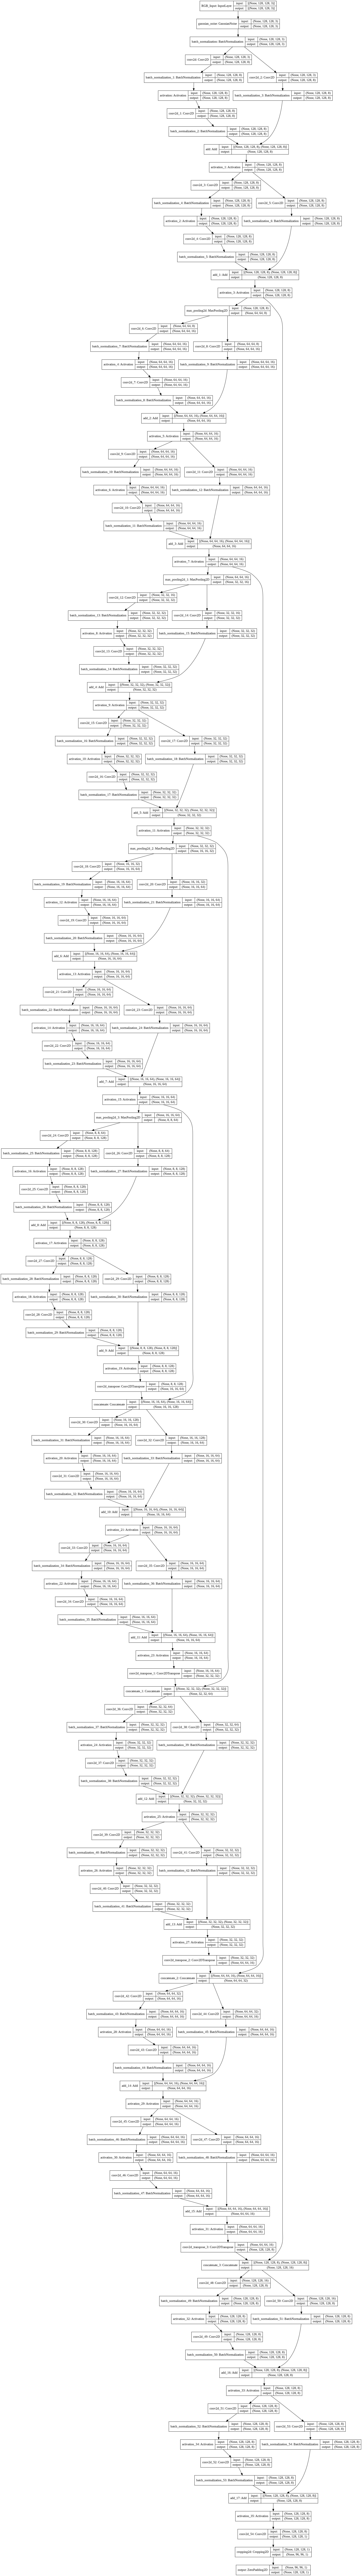

In [ ]:
tf.keras.utils.plot_model(seg_model,show_shapes=True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
46/46 [==============================] - 41s 442ms/step - loss: -0.1068 - iou: 0.0564 - dice_coef: 0.1068 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.5634 - val_loss: -0.1057 - val_iou: 0.0558 - val_dice_coef: 0.1057 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.4699


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 2/200
46/46 [==============================] - 19s 424ms/step - loss: -0.1106 - iou: 0.0585 - dice_coef: 0.1105 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.5636 - val_loss: -0.1071 - val_iou: 0.0566 - val_dice_coef: 0.1071 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.4700


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 3/200
46/46 [==============================] - 19s 431ms/step - loss: -0.1153 - iou: 0.0612 - dice_coef: 0.1153 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.5748 - val_loss: -0.1084 - val_iou: 0.0573 - val_dice_coef: 0.1084 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.4709


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 4/200
46/46 [==============================] - 19s 421ms/step - loss: -0.1206 - iou: 0.0642 - dice_coef: 0.1206 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.5958 - val_loss: -0.1106 - val_iou: 0.0586 - val_dice_coef: 0.1106 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.4772


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 5/200
46/46 [==============================] - 19s 421ms/step - loss: -0.1267 - iou: 0.0677 - dice_coef: 0.1268 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.6247 - val_loss: -0.1133 - val_iou: 0.0601 - val_dice_coef: 0.1133 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.4757


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 6/200
46/46 [==============================] - 19s 419ms/step - loss: -0.1389 - iou: 0.0746 - dice_coef: 0.1388 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.6616 - val_loss: -0.1104 - val_iou: 0.0585 - val_dice_coef: 0.1104 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.4701


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 7/200
46/46 [==============================] - 19s 422ms/step - loss: -0.1723 - iou: 0.0942 - dice_coef: 0.1720 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.7153 - val_loss: -0.1097 - val_iou: 0.0580 - val_dice_coef: 0.1097 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.4699


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 8/200
46/46 [==============================] - 19s 419ms/step - loss: -0.2065 - iou: 0.1151 - dice_coef: 0.2062 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.7910 - val_loss: -0.1098 - val_iou: 0.0581 - val_dice_coef: 0.1098 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.4699


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 9/200
46/46 [==============================] - 19s 421ms/step - loss: -0.2759 - iou: 0.1605 - dice_coef: 0.2758 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9057 - val_loss: -0.1117 - val_iou: 0.0592 - val_dice_coef: 0.1117 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.4776


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 10/200
46/46 [==============================] - 19s 424ms/step - loss: -0.3567 - iou: 0.2172 - dice_coef: 0.3563 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9516 - val_loss: -0.2059 - val_iou: 0.1153 - val_dice_coef: 0.2059 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9237


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 11/200
46/46 [==============================] - 19s 422ms/step - loss: -0.3980 - iou: 0.2494 - dice_coef: 0.3983 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9590 - val_loss: -0.1114 - val_iou: 0.0591 - val_dice_coef: 0.1114 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9667


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 12/200
46/46 [==============================] - 19s 422ms/step - loss: -0.4232 - iou: 0.2684 - dice_coef: 0.4227 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9632 - val_loss: -0.0481 - val_iou: 0.0247 - val_dice_coef: 0.0481 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 13/200
46/46 [==============================] - 19s 423ms/step - loss: -0.4438 - iou: 0.2865 - dice_coef: 0.4444 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9658 - val_loss: -0.0493 - val_iou: 0.0253 - val_dice_coef: 0.0493 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9671


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 14/200
46/46 [==============================] - 19s 420ms/step - loss: -0.4590 - iou: 0.2984 - dice_coef: 0.4587 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9672 - val_loss: -0.1215 - val_iou: 0.0648 - val_dice_coef: 0.1215 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9683


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 15/200
46/46 [==============================] - 19s 418ms/step - loss: -0.4804 - iou: 0.3168 - dice_coef: 0.4801 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9704 - val_loss: -0.0588 - val_iou: 0.0303 - val_dice_coef: 0.0588 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9671


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 16/200
46/46 [==============================] - 19s 422ms/step - loss: -0.4938 - iou: 0.3296 - dice_coef: 0.4943 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9710 - val_loss: -0.0968 - val_iou: 0.0509 - val_dice_coef: 0.0968 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9678


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 17/200
46/46 [==============================] - 19s 423ms/step - loss: -0.5013 - iou: 0.3357 - dice_coef: 0.5012 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9715 - val_loss: -0.1041 - val_iou: 0.0552 - val_dice_coef: 0.1041 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9683


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 18/200
46/46 [==============================] - 19s 424ms/step - loss: -0.5200 - iou: 0.3527 - dice_coef: 0.5201 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9738 - val_loss: -0.0986 - val_iou: 0.0520 - val_dice_coef: 0.0986 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9682


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 19/200
46/46 [==============================] - 19s 421ms/step - loss: -0.5318 - iou: 0.3641 - dice_coef: 0.5321 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9738 - val_loss: -0.0546 - val_iou: 0.0281 - val_dice_coef: 0.0546 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 20/200
46/46 [==============================] - 19s 423ms/step - loss: -0.5398 - iou: 0.3706 - dice_coef: 0.5391 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9748 - val_loss: -0.0714 - val_iou: 0.0371 - val_dice_coef: 0.0714 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9674


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 21/200
46/46 [==============================] - 19s 424ms/step - loss: -0.5502 - iou: 0.3809 - dice_coef: 0.5498 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9756 - val_loss: -0.1423 - val_iou: 0.0768 - val_dice_coef: 0.1423 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9692


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 22/200
46/46 [==============================] - 19s 420ms/step - loss: -0.5654 - iou: 0.3950 - dice_coef: 0.5650 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9766 - val_loss: -0.0706 - val_iou: 0.0367 - val_dice_coef: 0.0706 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9674


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 23/200
46/46 [==============================] - 19s 424ms/step - loss: -0.5706 - iou: 0.4013 - dice_coef: 0.5710 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9764 - val_loss: -0.1015 - val_iou: 0.0536 - val_dice_coef: 0.1015 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9681


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 24/200
46/46 [==============================] - 19s 423ms/step - loss: -0.5824 - iou: 0.4110 - dice_coef: 0.5813 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9784 - val_loss: -0.2675 - val_iou: 0.1556 - val_dice_coef: 0.2675 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9714


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 25/200
46/46 [==============================] - 19s 418ms/step - loss: -0.5887 - iou: 0.4196 - dice_coef: 0.5894 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9782 - val_loss: -0.1609 - val_iou: 0.0883 - val_dice_coef: 0.1609 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9693


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 26/200
46/46 [==============================] - 19s 424ms/step - loss: -0.5984 - iou: 0.4288 - dice_coef: 0.5978 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9784 - val_loss: -0.2911 - val_iou: 0.1725 - val_dice_coef: 0.2911 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9720


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 27/200
46/46 [==============================] - 19s 424ms/step - loss: -0.6094 - iou: 0.4412 - dice_coef: 0.6099 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9796 - val_loss: -0.1469 - val_iou: 0.0803 - val_dice_coef: 0.1469 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9692


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 28/200
46/46 [==============================] - 19s 419ms/step - loss: -0.6135 - iou: 0.4442 - dice_coef: 0.6133 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9795 - val_loss: -0.2864 - val_iou: 0.1686 - val_dice_coef: 0.2864 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9722


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 29/200
46/46 [==============================] - 19s 420ms/step - loss: -0.6201 - iou: 0.4518 - dice_coef: 0.6204 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9799 - val_loss: -0.1431 - val_iou: 0.0776 - val_dice_coef: 0.1431 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9688


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 30/200
46/46 [==============================] - 19s 423ms/step - loss: -0.6267 - iou: 0.4584 - dice_coef: 0.6262 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9803 - val_loss: -0.2002 - val_iou: 0.1127 - val_dice_coef: 0.2002 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9704


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 31/200
46/46 [==============================] - 19s 424ms/step - loss: -0.6344 - iou: 0.4656 - dice_coef: 0.6339 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9803 - val_loss: -0.3349 - val_iou: 0.2025 - val_dice_coef: 0.3349 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9734


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 32/200
46/46 [==============================] - 19s 421ms/step - loss: -0.6430 - iou: 0.4765 - dice_coef: 0.6436 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9810 - val_loss: -0.3407 - val_iou: 0.2066 - val_dice_coef: 0.3407 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9737


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 33/200
46/46 [==============================] - 19s 425ms/step - loss: -0.6460 - iou: 0.4791 - dice_coef: 0.6459 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9809 - val_loss: -0.3016 - val_iou: 0.1797 - val_dice_coef: 0.3016 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9728


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 34/200
46/46 [==============================] - 19s 422ms/step - loss: -0.6535 - iou: 0.4873 - dice_coef: 0.6536 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9814 - val_loss: -0.4150 - val_iou: 0.2654 - val_dice_coef: 0.4150 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9745


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 35/200
46/46 [==============================] - 19s 422ms/step - loss: -0.6574 - iou: 0.4916 - dice_coef: 0.6571 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9817 - val_loss: -0.4040 - val_iou: 0.2557 - val_dice_coef: 0.4040 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9746


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 36/200
46/46 [==============================] - 19s 418ms/step - loss: -0.6648 - iou: 0.5007 - dice_coef: 0.6640 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9820 - val_loss: -0.3887 - val_iou: 0.2443 - val_dice_coef: 0.3887 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9740


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 37/200
46/46 [==============================] - 19s 422ms/step - loss: -0.6689 - iou: 0.5062 - dice_coef: 0.6692 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9821 - val_loss: -0.4133 - val_iou: 0.2643 - val_dice_coef: 0.4133 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9749


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 38/200
46/46 [==============================] - 19s 421ms/step - loss: -0.6755 - iou: 0.5135 - dice_coef: 0.6761 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9825 - val_loss: -0.4073 - val_iou: 0.2595 - val_dice_coef: 0.4073 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9740


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 39/200
46/46 [==============================] - 19s 420ms/step - loss: -0.6813 - iou: 0.5197 - dice_coef: 0.6817 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9828 - val_loss: -0.5178 - val_iou: 0.3546 - val_dice_coef: 0.5178 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9769


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 40/200
46/46 [==============================] - 19s 423ms/step - loss: -0.6827 - iou: 0.5202 - dice_coef: 0.6826 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9827 - val_loss: -0.5160 - val_iou: 0.3540 - val_dice_coef: 0.5160 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9772


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 41/200
46/46 [==============================] - 19s 421ms/step - loss: -0.6877 - iou: 0.5271 - dice_coef: 0.6874 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9830 - val_loss: -0.5418 - val_iou: 0.3787 - val_dice_coef: 0.5418 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9766


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 42/200
46/46 [==============================] - 19s 419ms/step - loss: -0.6926 - iou: 0.5324 - dice_coef: 0.6925 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9831 - val_loss: -0.5541 - val_iou: 0.3872 - val_dice_coef: 0.5541 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9780


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 43/200
46/46 [==============================] - 19s 420ms/step - loss: -0.6942 - iou: 0.5357 - dice_coef: 0.6948 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9830 - val_loss: -0.4872 - val_iou: 0.3281 - val_dice_coef: 0.4872 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9753


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 44/200
46/46 [==============================] - 19s 424ms/step - loss: -0.6984 - iou: 0.5403 - dice_coef: 0.6983 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9833 - val_loss: -0.5560 - val_iou: 0.3915 - val_dice_coef: 0.5560 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9776


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 45/200
46/46 [==============================] - 19s 419ms/step - loss: -0.7048 - iou: 0.5470 - dice_coef: 0.7048 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -0.5887 - val_iou: 0.4312 - val_dice_coef: 0.5887 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9779


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 46/200
46/46 [==============================] - 19s 422ms/step - loss: -0.7069 - iou: 0.5503 - dice_coef: 0.7070 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9836 - val_loss: -0.5944 - val_iou: 0.4308 - val_dice_coef: 0.5944 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 47/200
46/46 [==============================] - 19s 424ms/step - loss: -0.7078 - iou: 0.5525 - dice_coef: 0.7082 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9838 - val_loss: -0.5456 - val_iou: 0.3831 - val_dice_coef: 0.5456 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9784


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 48/200
46/46 [==============================] - 19s 424ms/step - loss: -0.7141 - iou: 0.5582 - dice_coef: 0.7141 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -0.5901 - val_iou: 0.4269 - val_dice_coef: 0.5901 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 49/200
46/46 [==============================] - 19s 425ms/step - loss: -0.7227 - iou: 0.5623 - dice_coef: 0.7161 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -0.6222 - val_iou: 0.4581 - val_dice_coef: 0.6222 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 50/200
46/46 [==============================] - 19s 422ms/step - loss: -0.7250 - iou: 0.5726 - dice_coef: 0.7250 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -0.5938 - val_iou: 0.4281 - val_dice_coef: 0.5938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 51/200
46/46 [==============================] - 19s 423ms/step - loss: -0.7238 - iou: 0.5695 - dice_coef: 0.7233 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -0.5690 - val_iou: 0.4049 - val_dice_coef: 0.5690 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9783


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 52/200
46/46 [==============================] - 19s 422ms/step - loss: -0.7253 - iou: 0.5726 - dice_coef: 0.7248 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -0.6164 - val_iou: 0.4550 - val_dice_coef: 0.6164 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 53/200
46/46 [==============================] - 19s 422ms/step - loss: -0.7307 - iou: 0.5804 - dice_coef: 0.7313 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -0.6230 - val_iou: 0.4572 - val_dice_coef: 0.6230 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 54/200
46/46 [==============================] - 19s 423ms/step - loss: -0.7342 - iou: 0.5851 - dice_coef: 0.7349 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.6306 - val_iou: 0.4708 - val_dice_coef: 0.6306 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9793


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 55/200
46/46 [==============================] - 19s 423ms/step - loss: -0.7384 - iou: 0.5884 - dice_coef: 0.7382 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.6225 - val_iou: 0.4629 - val_dice_coef: 0.6225 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 56/200
46/46 [==============================] - 19s 422ms/step - loss: -0.7378 - iou: 0.5886 - dice_coef: 0.7382 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.6304 - val_iou: 0.4699 - val_dice_coef: 0.6304 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 57/200
46/46 [==============================] - 20s 451ms/step - loss: -0.7390 - iou: 0.5890 - dice_coef: 0.7388 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.6069 - val_iou: 0.4457 - val_dice_coef: 0.6069 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9788


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 58/200
46/46 [==============================] - 19s 421ms/step - loss: -0.7423 - iou: 0.5939 - dice_coef: 0.7423 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.6062 - val_iou: 0.4406 - val_dice_coef: 0.6062 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 59/200
46/46 [==============================] - 19s 420ms/step - loss: -0.7467 - iou: 0.6003 - dice_coef: 0.7471 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -0.6064 - val_iou: 0.4437 - val_dice_coef: 0.6064 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 60/200
46/46 [==============================] - 19s 423ms/step - loss: -0.7417 - iou: 0.5944 - dice_coef: 0.7418 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.6300 - val_iou: 0.4665 - val_dice_coef: 0.6300 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 61/200
46/46 [==============================] - 19s 423ms/step - loss: -0.7499 - iou: 0.6042 - dice_coef: 0.7502 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.6431 - val_iou: 0.4884 - val_dice_coef: 0.6431 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 62/200
46/46 [==============================] - 19s 420ms/step - loss: -0.7524 - iou: 0.6079 - dice_coef: 0.7527 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.6550 - val_iou: 0.5015 - val_dice_coef: 0.6550 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 63/200
46/46 [==============================] - 19s 423ms/step - loss: -0.7514 - iou: 0.6042 - dice_coef: 0.7514 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.6538 - val_iou: 0.4978 - val_dice_coef: 0.6538 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 64/200
46/46 [==============================] - 19s 421ms/step - loss: -0.7551 - iou: 0.6117 - dice_coef: 0.7559 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.6661 - val_iou: 0.5120 - val_dice_coef: 0.6661 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 65/200
46/46 [==============================] - 19s 424ms/step - loss: -0.7554 - iou: 0.6119 - dice_coef: 0.7552 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.5873 - val_iou: 0.4206 - val_dice_coef: 0.5873 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 66/200
46/46 [==============================] - 19s 421ms/step - loss: -0.7558 - iou: 0.6108 - dice_coef: 0.7555 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.6577 - val_iou: 0.5025 - val_dice_coef: 0.6577 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 67/200
46/46 [==============================] - 19s 425ms/step - loss: -0.7602 - iou: 0.6183 - dice_coef: 0.7610 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.6728 - val_iou: 0.5135 - val_dice_coef: 0.6728 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 68/200
46/46 [==============================] - 19s 420ms/step - loss: -0.7607 - iou: 0.6176 - dice_coef: 0.7604 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.5393 - val_iou: 0.3777 - val_dice_coef: 0.5393 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9778


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 69/200
46/46 [==============================] - 19s 425ms/step - loss: -0.7612 - iou: 0.6196 - dice_coef: 0.7619 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.6746 - val_iou: 0.5203 - val_dice_coef: 0.6746 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 70/200
46/46 [==============================] - 19s 422ms/step - loss: -0.7672 - iou: 0.6278 - dice_coef: 0.7677 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.6770 - val_iou: 0.5189 - val_dice_coef: 0.6770 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 71/200
46/46 [==============================] - 19s 421ms/step - loss: -0.7643 - iou: 0.6240 - dice_coef: 0.7640 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.6742 - val_iou: 0.5213 - val_dice_coef: 0.6742 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 72/200
46/46 [==============================] - 19s 422ms/step - loss: -0.7638 - iou: 0.6211 - dice_coef: 0.7629 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.6920 - val_iou: 0.5386 - val_dice_coef: 0.6920 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 73/200
46/46 [==============================] - 19s 425ms/step - loss: -0.7682 - iou: 0.6285 - dice_coef: 0.7684 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.6458 - val_iou: 0.4858 - val_dice_coef: 0.6458 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 74/200
46/46 [==============================] - 19s 423ms/step - loss: -0.7664 - iou: 0.6264 - dice_coef: 0.7668 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.6962 - val_iou: 0.5446 - val_dice_coef: 0.6962 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 75/200
46/46 [==============================] - 19s 421ms/step - loss: -0.7701 - iou: 0.6308 - dice_coef: 0.7708 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.6898 - val_iou: 0.5371 - val_dice_coef: 0.6898 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 76/200
46/46 [==============================] - 19s 425ms/step - loss: -0.7748 - iou: 0.6380 - dice_coef: 0.7755 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.6984 - val_iou: 0.5453 - val_dice_coef: 0.6984 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 77/200
46/46 [==============================] - 19s 424ms/step - loss: -0.7693 - iou: 0.6299 - dice_coef: 0.7694 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.6825 - val_iou: 0.5282 - val_dice_coef: 0.6825 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 78/200
46/46 [==============================] - 19s 421ms/step - loss: -0.7773 - iou: 0.6402 - dice_coef: 0.7773 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.6871 - val_iou: 0.5292 - val_dice_coef: 0.6871 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 79/200
46/46 [==============================] - 19s 424ms/step - loss: -0.7764 - iou: 0.6394 - dice_coef: 0.7770 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.6998 - val_iou: 0.5519 - val_dice_coef: 0.6998 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 80/200
46/46 [==============================] - 19s 423ms/step - loss: -0.7803 - iou: 0.6441 - dice_coef: 0.7798 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.6581 - val_iou: 0.5033 - val_dice_coef: 0.6581 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 81/200
46/46 [==============================] - 19s 421ms/step - loss: -0.7753 - iou: 0.6384 - dice_coef: 0.7751 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.6716 - val_iou: 0.5171 - val_dice_coef: 0.6716 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 82/200
46/46 [==============================] - 19s 425ms/step - loss: -0.7768 - iou: 0.6411 - dice_coef: 0.7775 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.6907 - val_iou: 0.5418 - val_dice_coef: 0.6907 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 83/200
46/46 [==============================] - 19s 423ms/step - loss: -0.7780 - iou: 0.6425 - dice_coef: 0.7778 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.6701 - val_iou: 0.5099 - val_dice_coef: 0.6701 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 84/200
46/46 [==============================] - 19s 428ms/step - loss: -0.7794 - iou: 0.6430 - dice_coef: 0.7794 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.6616 - val_iou: 0.5051 - val_dice_coef: 0.6616 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 85/200
46/46 [==============================] - 19s 421ms/step - loss: -0.7790 - iou: 0.6427 - dice_coef: 0.7790 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.6816 - val_iou: 0.5266 - val_dice_coef: 0.6816 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 86/200
46/46 [==============================] - 19s 425ms/step - loss: -0.7852 - iou: 0.6523 - dice_coef: 0.7853 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.6893 - val_iou: 0.5402 - val_dice_coef: 0.6893 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 87/200
46/46 [==============================] - 19s 422ms/step - loss: -0.7807 - iou: 0.6460 - dice_coef: 0.7807 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.6985 - val_iou: 0.5493 - val_dice_coef: 0.6985 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 88/200
46/46 [==============================] - 19s 423ms/step - loss: -0.7898 - iou: 0.6566 - dice_coef: 0.7904 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7011 - val_iou: 0.5551 - val_dice_coef: 0.7011 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 89/200
46/46 [==============================] - 19s 426ms/step - loss: -0.7893 - iou: 0.6562 - dice_coef: 0.7892 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7071 - val_iou: 0.5571 - val_dice_coef: 0.7071 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 90/200
46/46 [==============================] - 19s 424ms/step - loss: -0.7840 - iou: 0.6502 - dice_coef: 0.7839 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.7061 - val_iou: 0.5632 - val_dice_coef: 0.7061 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 91/200
46/46 [==============================] - 19s 422ms/step - loss: -0.7892 - iou: 0.6570 - dice_coef: 0.7894 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.6970 - val_iou: 0.5523 - val_dice_coef: 0.6970 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 92/200
46/46 [==============================] - 19s 420ms/step - loss: -0.7876 - iou: 0.6558 - dice_coef: 0.7881 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.7054 - val_iou: 0.5520 - val_dice_coef: 0.7054 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 93/200
46/46 [==============================] - 19s 426ms/step - loss: -0.7896 - iou: 0.6573 - dice_coef: 0.7899 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7182 - val_iou: 0.5753 - val_dice_coef: 0.7182 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 94/200
46/46 [==============================] - 19s 424ms/step - loss: -0.7901 - iou: 0.6575 - dice_coef: 0.7893 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.7008 - val_iou: 0.5541 - val_dice_coef: 0.7008 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 95/200
46/46 [==============================] - 19s 423ms/step - loss: -0.7912 - iou: 0.6592 - dice_coef: 0.7912 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.6985 - val_iou: 0.5530 - val_dice_coef: 0.6985 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 96/200
46/46 [==============================] - 19s 429ms/step - loss: -0.7986 - iou: 0.6613 - dice_coef: 0.7931 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.6750 - val_iou: 0.5238 - val_dice_coef: 0.6750 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 97/200
46/46 [==============================] - 19s 425ms/step - loss: -0.7922 - iou: 0.6599 - dice_coef: 0.7912 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7201 - val_iou: 0.5685 - val_dice_coef: 0.7201 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 98/200
46/46 [==============================] - 19s 424ms/step - loss: -0.7968 - iou: 0.6661 - dice_coef: 0.7973 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.6754 - val_iou: 0.5254 - val_dice_coef: 0.6754 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 99/200
46/46 [==============================] - 19s 426ms/step - loss: -0.7920 - iou: 0.6621 - dice_coef: 0.7923 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7290 - val_iou: 0.5884 - val_dice_coef: 0.7290 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 100/200
46/46 [==============================] - 19s 424ms/step - loss: -0.7982 - iou: 0.6694 - dice_coef: 0.7984 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7198 - val_iou: 0.5775 - val_dice_coef: 0.7198 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 101/200
46/46 [==============================] - 19s 426ms/step - loss: -0.7944 - iou: 0.6660 - dice_coef: 0.7948 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7282 - val_iou: 0.5817 - val_dice_coef: 0.7282 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 102/200
46/46 [==============================] - 19s 422ms/step - loss: -0.7939 - iou: 0.6653 - dice_coef: 0.7945 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.6999 - val_iou: 0.5488 - val_dice_coef: 0.6999 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 103/200
46/46 [==============================] - 19s 424ms/step - loss: -0.8026 - iou: 0.6741 - dice_coef: 0.8023 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7144 - val_iou: 0.5722 - val_dice_coef: 0.7144 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 104/200
46/46 [==============================] - 19s 423ms/step - loss: -0.7970 - iou: 0.6680 - dice_coef: 0.7970 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.6965 - val_iou: 0.5473 - val_dice_coef: 0.6965 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 105/200
46/46 [==============================] - 19s 424ms/step - loss: -0.7990 - iou: 0.6715 - dice_coef: 0.7993 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.6994 - val_iou: 0.5550 - val_dice_coef: 0.6994 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 106/200
46/46 [==============================] - 19s 426ms/step - loss: -0.7979 - iou: 0.6689 - dice_coef: 0.7979 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.7227 - val_iou: 0.5847 - val_dice_coef: 0.7227 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 107/200
46/46 [==============================] - 19s 423ms/step - loss: -0.7956 - iou: 0.6657 - dice_coef: 0.7954 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7199 - val_iou: 0.5776 - val_dice_coef: 0.7199 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 108/200
46/46 [==============================] - 19s 425ms/step - loss: -0.8053 - iou: 0.6794 - dice_coef: 0.8054 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7251 - val_iou: 0.5788 - val_dice_coef: 0.7251 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 109/200
46/46 [==============================] - 19s 424ms/step - loss: -0.8034 - iou: 0.6771 - dice_coef: 0.8038 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7270 - val_iou: 0.5855 - val_dice_coef: 0.7270 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 110/200
46/46 [==============================] - 19s 423ms/step - loss: -0.8038 - iou: 0.6771 - dice_coef: 0.8042 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7219 - val_iou: 0.5794 - val_dice_coef: 0.7219 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 111/200
46/46 [==============================] - 19s 423ms/step - loss: -0.8061 - iou: 0.6804 - dice_coef: 0.8066 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7377 - val_iou: 0.5953 - val_dice_coef: 0.7377 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 112/200
46/46 [==============================] - 19s 423ms/step - loss: -0.8035 - iou: 0.6767 - dice_coef: 0.8027 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7257 - val_iou: 0.5864 - val_dice_coef: 0.7257 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 113/200
46/46 [==============================] - 19s 422ms/step - loss: -0.8020 - iou: 0.6745 - dice_coef: 0.8021 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7129 - val_iou: 0.5651 - val_dice_coef: 0.7129 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 114/200
46/46 [==============================] - 19s 426ms/step - loss: -0.8038 - iou: 0.6767 - dice_coef: 0.8037 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7518 - val_iou: 0.6099 - val_dice_coef: 0.7518 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 115/200
46/46 [==============================] - 19s 425ms/step - loss: -0.8085 - iou: 0.6845 - dice_coef: 0.8090 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7213 - val_iou: 0.5791 - val_dice_coef: 0.7213 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 116/200
46/46 [==============================] - 19s 425ms/step - loss: -0.8021 - iou: 0.6746 - dice_coef: 0.8013 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7434 - val_iou: 0.6030 - val_dice_coef: 0.7434 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 117/200
46/46 [==============================] - 19s 423ms/step - loss: -0.8129 - iou: 0.6900 - dice_coef: 0.8130 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7296 - val_iou: 0.5929 - val_dice_coef: 0.7296 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 118/200
46/46 [==============================] - 19s 425ms/step - loss: -0.8022 - iou: 0.6765 - dice_coef: 0.8029 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7347 - val_iou: 0.5981 - val_dice_coef: 0.7347 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 119/200
46/46 [==============================] - 19s 426ms/step - loss: -0.8097 - iou: 0.6858 - dice_coef: 0.8099 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7181 - val_iou: 0.5762 - val_dice_coef: 0.7181 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 120/200
46/46 [==============================] - 19s 425ms/step - loss: -0.8088 - iou: 0.6854 - dice_coef: 0.8092 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7517 - val_iou: 0.6126 - val_dice_coef: 0.7517 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 121/200
46/46 [==============================] - 19s 424ms/step - loss: -0.8095 - iou: 0.6852 - dice_coef: 0.8091 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7235 - val_iou: 0.5782 - val_dice_coef: 0.7235 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 122/200
46/46 [==============================] - 19s 428ms/step - loss: -0.8107 - iou: 0.6884 - dice_coef: 0.8111 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7369 - val_iou: 0.5908 - val_dice_coef: 0.7369 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 123/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8073 - iou: 0.6820 - dice_coef: 0.8076 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7355 - val_iou: 0.5998 - val_dice_coef: 0.7355 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 124/200
46/46 [==============================] - 19s 423ms/step - loss: -0.8129 - iou: 0.6896 - dice_coef: 0.8133 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7522 - val_iou: 0.6124 - val_dice_coef: 0.7522 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 125/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8062 - iou: 0.6812 - dice_coef: 0.8061 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7360 - val_iou: 0.5972 - val_dice_coef: 0.7360 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 126/200
46/46 [==============================] - 19s 423ms/step - loss: -0.8157 - iou: 0.6947 - dice_coef: 0.8159 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7321 - val_iou: 0.5889 - val_dice_coef: 0.7321 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 127/200
46/46 [==============================] - 19s 427ms/step - loss: -0.8123 - iou: 0.6895 - dice_coef: 0.8124 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7252 - val_iou: 0.5902 - val_dice_coef: 0.7252 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 128/200
46/46 [==============================] - 19s 423ms/step - loss: -0.8083 - iou: 0.6844 - dice_coef: 0.8078 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7243 - val_iou: 0.5833 - val_dice_coef: 0.7243 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 129/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8126 - iou: 0.6913 - dice_coef: 0.8128 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7308 - val_iou: 0.5903 - val_dice_coef: 0.7308 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 130/200
46/46 [==============================] - 19s 424ms/step - loss: -0.8149 - iou: 0.6923 - dice_coef: 0.8150 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7406 - val_iou: 0.6083 - val_dice_coef: 0.7406 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 131/200
46/46 [==============================] - 19s 423ms/step - loss: -0.8133 - iou: 0.6907 - dice_coef: 0.8132 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7476 - val_iou: 0.6088 - val_dice_coef: 0.7476 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 132/200
46/46 [==============================] - 19s 428ms/step - loss: -0.8161 - iou: 0.6944 - dice_coef: 0.8163 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7456 - val_iou: 0.6078 - val_dice_coef: 0.7456 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 133/200
46/46 [==============================] - 19s 425ms/step - loss: -0.8112 - iou: 0.6901 - dice_coef: 0.8116 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7240 - val_iou: 0.5882 - val_dice_coef: 0.7240 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 134/200
46/46 [==============================] - 19s 421ms/step - loss: -0.8115 - iou: 0.6908 - dice_coef: 0.8121 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7425 - val_iou: 0.6038 - val_dice_coef: 0.7425 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 135/200
46/46 [==============================] - 19s 427ms/step - loss: -0.8123 - iou: 0.6885 - dice_coef: 0.8119 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7396 - val_iou: 0.6051 - val_dice_coef: 0.7396 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 136/200
46/46 [==============================] - 19s 431ms/step - loss: -0.8160 - iou: 0.6953 - dice_coef: 0.8162 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7344 - val_iou: 0.5962 - val_dice_coef: 0.7344 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 137/200
46/46 [==============================] - 19s 422ms/step - loss: -0.8170 - iou: 0.6949 - dice_coef: 0.8170 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7312 - val_iou: 0.5920 - val_dice_coef: 0.7312 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 138/200
46/46 [==============================] - 19s 424ms/step - loss: -0.8163 - iou: 0.6954 - dice_coef: 0.8166 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7329 - val_iou: 0.5913 - val_dice_coef: 0.7329 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 139/200
46/46 [==============================] - 19s 428ms/step - loss: -0.8203 - iou: 0.6991 - dice_coef: 0.8196 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7381 - val_iou: 0.5992 - val_dice_coef: 0.7381 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 140/200
46/46 [==============================] - 19s 422ms/step - loss: -0.8172 - iou: 0.6961 - dice_coef: 0.8175 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7397 - val_iou: 0.5984 - val_dice_coef: 0.7397 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 141/200
46/46 [==============================] - 19s 421ms/step - loss: -0.8214 - iou: 0.7023 - dice_coef: 0.8217 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7710 - val_iou: 0.6309 - val_dice_coef: 0.7710 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9854


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 142/200
46/46 [==============================] - 19s 428ms/step - loss: -0.8180 - iou: 0.6972 - dice_coef: 0.8180 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7427 - val_iou: 0.6057 - val_dice_coef: 0.7427 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 143/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8274 - iou: 0.7020 - dice_coef: 0.8214 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7480 - val_iou: 0.6075 - val_dice_coef: 0.7480 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9845


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 144/200
46/46 [==============================] - 19s 423ms/step - loss: -0.8205 - iou: 0.7009 - dice_coef: 0.8208 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7386 - val_iou: 0.6011 - val_dice_coef: 0.7386 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 145/200
46/46 [==============================] - 19s 425ms/step - loss: -0.8171 - iou: 0.6977 - dice_coef: 0.8172 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7317 - val_iou: 0.5939 - val_dice_coef: 0.7317 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 146/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8171 - iou: 0.6951 - dice_coef: 0.8172 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7373 - val_iou: 0.5960 - val_dice_coef: 0.7373 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 147/200
46/46 [==============================] - 19s 422ms/step - loss: -0.8156 - iou: 0.6969 - dice_coef: 0.8160 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7300 - val_iou: 0.5938 - val_dice_coef: 0.7300 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 148/200
46/46 [==============================] - 19s 428ms/step - loss: -0.8215 - iou: 0.7042 - dice_coef: 0.8217 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7376 - val_iou: 0.5989 - val_dice_coef: 0.7376 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 149/200
46/46 [==============================] - 19s 428ms/step - loss: -0.8209 - iou: 0.7024 - dice_coef: 0.8211 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7444 - val_iou: 0.6058 - val_dice_coef: 0.7444 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 150/200
46/46 [==============================] - 19s 430ms/step - loss: -0.8263 - iou: 0.7095 - dice_coef: 0.8268 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7472 - val_iou: 0.6104 - val_dice_coef: 0.7472 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 151/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8260 - iou: 0.7089 - dice_coef: 0.8263 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7505 - val_iou: 0.6140 - val_dice_coef: 0.7505 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 152/200
46/46 [==============================] - 19s 426ms/step - loss: -0.8248 - iou: 0.7071 - dice_coef: 0.8250 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7448 - val_iou: 0.6056 - val_dice_coef: 0.7448 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 153/200
46/46 [==============================] - 19s 425ms/step - loss: -0.8237 - iou: 0.7047 - dice_coef: 0.8237 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7334 - val_iou: 0.5925 - val_dice_coef: 0.7334 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 154/200
46/46 [==============================] - 19s 425ms/step - loss: -0.8208 - iou: 0.7017 - dice_coef: 0.8207 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7361 - val_iou: 0.5973 - val_dice_coef: 0.7361 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 155/200
46/46 [==============================] - 19s 426ms/step - loss: -0.8243 - iou: 0.7069 - dice_coef: 0.8243 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7462 - val_iou: 0.6143 - val_dice_coef: 0.7462 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 156/200
46/46 [==============================] - 19s 424ms/step - loss: -0.8250 - iou: 0.7079 - dice_coef: 0.8253 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7405 - val_iou: 0.6074 - val_dice_coef: 0.7405 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 157/200
46/46 [==============================] - 19s 424ms/step - loss: -0.8207 - iou: 0.7026 - dice_coef: 0.8211 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7457 - val_iou: 0.6120 - val_dice_coef: 0.7457 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 158/200
46/46 [==============================] - 19s 424ms/step - loss: -0.8274 - iou: 0.7116 - dice_coef: 0.8277 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7396 - val_iou: 0.6027 - val_dice_coef: 0.7396 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 159/200
46/46 [==============================] - 19s 426ms/step - loss: -0.8249 - iou: 0.7083 - dice_coef: 0.8249 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7301 - val_iou: 0.5946 - val_dice_coef: 0.7301 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 160/200
46/46 [==============================] - 19s 424ms/step - loss: -0.8191 - iou: 0.7006 - dice_coef: 0.8190 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7278 - val_iou: 0.5900 - val_dice_coef: 0.7278 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 161/200
46/46 [==============================] - 19s 425ms/step - loss: -0.8266 - iou: 0.7109 - dice_coef: 0.8269 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7432 - val_iou: 0.6083 - val_dice_coef: 0.7432 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 162/200
46/46 [==============================] - 19s 424ms/step - loss: -0.8278 - iou: 0.7131 - dice_coef: 0.8282 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7487 - val_iou: 0.6164 - val_dice_coef: 0.7487 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 163/200
46/46 [==============================] - 19s 425ms/step - loss: -0.8236 - iou: 0.7058 - dice_coef: 0.8236 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7535 - val_iou: 0.6164 - val_dice_coef: 0.7535 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 164/200
46/46 [==============================] - 19s 428ms/step - loss: -0.8247 - iou: 0.7094 - dice_coef: 0.8252 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7442 - val_iou: 0.6063 - val_dice_coef: 0.7442 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 165/200
46/46 [==============================] - 19s 425ms/step - loss: -0.8247 - iou: 0.7071 - dice_coef: 0.8247 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7445 - val_iou: 0.6080 - val_dice_coef: 0.7445 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 166/200
46/46 [==============================] - 19s 424ms/step - loss: -0.8317 - iou: 0.7177 - dice_coef: 0.8320 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7526 - val_iou: 0.6176 - val_dice_coef: 0.7526 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 167/200
46/46 [==============================] - 19s 424ms/step - loss: -0.8246 - iou: 0.7077 - dice_coef: 0.8252 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7397 - val_iou: 0.5964 - val_dice_coef: 0.7397 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 168/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8296 - iou: 0.7128 - dice_coef: 0.8289 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7467 - val_iou: 0.6103 - val_dice_coef: 0.7467 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 169/200
46/46 [==============================] - 19s 426ms/step - loss: -0.8275 - iou: 0.7107 - dice_coef: 0.8274 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7384 - val_iou: 0.6048 - val_dice_coef: 0.7384 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 170/200
46/46 [==============================] - 19s 423ms/step - loss: -0.8277 - iou: 0.7125 - dice_coef: 0.8280 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7360 - val_iou: 0.5989 - val_dice_coef: 0.7360 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 171/200
46/46 [==============================] - 19s 431ms/step - loss: -0.8256 - iou: 0.7102 - dice_coef: 0.8254 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7549 - val_iou: 0.6170 - val_dice_coef: 0.7549 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 172/200
46/46 [==============================] - 19s 427ms/step - loss: -0.8318 - iou: 0.7168 - dice_coef: 0.8320 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7326 - val_iou: 0.5989 - val_dice_coef: 0.7326 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 173/200
46/46 [==============================] - 19s 423ms/step - loss: -0.8276 - iou: 0.7117 - dice_coef: 0.8281 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7487 - val_iou: 0.6125 - val_dice_coef: 0.7487 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 174/200
46/46 [==============================] - 19s 427ms/step - loss: -0.8299 - iou: 0.7158 - dice_coef: 0.8302 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7443 - val_iou: 0.6092 - val_dice_coef: 0.7443 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 175/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8286 - iou: 0.7132 - dice_coef: 0.8289 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7347 - val_iou: 0.6000 - val_dice_coef: 0.7347 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 176/200
46/46 [==============================] - 19s 426ms/step - loss: -0.8273 - iou: 0.7135 - dice_coef: 0.8277 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7427 - val_iou: 0.6014 - val_dice_coef: 0.7427 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 177/200
46/46 [==============================] - 19s 425ms/step - loss: -0.8332 - iou: 0.7192 - dice_coef: 0.8335 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7536 - val_iou: 0.6192 - val_dice_coef: 0.7536 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 178/200
46/46 [==============================] - 19s 428ms/step - loss: -0.8278 - iou: 0.7147 - dice_coef: 0.8284 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7300 - val_iou: 0.5932 - val_dice_coef: 0.7300 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 179/200
46/46 [==============================] - 19s 422ms/step - loss: -0.8296 - iou: 0.7146 - dice_coef: 0.8300 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7478 - val_iou: 0.6095 - val_dice_coef: 0.7478 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 180/200
46/46 [==============================] - 19s 431ms/step - loss: -0.8299 - iou: 0.7149 - dice_coef: 0.8301 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7595 - val_iou: 0.6287 - val_dice_coef: 0.7595 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 181/200
46/46 [==============================] - 19s 424ms/step - loss: -0.8316 - iou: 0.7187 - dice_coef: 0.8315 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7178 - val_iou: 0.5786 - val_dice_coef: 0.7178 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 182/200
46/46 [==============================] - 19s 426ms/step - loss: -0.8313 - iou: 0.7159 - dice_coef: 0.8312 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7463 - val_iou: 0.6175 - val_dice_coef: 0.7463 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 183/200
46/46 [==============================] - 19s 422ms/step - loss: -0.8316 - iou: 0.7187 - dice_coef: 0.8318 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7493 - val_iou: 0.6129 - val_dice_coef: 0.7493 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 184/200
46/46 [==============================] - 19s 426ms/step - loss: -0.8323 - iou: 0.7195 - dice_coef: 0.8322 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7451 - val_iou: 0.6073 - val_dice_coef: 0.7451 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 185/200
46/46 [==============================] - 19s 427ms/step - loss: -0.8343 - iou: 0.7204 - dice_coef: 0.8346 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -0.7423 - val_iou: 0.6057 - val_dice_coef: 0.7423 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 186/200
46/46 [==============================] - 19s 422ms/step - loss: -0.8344 - iou: 0.7210 - dice_coef: 0.8346 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7429 - val_iou: 0.6068 - val_dice_coef: 0.7429 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 187/200
46/46 [==============================] - 19s 426ms/step - loss: -0.8306 - iou: 0.7173 - dice_coef: 0.8308 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7332 - val_iou: 0.5985 - val_dice_coef: 0.7332 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 188/200
46/46 [==============================] - 19s 426ms/step - loss: -0.8333 - iou: 0.7204 - dice_coef: 0.8336 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7358 - val_iou: 0.6037 - val_dice_coef: 0.7358 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 189/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8343 - iou: 0.7202 - dice_coef: 0.8343 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7542 - val_iou: 0.6193 - val_dice_coef: 0.7542 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 190/200
46/46 [==============================] - 19s 428ms/step - loss: -0.8435 - iou: 0.7256 - dice_coef: 0.8383 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9898 - val_loss: -0.7536 - val_iou: 0.6154 - val_dice_coef: 0.7536 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 191/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8372 - iou: 0.7248 - dice_coef: 0.8375 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -0.7508 - val_iou: 0.6131 - val_dice_coef: 0.7508 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 192/200
46/46 [==============================] - 19s 424ms/step - loss: -0.8355 - iou: 0.7236 - dice_coef: 0.8356 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -0.7443 - val_iou: 0.6052 - val_dice_coef: 0.7443 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 193/200
46/46 [==============================] - 19s 426ms/step - loss: -0.8318 - iou: 0.7184 - dice_coef: 0.8319 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7424 - val_iou: 0.6121 - val_dice_coef: 0.7424 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 194/200
46/46 [==============================] - 19s 427ms/step - loss: -0.8327 - iou: 0.7216 - dice_coef: 0.8334 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7549 - val_iou: 0.6164 - val_dice_coef: 0.7549 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 195/200
46/46 [==============================] - 19s 428ms/step - loss: -0.8376 - iou: 0.7259 - dice_coef: 0.8377 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7558 - val_iou: 0.6183 - val_dice_coef: 0.7558 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 196/200
46/46 [==============================] - 19s 423ms/step - loss: -0.8352 - iou: 0.7222 - dice_coef: 0.8350 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7480 - val_iou: 0.6125 - val_dice_coef: 0.7480 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 197/200
46/46 [==============================] - 19s 426ms/step - loss: -0.8332 - iou: 0.7205 - dice_coef: 0.8333 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7499 - val_iou: 0.6119 - val_dice_coef: 0.7499 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 198/200
46/46 [==============================] - 19s 427ms/step - loss: -0.8338 - iou: 0.7214 - dice_coef: 0.8343 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7599 - val_iou: 0.6206 - val_dice_coef: 0.7599 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 199/200
46/46 [==============================] - 19s 425ms/step - loss: -0.8356 - iou: 0.7244 - dice_coef: 0.8361 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -0.7597 - val_iou: 0.6243 - val_dice_coef: 0.7597 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 200/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8379 - iou: 0.7256 - dice_coef: 0.8378 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -0.7411 - val_iou: 0.6056 - val_dice_coef: 0.7411 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


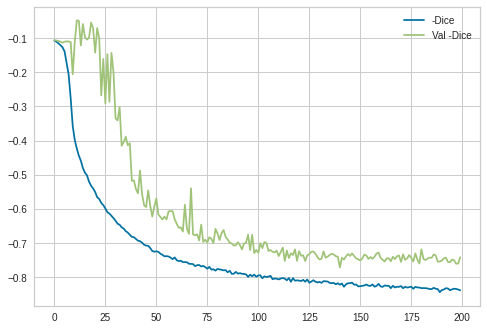

+++++++++++++++++++++++++++++++++++++
[0. 1.]
+++++++++++++++++++++++++++++++++++++


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
46/46 [==============================] - 26s 446ms/step - loss: -0.0938 - iou: 0.0492 - dice_coef: 0.0938 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.8924 - val_loss: -0.1026 - val_iou: 0.0541 - val_dice_coef: 0.1026 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.8096


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 2/200
46/46 [==============================] - 19s 425ms/step - loss: -0.1149 - iou: 0.0609 - dice_coef: 0.1148 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.8710 - val_loss: -0.1078 - val_iou: 0.0570 - val_dice_coef: 0.1078 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9228


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 3/200
46/46 [==============================] - 19s 425ms/step - loss: -0.1330 - iou: 0.0713 - dice_coef: 0.1331 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.8240 - val_loss: -0.1074 - val_iou: 0.0568 - val_dice_coef: 0.1074 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9608


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 4/200
46/46 [==============================] - 19s 425ms/step - loss: -0.1494 - iou: 0.0808 - dice_coef: 0.1494 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.7935 - val_loss: -0.0933 - val_iou: 0.0490 - val_dice_coef: 0.0933 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9658


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 5/200
46/46 [==============================] - 19s 427ms/step - loss: -0.1931 - iou: 0.1069 - dice_coef: 0.1927 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.8439 - val_loss: -0.0066 - val_iou: 0.0033 - val_dice_coef: 0.0066 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 6/200
46/46 [==============================] - 19s 431ms/step - loss: -0.3079 - iou: 0.1826 - dice_coef: 0.3076 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9426 - val_loss: -0.0038 - val_iou: 0.0019 - val_dice_coef: 0.0038 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 7/200
46/46 [==============================] - 19s 424ms/step - loss: -0.4182 - iou: 0.2650 - dice_coef: 0.4180 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9623 - val_loss: -0.0220 - val_iou: 0.0112 - val_dice_coef: 0.0220 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9672


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 8/200
46/46 [==============================] - 19s 426ms/step - loss: -0.4868 - iou: 0.3236 - dice_coef: 0.4871 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9679 - val_loss: -0.0497 - val_iou: 0.0256 - val_dice_coef: 0.0497 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9675


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 9/200
46/46 [==============================] - 19s 426ms/step - loss: -0.5372 - iou: 0.3678 - dice_coef: 0.5365 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9713 - val_loss: -0.2719 - val_iou: 0.1584 - val_dice_coef: 0.2719 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9710


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 10/200
46/46 [==============================] - 19s 427ms/step - loss: -0.5656 - iou: 0.3964 - dice_coef: 0.5654 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9730 - val_loss: -0.3149 - val_iou: 0.1888 - val_dice_coef: 0.3149 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9720


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 11/200
46/46 [==============================] - 19s 426ms/step - loss: -0.5923 - iou: 0.4230 - dice_coef: 0.5924 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9750 - val_loss: -0.3708 - val_iou: 0.2295 - val_dice_coef: 0.3708 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9733


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 12/200
46/46 [==============================] - 19s 427ms/step - loss: -0.6180 - iou: 0.4502 - dice_coef: 0.6183 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9763 - val_loss: -0.4354 - val_iou: 0.2823 - val_dice_coef: 0.4354 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9747


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 13/200
46/46 [==============================] - 19s 424ms/step - loss: -0.6247 - iou: 0.4563 - dice_coef: 0.6243 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9765 - val_loss: -0.5253 - val_iou: 0.3604 - val_dice_coef: 0.5253 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9770


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 14/200
46/46 [==============================] - 19s 425ms/step - loss: -0.6383 - iou: 0.4722 - dice_coef: 0.6390 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9773 - val_loss: -0.5047 - val_iou: 0.3413 - val_dice_coef: 0.5047 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9767


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 15/200
46/46 [==============================] - 19s 428ms/step - loss: -0.6552 - iou: 0.4901 - dice_coef: 0.6546 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9782 - val_loss: -0.5380 - val_iou: 0.3777 - val_dice_coef: 0.5380 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9761


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 16/200
46/46 [==============================] - 19s 425ms/step - loss: -0.6570 - iou: 0.4928 - dice_coef: 0.6573 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9781 - val_loss: -0.5800 - val_iou: 0.4191 - val_dice_coef: 0.5800 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9767


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 17/200
46/46 [==============================] - 19s 423ms/step - loss: -0.6720 - iou: 0.5080 - dice_coef: 0.6716 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9792 - val_loss: -0.5925 - val_iou: 0.4265 - val_dice_coef: 0.5925 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9784


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 18/200
46/46 [==============================] - 19s 427ms/step - loss: -0.6823 - iou: 0.5213 - dice_coef: 0.6831 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9800 - val_loss: -0.6111 - val_iou: 0.4436 - val_dice_coef: 0.6111 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9788


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 19/200
46/46 [==============================] - 19s 429ms/step - loss: -0.6950 - iou: 0.5357 - dice_coef: 0.6946 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9808 - val_loss: -0.6141 - val_iou: 0.4545 - val_dice_coef: 0.6141 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9780


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 20/200
46/46 [==============================] - 19s 424ms/step - loss: -0.6953 - iou: 0.5355 - dice_coef: 0.6951 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9807 - val_loss: -0.6412 - val_iou: 0.4780 - val_dice_coef: 0.6412 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 21/200
46/46 [==============================] - 19s 426ms/step - loss: -0.7005 - iou: 0.5421 - dice_coef: 0.7008 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9810 - val_loss: -0.6527 - val_iou: 0.4946 - val_dice_coef: 0.6527 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9780


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 22/200
46/46 [==============================] - 19s 425ms/step - loss: -0.7090 - iou: 0.5529 - dice_coef: 0.7091 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9813 - val_loss: -0.6578 - val_iou: 0.4997 - val_dice_coef: 0.6578 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 23/200
46/46 [==============================] - 19s 429ms/step - loss: -0.7111 - iou: 0.5544 - dice_coef: 0.7105 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9817 - val_loss: -0.6431 - val_iou: 0.4890 - val_dice_coef: 0.6431 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9783


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 24/200
46/46 [==============================] - 19s 428ms/step - loss: -0.7159 - iou: 0.5631 - dice_coef: 0.7169 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9820 - val_loss: -0.6610 - val_iou: 0.5065 - val_dice_coef: 0.6610 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9793


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 25/200
46/46 [==============================] - 19s 427ms/step - loss: -0.7205 - iou: 0.5672 - dice_coef: 0.7209 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9821 - val_loss: -0.6571 - val_iou: 0.5008 - val_dice_coef: 0.6571 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 26/200
46/46 [==============================] - 19s 426ms/step - loss: -0.7320 - iou: 0.5810 - dice_coef: 0.7325 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9830 - val_loss: -0.6745 - val_iou: 0.5153 - val_dice_coef: 0.6745 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 27/200
46/46 [==============================] - 19s 428ms/step - loss: -0.7260 - iou: 0.5724 - dice_coef: 0.7255 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9824 - val_loss: -0.6671 - val_iou: 0.5101 - val_dice_coef: 0.6671 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9793


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 28/200
46/46 [==============================] - 19s 430ms/step - loss: -0.7279 - iou: 0.5779 - dice_coef: 0.7284 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9826 - val_loss: -0.6932 - val_iou: 0.5390 - val_dice_coef: 0.6932 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 29/200
46/46 [==============================] - 19s 426ms/step - loss: -0.7358 - iou: 0.5877 - dice_coef: 0.7362 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9830 - val_loss: -0.6944 - val_iou: 0.5420 - val_dice_coef: 0.6944 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 30/200
46/46 [==============================] - 19s 427ms/step - loss: -0.7417 - iou: 0.5933 - dice_coef: 0.7420 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9836 - val_loss: -0.6834 - val_iou: 0.5283 - val_dice_coef: 0.6834 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 31/200
46/46 [==============================] - 19s 429ms/step - loss: -0.7361 - iou: 0.5871 - dice_coef: 0.7358 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9831 - val_loss: -0.6814 - val_iou: 0.5323 - val_dice_coef: 0.6814 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 32/200
46/46 [==============================] - 19s 426ms/step - loss: -0.7429 - iou: 0.5949 - dice_coef: 0.7431 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9836 - val_loss: -0.6988 - val_iou: 0.5454 - val_dice_coef: 0.6988 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 33/200
46/46 [==============================] - 19s 427ms/step - loss: -0.7482 - iou: 0.6012 - dice_coef: 0.7475 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9839 - val_loss: -0.7151 - val_iou: 0.5644 - val_dice_coef: 0.7151 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 34/200
46/46 [==============================] - 19s 431ms/step - loss: -0.7505 - iou: 0.6054 - dice_coef: 0.7505 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -0.6907 - val_iou: 0.5424 - val_dice_coef: 0.6907 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 35/200
46/46 [==============================] - 19s 424ms/step - loss: -0.7508 - iou: 0.6049 - dice_coef: 0.7509 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -0.6899 - val_iou: 0.5426 - val_dice_coef: 0.6899 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 36/200
46/46 [==============================] - 19s 429ms/step - loss: -0.7538 - iou: 0.6097 - dice_coef: 0.7542 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -0.6861 - val_iou: 0.5372 - val_dice_coef: 0.6861 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 37/200
46/46 [==============================] - 20s 432ms/step - loss: -0.7570 - iou: 0.6134 - dice_coef: 0.7570 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -0.6743 - val_iou: 0.5230 - val_dice_coef: 0.6743 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 38/200
46/46 [==============================] - 19s 432ms/step - loss: -0.7623 - iou: 0.6129 - dice_coef: 0.7571 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9847 - val_loss: -0.7154 - val_iou: 0.5634 - val_dice_coef: 0.7154 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 39/200
46/46 [==============================] - 19s 424ms/step - loss: -0.7559 - iou: 0.6130 - dice_coef: 0.7560 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -0.7086 - val_iou: 0.5567 - val_dice_coef: 0.7086 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 40/200
46/46 [==============================] - 19s 429ms/step - loss: -0.7625 - iou: 0.6196 - dice_coef: 0.7628 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.7110 - val_iou: 0.5636 - val_dice_coef: 0.7110 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 41/200
46/46 [==============================] - 19s 429ms/step - loss: -0.7616 - iou: 0.6206 - dice_coef: 0.7620 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -0.7121 - val_iou: 0.5613 - val_dice_coef: 0.7121 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 42/200
46/46 [==============================] - 19s 423ms/step - loss: -0.7622 - iou: 0.6193 - dice_coef: 0.7615 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -0.6957 - val_iou: 0.5519 - val_dice_coef: 0.6957 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 43/200
46/46 [==============================] - 19s 427ms/step - loss: -0.7636 - iou: 0.6224 - dice_coef: 0.7638 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.7134 - val_iou: 0.5654 - val_dice_coef: 0.7134 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 44/200
46/46 [==============================] - 19s 428ms/step - loss: -0.7697 - iou: 0.6311 - dice_coef: 0.7702 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.7053 - val_iou: 0.5614 - val_dice_coef: 0.7053 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 45/200
46/46 [==============================] - 19s 429ms/step - loss: -0.7684 - iou: 0.6293 - dice_coef: 0.7685 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.7069 - val_iou: 0.5602 - val_dice_coef: 0.7069 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 46/200
46/46 [==============================] - 19s 426ms/step - loss: -0.7739 - iou: 0.6361 - dice_coef: 0.7741 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.7156 - val_iou: 0.5694 - val_dice_coef: 0.7156 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 47/200
46/46 [==============================] - 19s 428ms/step - loss: -0.7651 - iou: 0.6262 - dice_coef: 0.7652 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.7191 - val_iou: 0.5737 - val_dice_coef: 0.7191 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 48/200
46/46 [==============================] - 19s 426ms/step - loss: -0.7755 - iou: 0.6369 - dice_coef: 0.7753 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.7082 - val_iou: 0.5615 - val_dice_coef: 0.7082 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 49/200
46/46 [==============================] - 19s 431ms/step - loss: -0.7716 - iou: 0.6333 - dice_coef: 0.7718 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -0.7330 - val_iou: 0.5891 - val_dice_coef: 0.7330 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 50/200
46/46 [==============================] - 20s 432ms/step - loss: -0.7748 - iou: 0.6384 - dice_coef: 0.7750 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.7014 - val_iou: 0.5580 - val_dice_coef: 0.7014 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 51/200
46/46 [==============================] - 19s 430ms/step - loss: -0.7744 - iou: 0.6371 - dice_coef: 0.7750 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.7190 - val_iou: 0.5714 - val_dice_coef: 0.7190 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 52/200
46/46 [==============================] - 19s 429ms/step - loss: -0.7769 - iou: 0.6418 - dice_coef: 0.7771 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.7100 - val_iou: 0.5694 - val_dice_coef: 0.7100 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 53/200
46/46 [==============================] - 19s 430ms/step - loss: -0.7760 - iou: 0.6395 - dice_coef: 0.7763 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.7287 - val_iou: 0.5886 - val_dice_coef: 0.7287 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 54/200
46/46 [==============================] - 19s 426ms/step - loss: -0.7756 - iou: 0.6378 - dice_coef: 0.7757 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.7242 - val_iou: 0.5791 - val_dice_coef: 0.7242 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 55/200
46/46 [==============================] - 19s 428ms/step - loss: -0.7847 - iou: 0.6495 - dice_coef: 0.7840 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.7098 - val_iou: 0.5650 - val_dice_coef: 0.7098 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 56/200
46/46 [==============================] - 19s 429ms/step - loss: -0.7841 - iou: 0.6498 - dice_coef: 0.7846 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.7333 - val_iou: 0.5889 - val_dice_coef: 0.7333 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 57/200
46/46 [==============================] - 19s 427ms/step - loss: -0.7784 - iou: 0.6425 - dice_coef: 0.7781 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.7080 - val_iou: 0.5608 - val_dice_coef: 0.7080 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 58/200
46/46 [==============================] - 19s 427ms/step - loss: -0.7866 - iou: 0.6528 - dice_coef: 0.7864 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.7138 - val_iou: 0.5723 - val_dice_coef: 0.7138 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 59/200
46/46 [==============================] - 19s 426ms/step - loss: -0.7861 - iou: 0.6516 - dice_coef: 0.7866 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.7185 - val_iou: 0.5741 - val_dice_coef: 0.7185 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 60/200
46/46 [==============================] - 19s 426ms/step - loss: -0.7857 - iou: 0.6523 - dice_coef: 0.7859 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.7261 - val_iou: 0.5870 - val_dice_coef: 0.7261 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 61/200
46/46 [==============================] - 19s 427ms/step - loss: -0.7878 - iou: 0.6540 - dice_coef: 0.7880 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.7191 - val_iou: 0.5796 - val_dice_coef: 0.7191 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 62/200
46/46 [==============================] - 19s 429ms/step - loss: -0.7841 - iou: 0.6498 - dice_coef: 0.7842 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.7367 - val_iou: 0.5936 - val_dice_coef: 0.7367 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 63/200
46/46 [==============================] - 20s 434ms/step - loss: -0.7894 - iou: 0.6562 - dice_coef: 0.7894 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.6991 - val_iou: 0.5543 - val_dice_coef: 0.6991 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 64/200
46/46 [==============================] - 19s 427ms/step - loss: -0.7911 - iou: 0.6607 - dice_coef: 0.7916 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.7282 - val_iou: 0.5898 - val_dice_coef: 0.7282 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 65/200
46/46 [==============================] - 19s 428ms/step - loss: -0.7894 - iou: 0.6548 - dice_coef: 0.7890 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.7020 - val_iou: 0.5589 - val_dice_coef: 0.7020 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 66/200
46/46 [==============================] - 19s 427ms/step - loss: -0.7919 - iou: 0.6590 - dice_coef: 0.7916 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.7338 - val_iou: 0.5901 - val_dice_coef: 0.7338 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 67/200
46/46 [==============================] - 19s 425ms/step - loss: -0.7868 - iou: 0.6555 - dice_coef: 0.7873 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.7062 - val_iou: 0.5643 - val_dice_coef: 0.7062 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 68/200
46/46 [==============================] - 19s 429ms/step - loss: -0.7932 - iou: 0.6623 - dice_coef: 0.7937 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.7281 - val_iou: 0.5882 - val_dice_coef: 0.7281 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 69/200
46/46 [==============================] - 19s 431ms/step - loss: -0.7899 - iou: 0.6595 - dice_coef: 0.7901 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.7280 - val_iou: 0.5857 - val_dice_coef: 0.7280 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 70/200
46/46 [==============================] - 19s 430ms/step - loss: -0.7906 - iou: 0.6608 - dice_coef: 0.7913 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.7303 - val_iou: 0.5943 - val_dice_coef: 0.7303 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 71/200
46/46 [==============================] - 19s 428ms/step - loss: -0.7912 - iou: 0.6590 - dice_coef: 0.7914 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.7410 - val_iou: 0.6037 - val_dice_coef: 0.7410 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 72/200
46/46 [==============================] - 19s 430ms/step - loss: -0.7940 - iou: 0.6635 - dice_coef: 0.7939 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.7226 - val_iou: 0.5870 - val_dice_coef: 0.7226 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 73/200
46/46 [==============================] - 19s 429ms/step - loss: -0.7902 - iou: 0.6587 - dice_coef: 0.7897 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.7385 - val_iou: 0.5998 - val_dice_coef: 0.7385 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 74/200
46/46 [==============================] - 19s 431ms/step - loss: -0.7970 - iou: 0.6667 - dice_coef: 0.7964 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.7413 - val_iou: 0.5985 - val_dice_coef: 0.7413 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 75/200
46/46 [==============================] - 20s 437ms/step - loss: -0.7958 - iou: 0.6667 - dice_coef: 0.7960 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.7414 - val_iou: 0.6034 - val_dice_coef: 0.7414 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 76/200
46/46 [==============================] - 19s 426ms/step - loss: -0.7978 - iou: 0.6682 - dice_coef: 0.7980 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.7302 - val_iou: 0.5928 - val_dice_coef: 0.7302 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 77/200
46/46 [==============================] - 19s 431ms/step - loss: -0.7962 - iou: 0.6673 - dice_coef: 0.7962 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.7102 - val_iou: 0.5698 - val_dice_coef: 0.7102 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 78/200
46/46 [==============================] - 19s 429ms/step - loss: -0.7977 - iou: 0.6683 - dice_coef: 0.7979 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.7372 - val_iou: 0.5991 - val_dice_coef: 0.7372 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 79/200
46/46 [==============================] - 19s 426ms/step - loss: -0.8008 - iou: 0.6728 - dice_coef: 0.8010 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7292 - val_iou: 0.5894 - val_dice_coef: 0.7292 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 80/200
46/46 [==============================] - 19s 427ms/step - loss: -0.8016 - iou: 0.6746 - dice_coef: 0.8018 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7460 - val_iou: 0.6017 - val_dice_coef: 0.7460 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 81/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8021 - iou: 0.6744 - dice_coef: 0.8024 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7381 - val_iou: 0.5947 - val_dice_coef: 0.7381 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 82/200
46/46 [==============================] - 19s 426ms/step - loss: -0.7974 - iou: 0.6711 - dice_coef: 0.7979 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.7322 - val_iou: 0.5916 - val_dice_coef: 0.7322 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 83/200
46/46 [==============================] - 19s 425ms/step - loss: -0.8014 - iou: 0.6738 - dice_coef: 0.8012 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7379 - val_iou: 0.5974 - val_dice_coef: 0.7379 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 84/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8034 - iou: 0.6760 - dice_coef: 0.8034 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7341 - val_iou: 0.5978 - val_dice_coef: 0.7341 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 85/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8098 - iou: 0.6772 - dice_coef: 0.8049 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7243 - val_iou: 0.5812 - val_dice_coef: 0.7243 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 86/200
46/46 [==============================] - 19s 427ms/step - loss: -0.8012 - iou: 0.6733 - dice_coef: 0.8008 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7492 - val_iou: 0.6114 - val_dice_coef: 0.7492 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 87/200
46/46 [==============================] - 19s 430ms/step - loss: -0.8029 - iou: 0.6757 - dice_coef: 0.8031 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7336 - val_iou: 0.5944 - val_dice_coef: 0.7336 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 88/200
46/46 [==============================] - 19s 431ms/step - loss: -0.8027 - iou: 0.6767 - dice_coef: 0.8031 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7458 - val_iou: 0.6115 - val_dice_coef: 0.7458 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 89/200
46/46 [==============================] - 19s 424ms/step - loss: -0.8062 - iou: 0.6812 - dice_coef: 0.8057 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7277 - val_iou: 0.5876 - val_dice_coef: 0.7277 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 90/200
46/46 [==============================] - 19s 431ms/step - loss: -0.8026 - iou: 0.6765 - dice_coef: 0.8032 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7323 - val_iou: 0.5887 - val_dice_coef: 0.7323 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 91/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8033 - iou: 0.6771 - dice_coef: 0.8037 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7399 - val_iou: 0.6013 - val_dice_coef: 0.7399 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 92/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8065 - iou: 0.6804 - dice_coef: 0.8064 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7383 - val_iou: 0.6033 - val_dice_coef: 0.7383 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 93/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8084 - iou: 0.6824 - dice_coef: 0.8085 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7390 - val_iou: 0.6026 - val_dice_coef: 0.7390 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 94/200
46/46 [==============================] - 19s 427ms/step - loss: -0.8066 - iou: 0.6813 - dice_coef: 0.8065 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7468 - val_iou: 0.6072 - val_dice_coef: 0.7468 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 95/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8051 - iou: 0.6805 - dice_coef: 0.8056 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.7487 - val_iou: 0.6134 - val_dice_coef: 0.7487 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 96/200
46/46 [==============================] - 19s 428ms/step - loss: -0.8050 - iou: 0.6805 - dice_coef: 0.8055 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.7179 - val_iou: 0.5822 - val_dice_coef: 0.7179 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 97/200
46/46 [==============================] - 19s 432ms/step - loss: -0.8085 - iou: 0.6833 - dice_coef: 0.8084 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7314 - val_iou: 0.5927 - val_dice_coef: 0.7314 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 98/200
46/46 [==============================] - 19s 426ms/step - loss: -0.8080 - iou: 0.6839 - dice_coef: 0.8085 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7384 - val_iou: 0.6031 - val_dice_coef: 0.7384 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 99/200
46/46 [==============================] - 19s 427ms/step - loss: -0.8122 - iou: 0.6889 - dice_coef: 0.8127 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7374 - val_iou: 0.5994 - val_dice_coef: 0.7374 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 100/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8090 - iou: 0.6840 - dice_coef: 0.8090 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7462 - val_iou: 0.6035 - val_dice_coef: 0.7462 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 101/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8082 - iou: 0.6847 - dice_coef: 0.8082 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7468 - val_iou: 0.6087 - val_dice_coef: 0.7468 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 102/200
46/46 [==============================] - 19s 430ms/step - loss: -0.8085 - iou: 0.6819 - dice_coef: 0.8076 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7353 - val_iou: 0.5977 - val_dice_coef: 0.7353 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 103/200
46/46 [==============================] - 19s 431ms/step - loss: -0.8154 - iou: 0.6958 - dice_coef: 0.8158 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7316 - val_iou: 0.5962 - val_dice_coef: 0.7316 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 104/200
46/46 [==============================] - 19s 428ms/step - loss: -0.8069 - iou: 0.6820 - dice_coef: 0.8072 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7446 - val_iou: 0.6073 - val_dice_coef: 0.7446 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 105/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8118 - iou: 0.6887 - dice_coef: 0.8119 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7365 - val_iou: 0.6045 - val_dice_coef: 0.7365 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 106/200
46/46 [==============================] - 19s 431ms/step - loss: -0.8137 - iou: 0.6920 - dice_coef: 0.8141 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7520 - val_iou: 0.6152 - val_dice_coef: 0.7520 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 107/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8119 - iou: 0.6893 - dice_coef: 0.8125 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7446 - val_iou: 0.6090 - val_dice_coef: 0.7446 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 108/200
46/46 [==============================] - 19s 428ms/step - loss: -0.8128 - iou: 0.6886 - dice_coef: 0.8128 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7343 - val_iou: 0.5972 - val_dice_coef: 0.7343 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 109/200
46/46 [==============================] - 19s 427ms/step - loss: -0.8129 - iou: 0.6918 - dice_coef: 0.8131 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7491 - val_iou: 0.6161 - val_dice_coef: 0.7491 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 110/200
46/46 [==============================] - 19s 428ms/step - loss: -0.8129 - iou: 0.6919 - dice_coef: 0.8134 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7386 - val_iou: 0.5980 - val_dice_coef: 0.7386 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 111/200
46/46 [==============================] - 19s 428ms/step - loss: -0.8162 - iou: 0.6946 - dice_coef: 0.8162 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7621 - val_iou: 0.6256 - val_dice_coef: 0.7621 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9848


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 112/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8153 - iou: 0.6934 - dice_coef: 0.8155 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7361 - val_iou: 0.5988 - val_dice_coef: 0.7361 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 113/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8119 - iou: 0.6892 - dice_coef: 0.8119 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7372 - val_iou: 0.6012 - val_dice_coef: 0.7372 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 114/200
46/46 [==============================] - 19s 428ms/step - loss: -0.8180 - iou: 0.6968 - dice_coef: 0.8181 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7408 - val_iou: 0.6062 - val_dice_coef: 0.7408 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 115/200
46/46 [==============================] - 19s 430ms/step - loss: -0.8185 - iou: 0.6977 - dice_coef: 0.8188 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7365 - val_iou: 0.6058 - val_dice_coef: 0.7365 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 116/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8168 - iou: 0.6948 - dice_coef: 0.8169 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7464 - val_iou: 0.6100 - val_dice_coef: 0.7464 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 117/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8193 - iou: 0.6986 - dice_coef: 0.8194 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7481 - val_iou: 0.6146 - val_dice_coef: 0.7481 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 118/200
46/46 [==============================] - 19s 430ms/step - loss: -0.8111 - iou: 0.6895 - dice_coef: 0.8111 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7416 - val_iou: 0.6073 - val_dice_coef: 0.7416 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 119/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8169 - iou: 0.6970 - dice_coef: 0.8173 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7519 - val_iou: 0.6142 - val_dice_coef: 0.7519 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 120/200
46/46 [==============================] - 19s 426ms/step - loss: -0.8161 - iou: 0.6941 - dice_coef: 0.8160 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7275 - val_iou: 0.5908 - val_dice_coef: 0.7275 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 121/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8171 - iou: 0.6959 - dice_coef: 0.8166 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7416 - val_iou: 0.6076 - val_dice_coef: 0.7416 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 122/200
46/46 [==============================] - 19s 430ms/step - loss: -0.8147 - iou: 0.6940 - dice_coef: 0.8146 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7506 - val_iou: 0.6111 - val_dice_coef: 0.7506 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 123/200
46/46 [==============================] - 19s 427ms/step - loss: -0.8198 - iou: 0.6992 - dice_coef: 0.8202 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7638 - val_iou: 0.6291 - val_dice_coef: 0.7638 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9846


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 124/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8197 - iou: 0.6995 - dice_coef: 0.8198 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7368 - val_iou: 0.6006 - val_dice_coef: 0.7368 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 125/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8201 - iou: 0.6997 - dice_coef: 0.8204 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7521 - val_iou: 0.6123 - val_dice_coef: 0.7521 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 126/200
46/46 [==============================] - 19s 427ms/step - loss: -0.8218 - iou: 0.7026 - dice_coef: 0.8223 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7610 - val_iou: 0.6216 - val_dice_coef: 0.7610 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 127/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8227 - iou: 0.7042 - dice_coef: 0.8229 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7293 - val_iou: 0.5955 - val_dice_coef: 0.7293 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 128/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8207 - iou: 0.7005 - dice_coef: 0.8211 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7458 - val_iou: 0.6073 - val_dice_coef: 0.7458 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 129/200
46/46 [==============================] - 19s 431ms/step - loss: -0.8196 - iou: 0.7017 - dice_coef: 0.8195 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7479 - val_iou: 0.6105 - val_dice_coef: 0.7479 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 130/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8187 - iou: 0.6994 - dice_coef: 0.8185 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7483 - val_iou: 0.6088 - val_dice_coef: 0.7483 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 131/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8240 - iou: 0.7059 - dice_coef: 0.8240 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7319 - val_iou: 0.5952 - val_dice_coef: 0.7319 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 132/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8294 - iou: 0.7047 - dice_coef: 0.8235 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7420 - val_iou: 0.6086 - val_dice_coef: 0.7420 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 133/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8202 - iou: 0.7024 - dice_coef: 0.8210 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7520 - val_iou: 0.6178 - val_dice_coef: 0.7520 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 134/200
46/46 [==============================] - 19s 430ms/step - loss: -0.8186 - iou: 0.6997 - dice_coef: 0.8192 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7480 - val_iou: 0.6087 - val_dice_coef: 0.7480 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 135/200
46/46 [==============================] - 19s 427ms/step - loss: -0.8240 - iou: 0.7071 - dice_coef: 0.8242 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7458 - val_iou: 0.6142 - val_dice_coef: 0.7458 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 136/200
46/46 [==============================] - 19s 431ms/step - loss: -0.8202 - iou: 0.7023 - dice_coef: 0.8201 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7316 - val_iou: 0.5972 - val_dice_coef: 0.7316 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 137/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8208 - iou: 0.7024 - dice_coef: 0.8211 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7399 - val_iou: 0.6054 - val_dice_coef: 0.7399 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 138/200
46/46 [==============================] - 19s 430ms/step - loss: -0.8245 - iou: 0.7072 - dice_coef: 0.8248 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7360 - val_iou: 0.6014 - val_dice_coef: 0.7360 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 139/200
46/46 [==============================] - 19s 430ms/step - loss: -0.8241 - iou: 0.7056 - dice_coef: 0.8244 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7515 - val_iou: 0.6140 - val_dice_coef: 0.7515 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 140/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8236 - iou: 0.7067 - dice_coef: 0.8237 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7448 - val_iou: 0.6061 - val_dice_coef: 0.7448 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 141/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8216 - iou: 0.7043 - dice_coef: 0.8220 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7465 - val_iou: 0.6094 - val_dice_coef: 0.7465 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 142/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8246 - iou: 0.7090 - dice_coef: 0.8251 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7442 - val_iou: 0.6057 - val_dice_coef: 0.7442 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 143/200
46/46 [==============================] - 19s 430ms/step - loss: -0.8230 - iou: 0.7037 - dice_coef: 0.8229 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7473 - val_iou: 0.6078 - val_dice_coef: 0.7473 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 144/200
46/46 [==============================] - 19s 427ms/step - loss: -0.8241 - iou: 0.7065 - dice_coef: 0.8233 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7466 - val_iou: 0.6117 - val_dice_coef: 0.7466 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 145/200
46/46 [==============================] - 19s 427ms/step - loss: -0.8197 - iou: 0.7015 - dice_coef: 0.8201 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7469 - val_iou: 0.6111 - val_dice_coef: 0.7469 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 146/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8234 - iou: 0.7055 - dice_coef: 0.8232 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7374 - val_iou: 0.6039 - val_dice_coef: 0.7374 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 147/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8256 - iou: 0.7096 - dice_coef: 0.8253 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7541 - val_iou: 0.6182 - val_dice_coef: 0.7541 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9846


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 148/200
46/46 [==============================] - 19s 430ms/step - loss: -0.8241 - iou: 0.7083 - dice_coef: 0.8244 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7379 - val_iou: 0.6041 - val_dice_coef: 0.7379 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 149/200
46/46 [==============================] - 19s 431ms/step - loss: -0.8292 - iou: 0.7132 - dice_coef: 0.8289 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7540 - val_iou: 0.6222 - val_dice_coef: 0.7540 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 150/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8281 - iou: 0.7114 - dice_coef: 0.8279 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7459 - val_iou: 0.6089 - val_dice_coef: 0.7459 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 151/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8289 - iou: 0.7139 - dice_coef: 0.8293 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7528 - val_iou: 0.6153 - val_dice_coef: 0.7528 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 152/200
46/46 [==============================] - 19s 430ms/step - loss: -0.8303 - iou: 0.7148 - dice_coef: 0.8303 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7464 - val_iou: 0.6140 - val_dice_coef: 0.7464 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 153/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8239 - iou: 0.7056 - dice_coef: 0.8239 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7541 - val_iou: 0.6191 - val_dice_coef: 0.7541 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 154/200
46/46 [==============================] - 19s 431ms/step - loss: -0.8299 - iou: 0.7138 - dice_coef: 0.8299 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7477 - val_iou: 0.6102 - val_dice_coef: 0.7477 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 155/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8290 - iou: 0.7147 - dice_coef: 0.8294 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7634 - val_iou: 0.6244 - val_dice_coef: 0.7634 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9850


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 156/200
46/46 [==============================] - 19s 431ms/step - loss: -0.8278 - iou: 0.7115 - dice_coef: 0.8276 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7487 - val_iou: 0.6088 - val_dice_coef: 0.7487 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 157/200
46/46 [==============================] - 19s 427ms/step - loss: -0.8276 - iou: 0.7111 - dice_coef: 0.8274 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7444 - val_iou: 0.6051 - val_dice_coef: 0.7444 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 158/200
46/46 [==============================] - 19s 430ms/step - loss: -0.8270 - iou: 0.7113 - dice_coef: 0.8273 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7567 - val_iou: 0.6202 - val_dice_coef: 0.7567 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 159/200
46/46 [==============================] - 19s 427ms/step - loss: -0.8298 - iou: 0.7145 - dice_coef: 0.8300 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7347 - val_iou: 0.6045 - val_dice_coef: 0.7347 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 160/200
46/46 [==============================] - 19s 427ms/step - loss: -0.8286 - iou: 0.7127 - dice_coef: 0.8287 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7526 - val_iou: 0.6148 - val_dice_coef: 0.7526 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 161/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8266 - iou: 0.7104 - dice_coef: 0.8271 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7719 - val_iou: 0.6356 - val_dice_coef: 0.7719 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9849


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 162/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8293 - iou: 0.7148 - dice_coef: 0.8292 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7535 - val_iou: 0.6189 - val_dice_coef: 0.7535 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 163/200
46/46 [==============================] - 19s 426ms/step - loss: -0.8288 - iou: 0.7141 - dice_coef: 0.8289 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7474 - val_iou: 0.6125 - val_dice_coef: 0.7474 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 164/200
46/46 [==============================] - 19s 428ms/step - loss: -0.8288 - iou: 0.7145 - dice_coef: 0.8284 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7327 - val_iou: 0.6042 - val_dice_coef: 0.7327 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 165/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8273 - iou: 0.7132 - dice_coef: 0.8278 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7498 - val_iou: 0.6193 - val_dice_coef: 0.7498 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 166/200
46/46 [==============================] - 19s 427ms/step - loss: -0.8346 - iou: 0.7205 - dice_coef: 0.8348 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7444 - val_iou: 0.6144 - val_dice_coef: 0.7444 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 167/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8320 - iou: 0.7176 - dice_coef: 0.8324 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7544 - val_iou: 0.6194 - val_dice_coef: 0.7544 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 168/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8305 - iou: 0.7181 - dice_coef: 0.8305 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7304 - val_iou: 0.5962 - val_dice_coef: 0.7304 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 169/200
46/46 [==============================] - 19s 431ms/step - loss: -0.8292 - iou: 0.7151 - dice_coef: 0.8295 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7495 - val_iou: 0.6150 - val_dice_coef: 0.7495 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 170/200
46/46 [==============================] - 19s 428ms/step - loss: -0.8339 - iou: 0.7197 - dice_coef: 0.8342 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7498 - val_iou: 0.6184 - val_dice_coef: 0.7498 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 171/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8371 - iou: 0.7235 - dice_coef: 0.8364 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7442 - val_iou: 0.6081 - val_dice_coef: 0.7442 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 172/200
46/46 [==============================] - 19s 431ms/step - loss: -0.8308 - iou: 0.7155 - dice_coef: 0.8309 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7491 - val_iou: 0.6169 - val_dice_coef: 0.7491 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 173/200
46/46 [==============================] - 19s 428ms/step - loss: -0.8318 - iou: 0.7184 - dice_coef: 0.8314 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7531 - val_iou: 0.6155 - val_dice_coef: 0.7531 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 174/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8308 - iou: 0.7157 - dice_coef: 0.8307 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7544 - val_iou: 0.6188 - val_dice_coef: 0.7544 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 175/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8354 - iou: 0.7224 - dice_coef: 0.8353 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7510 - val_iou: 0.6179 - val_dice_coef: 0.7510 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 176/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8314 - iou: 0.7204 - dice_coef: 0.8317 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7442 - val_iou: 0.6098 - val_dice_coef: 0.7442 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 177/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8290 - iou: 0.7164 - dice_coef: 0.8292 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7589 - val_iou: 0.6216 - val_dice_coef: 0.7589 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 178/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8345 - iou: 0.7215 - dice_coef: 0.8345 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7425 - val_iou: 0.6103 - val_dice_coef: 0.7425 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 179/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8398 - iou: 0.7201 - dice_coef: 0.8336 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9896 - val_loss: -0.7378 - val_iou: 0.5991 - val_dice_coef: 0.7378 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 180/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8382 - iou: 0.7247 - dice_coef: 0.8380 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -0.7429 - val_iou: 0.6043 - val_dice_coef: 0.7429 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 181/200
46/46 [==============================] - 19s 431ms/step - loss: -0.8333 - iou: 0.7218 - dice_coef: 0.8334 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7487 - val_iou: 0.6156 - val_dice_coef: 0.7487 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 182/200
46/46 [==============================] - 19s 430ms/step - loss: -0.8350 - iou: 0.7215 - dice_coef: 0.8346 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7470 - val_iou: 0.6132 - val_dice_coef: 0.7470 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 183/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8371 - iou: 0.7263 - dice_coef: 0.8371 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7608 - val_iou: 0.6252 - val_dice_coef: 0.7608 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 184/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8379 - iou: 0.7259 - dice_coef: 0.8379 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7478 - val_iou: 0.6161 - val_dice_coef: 0.7478 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 185/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8332 - iou: 0.7223 - dice_coef: 0.8338 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7321 - val_iou: 0.5966 - val_dice_coef: 0.7321 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 186/200
46/46 [==============================] - 19s 430ms/step - loss: -0.8357 - iou: 0.7244 - dice_coef: 0.8360 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7581 - val_iou: 0.6226 - val_dice_coef: 0.7581 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 187/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8367 - iou: 0.7245 - dice_coef: 0.8365 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -0.7547 - val_iou: 0.6188 - val_dice_coef: 0.7547 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9845


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 188/200
46/46 [==============================] - 19s 428ms/step - loss: -0.8357 - iou: 0.7240 - dice_coef: 0.8361 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -0.7510 - val_iou: 0.6165 - val_dice_coef: 0.7510 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 189/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8361 - iou: 0.7247 - dice_coef: 0.8360 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -0.7437 - val_iou: 0.6082 - val_dice_coef: 0.7437 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 190/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8346 - iou: 0.7220 - dice_coef: 0.8347 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7372 - val_iou: 0.6039 - val_dice_coef: 0.7372 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 191/200
46/46 [==============================] - 19s 431ms/step - loss: -0.8342 - iou: 0.7231 - dice_coef: 0.8347 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7464 - val_iou: 0.6131 - val_dice_coef: 0.7464 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 192/200
46/46 [==============================] - 19s 431ms/step - loss: -0.8352 - iou: 0.7248 - dice_coef: 0.8358 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7477 - val_iou: 0.6138 - val_dice_coef: 0.7477 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 193/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8365 - iou: 0.7254 - dice_coef: 0.8363 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7452 - val_iou: 0.6175 - val_dice_coef: 0.7452 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 194/200
46/46 [==============================] - 19s 431ms/step - loss: -0.8366 - iou: 0.7231 - dice_coef: 0.8370 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7534 - val_iou: 0.6156 - val_dice_coef: 0.7534 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 195/200
46/46 [==============================] - 19s 428ms/step - loss: -0.8371 - iou: 0.7289 - dice_coef: 0.8373 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7470 - val_iou: 0.6135 - val_dice_coef: 0.7470 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 196/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8395 - iou: 0.7290 - dice_coef: 0.8396 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9896 - val_loss: -0.7577 - val_iou: 0.6231 - val_dice_coef: 0.7577 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 197/200
46/46 [==============================] - 19s 428ms/step - loss: -0.8379 - iou: 0.7265 - dice_coef: 0.8377 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7403 - val_iou: 0.6082 - val_dice_coef: 0.7403 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 198/200
46/46 [==============================] - 19s 431ms/step - loss: -0.8385 - iou: 0.7283 - dice_coef: 0.8387 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7427 - val_iou: 0.6108 - val_dice_coef: 0.7427 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 199/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8380 - iou: 0.7275 - dice_coef: 0.8382 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -0.7519 - val_iou: 0.6224 - val_dice_coef: 0.7519 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 200/200
46/46 [==============================] - 19s 427ms/step - loss: -0.8365 - iou: 0.7268 - dice_coef: 0.8370 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7449 - val_iou: 0.6090 - val_dice_coef: 0.7449 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


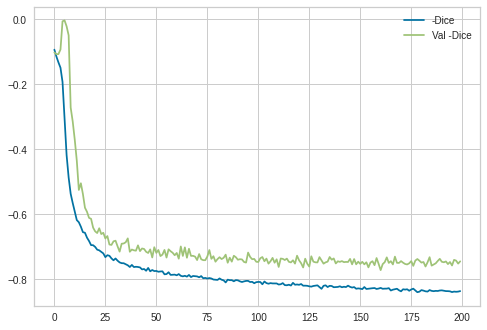

+++++++++++++++++++++++++++++++++++++
[0. 1.]
+++++++++++++++++++++++++++++++++++++


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
46/46 [==============================] - 26s 456ms/step - loss: -0.1096 - iou: 0.0580 - dice_coef: 0.1096 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.8909 - val_loss: -0.1038 - val_iou: 0.0548 - val_dice_coef: 0.1038 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9657


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 2/200
46/46 [==============================] - 19s 431ms/step - loss: -0.1169 - iou: 0.0620 - dice_coef: 0.1168 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.8401 - val_loss: -0.1041 - val_iou: 0.0549 - val_dice_coef: 0.1041 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9390


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 3/200
46/46 [==============================] - 19s 429ms/step - loss: -0.1232 - iou: 0.0657 - dice_coef: 0.1233 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.8000 - val_loss: -0.1054 - val_iou: 0.0557 - val_dice_coef: 0.1054 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.7973


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 4/200
46/46 [==============================] - 19s 429ms/step - loss: -0.1275 - iou: 0.0681 - dice_coef: 0.1274 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.7851 - val_loss: -0.1086 - val_iou: 0.0574 - val_dice_coef: 0.1086 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.6854


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 5/200
46/46 [==============================] - 19s 429ms/step - loss: -0.1314 - iou: 0.0703 - dice_coef: 0.1314 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.7830 - val_loss: -0.1117 - val_iou: 0.0592 - val_dice_coef: 0.1117 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.6590


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 6/200
46/46 [==============================] - 20s 432ms/step - loss: -0.1409 - iou: 0.0759 - dice_coef: 0.1410 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.7943 - val_loss: -0.1467 - val_iou: 0.0792 - val_dice_coef: 0.1467 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.8291


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 7/200
46/46 [==============================] - 19s 429ms/step - loss: -0.1988 - iou: 0.1108 - dice_coef: 0.1990 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.8712 - val_loss: -0.1970 - val_iou: 0.1094 - val_dice_coef: 0.1970 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9586


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 8/200
46/46 [==============================] - 19s 429ms/step - loss: -0.3074 - iou: 0.1830 - dice_coef: 0.3081 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9362 - val_loss: -0.0444 - val_iou: 0.0227 - val_dice_coef: 0.0444 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 9/200
46/46 [==============================] - 20s 436ms/step - loss: -0.3996 - iou: 0.2503 - dice_coef: 0.3992 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9562 - val_loss: -0.0989 - val_iou: 0.0523 - val_dice_coef: 0.0989 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9665


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 10/200
46/46 [==============================] - 19s 428ms/step - loss: -0.4618 - iou: 0.3016 - dice_coef: 0.4621 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9639 - val_loss: -0.1943 - val_iou: 0.1083 - val_dice_coef: 0.1943 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9626


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 11/200
46/46 [==============================] - 20s 433ms/step - loss: -0.4977 - iou: 0.3332 - dice_coef: 0.4973 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -0.3360 - val_iou: 0.2027 - val_dice_coef: 0.3360 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9099


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 12/200
46/46 [==============================] - 20s 432ms/step - loss: -0.5290 - iou: 0.3610 - dice_coef: 0.5291 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9693 - val_loss: -0.3957 - val_iou: 0.2493 - val_dice_coef: 0.3957 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9402


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 13/200
46/46 [==============================] - 19s 431ms/step - loss: -0.5504 - iou: 0.3826 - dice_coef: 0.5510 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9710 - val_loss: -0.4138 - val_iou: 0.2630 - val_dice_coef: 0.4138 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9402


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 14/200
46/46 [==============================] - 20s 432ms/step - loss: -0.5648 - iou: 0.3962 - dice_coef: 0.5654 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9723 - val_loss: -0.4199 - val_iou: 0.2683 - val_dice_coef: 0.4199 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9379


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 15/200
46/46 [==============================] - 20s 434ms/step - loss: -0.5829 - iou: 0.4150 - dice_coef: 0.5834 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9733 - val_loss: -0.3604 - val_iou: 0.2211 - val_dice_coef: 0.3604 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9083


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 16/200
46/46 [==============================] - 19s 431ms/step - loss: -0.5929 - iou: 0.4258 - dice_coef: 0.5942 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9742 - val_loss: -0.4047 - val_iou: 0.2555 - val_dice_coef: 0.4047 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9263


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 17/200
46/46 [==============================] - 19s 429ms/step - loss: -0.6105 - iou: 0.4426 - dice_coef: 0.6115 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9752 - val_loss: -0.4727 - val_iou: 0.3142 - val_dice_coef: 0.4727 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9497


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 18/200
46/46 [==============================] - 20s 434ms/step - loss: -0.6109 - iou: 0.4409 - dice_coef: 0.6104 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9747 - val_loss: -0.4822 - val_iou: 0.3221 - val_dice_coef: 0.4822 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9524


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 19/200
46/46 [==============================] - 19s 431ms/step - loss: -0.6150 - iou: 0.4468 - dice_coef: 0.6148 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9754 - val_loss: -0.4932 - val_iou: 0.3326 - val_dice_coef: 0.4932 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9559


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 20/200
46/46 [==============================] - 19s 428ms/step - loss: -0.6299 - iou: 0.4616 - dice_coef: 0.6297 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9762 - val_loss: -0.4436 - val_iou: 0.2881 - val_dice_coef: 0.4436 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9410


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 21/200
46/46 [==============================] - 20s 433ms/step - loss: -0.6398 - iou: 0.4735 - dice_coef: 0.6401 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9767 - val_loss: -0.5177 - val_iou: 0.3535 - val_dice_coef: 0.5177 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9591


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 22/200
46/46 [==============================] - 20s 434ms/step - loss: -0.6467 - iou: 0.4806 - dice_coef: 0.6463 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9772 - val_loss: -0.5338 - val_iou: 0.3712 - val_dice_coef: 0.5338 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9663


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 23/200
46/46 [==============================] - 19s 430ms/step - loss: -0.6510 - iou: 0.4857 - dice_coef: 0.6515 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9772 - val_loss: -0.5526 - val_iou: 0.3907 - val_dice_coef: 0.5526 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9708


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 24/200
46/46 [==============================] - 19s 431ms/step - loss: -0.6593 - iou: 0.4949 - dice_coef: 0.6593 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9779 - val_loss: -0.5290 - val_iou: 0.3663 - val_dice_coef: 0.5290 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9630


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 25/200
46/46 [==============================] - 20s 434ms/step - loss: -0.6687 - iou: 0.5048 - dice_coef: 0.6692 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9784 - val_loss: -0.5278 - val_iou: 0.3677 - val_dice_coef: 0.5278 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 26/200
46/46 [==============================] - 20s 437ms/step - loss: -0.6717 - iou: 0.5086 - dice_coef: 0.6717 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9787 - val_loss: -0.5463 - val_iou: 0.3836 - val_dice_coef: 0.5463 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9682


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 27/200
46/46 [==============================] - 20s 438ms/step - loss: -0.6825 - iou: 0.5154 - dice_coef: 0.6776 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9793 - val_loss: -0.5705 - val_iou: 0.4055 - val_dice_coef: 0.5705 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9721


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 28/200
46/46 [==============================] - 19s 430ms/step - loss: -0.6862 - iou: 0.5279 - dice_coef: 0.6871 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9795 - val_loss: -0.5610 - val_iou: 0.3973 - val_dice_coef: 0.5610 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9688


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 29/200
46/46 [==============================] - 20s 434ms/step - loss: -0.6875 - iou: 0.5274 - dice_coef: 0.6871 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9796 - val_loss: -0.5626 - val_iou: 0.3966 - val_dice_coef: 0.5626 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9690


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 30/200
46/46 [==============================] - 20s 435ms/step - loss: -0.6937 - iou: 0.5343 - dice_coef: 0.6938 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9802 - val_loss: -0.5868 - val_iou: 0.4237 - val_dice_coef: 0.5868 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9748


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 31/200
46/46 [==============================] - 20s 439ms/step - loss: -0.6945 - iou: 0.5361 - dice_coef: 0.6946 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9800 - val_loss: -0.5727 - val_iou: 0.4091 - val_dice_coef: 0.5727 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9752


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 32/200
46/46 [==============================] - 19s 429ms/step - loss: -0.7020 - iou: 0.5445 - dice_coef: 0.7019 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9807 - val_loss: -0.5999 - val_iou: 0.4324 - val_dice_coef: 0.5999 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9755


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 33/200
46/46 [==============================] - 20s 434ms/step - loss: -0.7028 - iou: 0.5465 - dice_coef: 0.7031 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9805 - val_loss: -0.6010 - val_iou: 0.4366 - val_dice_coef: 0.6010 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9748


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 34/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7063 - iou: 0.5506 - dice_coef: 0.7059 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9808 - val_loss: -0.6001 - val_iou: 0.4361 - val_dice_coef: 0.6001 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9750


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 35/200
46/46 [==============================] - 19s 429ms/step - loss: -0.7155 - iou: 0.5631 - dice_coef: 0.7158 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9816 - val_loss: -0.5994 - val_iou: 0.4346 - val_dice_coef: 0.5994 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9753


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 36/200
46/46 [==============================] - 20s 435ms/step - loss: -0.7147 - iou: 0.5594 - dice_coef: 0.7145 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9814 - val_loss: -0.6235 - val_iou: 0.4576 - val_dice_coef: 0.6235 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9771


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 37/200
46/46 [==============================] - 20s 436ms/step - loss: -0.7244 - iou: 0.5710 - dice_coef: 0.7248 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9820 - val_loss: -0.5943 - val_iou: 0.4328 - val_dice_coef: 0.5943 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9759


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 38/200
46/46 [==============================] - 19s 430ms/step - loss: -0.7185 - iou: 0.5646 - dice_coef: 0.7182 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9816 - val_loss: -0.6002 - val_iou: 0.4337 - val_dice_coef: 0.6002 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9741


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 39/200
46/46 [==============================] - 20s 432ms/step - loss: -0.7286 - iou: 0.5784 - dice_coef: 0.7297 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9823 - val_loss: -0.6122 - val_iou: 0.4478 - val_dice_coef: 0.6122 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9744


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 40/200
46/46 [==============================] - 20s 434ms/step - loss: -0.7350 - iou: 0.5854 - dice_coef: 0.7356 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9827 - val_loss: -0.5995 - val_iou: 0.4383 - val_dice_coef: 0.5995 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9743


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 41/200
46/46 [==============================] - 19s 430ms/step - loss: -0.7334 - iou: 0.5830 - dice_coef: 0.7332 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9826 - val_loss: -0.5852 - val_iou: 0.4227 - val_dice_coef: 0.5852 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9749


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 42/200
46/46 [==============================] - 19s 429ms/step - loss: -0.7392 - iou: 0.5906 - dice_coef: 0.7395 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9830 - val_loss: -0.6046 - val_iou: 0.4420 - val_dice_coef: 0.6046 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9746


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 43/200
46/46 [==============================] - 20s 434ms/step - loss: -0.7431 - iou: 0.5951 - dice_coef: 0.7438 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9833 - val_loss: -0.6177 - val_iou: 0.4555 - val_dice_coef: 0.6177 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9764


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 44/200
46/46 [==============================] - 19s 429ms/step - loss: -0.7408 - iou: 0.5917 - dice_coef: 0.7402 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9830 - val_loss: -0.6158 - val_iou: 0.4534 - val_dice_coef: 0.6158 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9766


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 45/200
46/46 [==============================] - 19s 431ms/step - loss: -0.7430 - iou: 0.5957 - dice_coef: 0.7431 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9833 - val_loss: -0.5809 - val_iou: 0.4202 - val_dice_coef: 0.5809 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9755


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 46/200
46/46 [==============================] - 20s 433ms/step - loss: -0.7464 - iou: 0.5993 - dice_coef: 0.7458 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9836 - val_loss: -0.6078 - val_iou: 0.4485 - val_dice_coef: 0.6078 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9759


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 47/200
46/46 [==============================] - 19s 426ms/step - loss: -0.7484 - iou: 0.6011 - dice_coef: 0.7482 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9836 - val_loss: -0.6143 - val_iou: 0.4523 - val_dice_coef: 0.6143 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9778


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 48/200
46/46 [==============================] - 19s 431ms/step - loss: -0.7518 - iou: 0.6064 - dice_coef: 0.7520 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9838 - val_loss: -0.6181 - val_iou: 0.4586 - val_dice_coef: 0.6181 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9770


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 49/200
46/46 [==============================] - 20s 433ms/step - loss: -0.7542 - iou: 0.6107 - dice_coef: 0.7550 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -0.5954 - val_iou: 0.4363 - val_dice_coef: 0.5954 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9773


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 50/200
46/46 [==============================] - 20s 434ms/step - loss: -0.7500 - iou: 0.6061 - dice_coef: 0.7505 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -0.6035 - val_iou: 0.4379 - val_dice_coef: 0.6035 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9771


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 51/200
46/46 [==============================] - 20s 433ms/step - loss: -0.7527 - iou: 0.6074 - dice_coef: 0.7528 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -0.6231 - val_iou: 0.4589 - val_dice_coef: 0.6231 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9769


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 52/200
46/46 [==============================] - 20s 444ms/step - loss: -0.7549 - iou: 0.6117 - dice_coef: 0.7550 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -0.6331 - val_iou: 0.4751 - val_dice_coef: 0.6331 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9780


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 53/200
46/46 [==============================] - 20s 432ms/step - loss: -0.7597 - iou: 0.6171 - dice_coef: 0.7596 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -0.6243 - val_iou: 0.4687 - val_dice_coef: 0.6243 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9770


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 54/200
46/46 [==============================] - 19s 430ms/step - loss: -0.7600 - iou: 0.6173 - dice_coef: 0.7598 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -0.6267 - val_iou: 0.4663 - val_dice_coef: 0.6267 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9783


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 55/200
46/46 [==============================] - 20s 432ms/step - loss: -0.7641 - iou: 0.6221 - dice_coef: 0.7641 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -0.5995 - val_iou: 0.4389 - val_dice_coef: 0.5995 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9777


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 56/200
46/46 [==============================] - 20s 433ms/step - loss: -0.7657 - iou: 0.6244 - dice_coef: 0.7660 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9847 - val_loss: -0.5988 - val_iou: 0.4370 - val_dice_coef: 0.5988 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9781


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 57/200
46/46 [==============================] - 19s 431ms/step - loss: -0.7616 - iou: 0.6213 - dice_coef: 0.7623 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -0.6165 - val_iou: 0.4562 - val_dice_coef: 0.6165 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9781


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 58/200
46/46 [==============================] - 20s 433ms/step - loss: -0.7690 - iou: 0.6315 - dice_coef: 0.7697 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.6093 - val_iou: 0.4474 - val_dice_coef: 0.6093 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9789


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 59/200
46/46 [==============================] - 20s 434ms/step - loss: -0.7663 - iou: 0.6268 - dice_coef: 0.7672 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.5992 - val_iou: 0.4380 - val_dice_coef: 0.5992 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9777


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 60/200
46/46 [==============================] - 20s 433ms/step - loss: -0.7665 - iou: 0.6265 - dice_coef: 0.7656 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.6124 - val_iou: 0.4516 - val_dice_coef: 0.6124 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9781


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 61/200
46/46 [==============================] - 20s 432ms/step - loss: -0.7693 - iou: 0.6300 - dice_coef: 0.7695 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.6181 - val_iou: 0.4576 - val_dice_coef: 0.6181 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9774


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 62/200
46/46 [==============================] - 19s 431ms/step - loss: -0.7676 - iou: 0.6286 - dice_coef: 0.7680 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.6282 - val_iou: 0.4686 - val_dice_coef: 0.6282 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9786


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 63/200
46/46 [==============================] - 19s 431ms/step - loss: -0.7737 - iou: 0.6355 - dice_coef: 0.7744 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.6373 - val_iou: 0.4782 - val_dice_coef: 0.6373 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9783


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 64/200
46/46 [==============================] - 20s 435ms/step - loss: -0.7718 - iou: 0.6327 - dice_coef: 0.7719 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.6221 - val_iou: 0.4621 - val_dice_coef: 0.6221 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9783


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 65/200
46/46 [==============================] - 20s 432ms/step - loss: -0.7749 - iou: 0.6358 - dice_coef: 0.7747 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.6333 - val_iou: 0.4748 - val_dice_coef: 0.6333 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9781


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 66/200
46/46 [==============================] - 20s 433ms/step - loss: -0.7736 - iou: 0.6371 - dice_coef: 0.7741 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -0.6422 - val_iou: 0.4854 - val_dice_coef: 0.6422 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9779


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 67/200
46/46 [==============================] - 20s 433ms/step - loss: -0.7751 - iou: 0.6386 - dice_coef: 0.7754 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.6052 - val_iou: 0.4444 - val_dice_coef: 0.6052 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9774


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 68/200
46/46 [==============================] - 20s 433ms/step - loss: -0.7761 - iou: 0.6375 - dice_coef: 0.7752 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.6560 - val_iou: 0.5009 - val_dice_coef: 0.6560 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 69/200
46/46 [==============================] - 19s 429ms/step - loss: -0.7780 - iou: 0.6424 - dice_coef: 0.7783 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.6459 - val_iou: 0.4869 - val_dice_coef: 0.6459 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 70/200
46/46 [==============================] - 20s 432ms/step - loss: -0.7835 - iou: 0.6492 - dice_coef: 0.7838 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.6142 - val_iou: 0.4558 - val_dice_coef: 0.6142 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9788


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 71/200
46/46 [==============================] - 20s 433ms/step - loss: -0.7770 - iou: 0.6407 - dice_coef: 0.7773 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.6164 - val_iou: 0.4539 - val_dice_coef: 0.6164 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9793


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 72/200
46/46 [==============================] - 20s 433ms/step - loss: -0.7809 - iou: 0.6450 - dice_coef: 0.7806 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.6422 - val_iou: 0.4810 - val_dice_coef: 0.6422 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 73/200
46/46 [==============================] - 20s 436ms/step - loss: -0.7832 - iou: 0.6488 - dice_coef: 0.7832 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.6518 - val_iou: 0.4977 - val_dice_coef: 0.6518 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 74/200
46/46 [==============================] - 20s 440ms/step - loss: -0.7870 - iou: 0.6452 - dice_coef: 0.7806 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.6382 - val_iou: 0.4779 - val_dice_coef: 0.6382 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 75/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7825 - iou: 0.6478 - dice_coef: 0.7820 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.6443 - val_iou: 0.4827 - val_dice_coef: 0.6443 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 76/200
46/46 [==============================] - 20s 436ms/step - loss: -0.7821 - iou: 0.6488 - dice_coef: 0.7824 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.6437 - val_iou: 0.4880 - val_dice_coef: 0.6437 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 77/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7865 - iou: 0.6520 - dice_coef: 0.7870 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.6566 - val_iou: 0.5032 - val_dice_coef: 0.6566 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 78/200
46/46 [==============================] - 20s 432ms/step - loss: -0.7883 - iou: 0.6552 - dice_coef: 0.7880 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.6543 - val_iou: 0.4961 - val_dice_coef: 0.6543 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 79/200
46/46 [==============================] - 20s 435ms/step - loss: -0.7855 - iou: 0.6532 - dice_coef: 0.7857 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.6662 - val_iou: 0.5110 - val_dice_coef: 0.6662 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 80/200
46/46 [==============================] - 20s 433ms/step - loss: -0.7899 - iou: 0.6574 - dice_coef: 0.7905 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.6608 - val_iou: 0.5086 - val_dice_coef: 0.6608 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 81/200
46/46 [==============================] - 20s 432ms/step - loss: -0.7867 - iou: 0.6552 - dice_coef: 0.7875 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.6624 - val_iou: 0.5042 - val_dice_coef: 0.6624 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 82/200
46/46 [==============================] - 20s 435ms/step - loss: -0.7885 - iou: 0.6567 - dice_coef: 0.7886 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.6578 - val_iou: 0.5017 - val_dice_coef: 0.6578 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 83/200
46/46 [==============================] - 20s 435ms/step - loss: -0.7861 - iou: 0.6556 - dice_coef: 0.7863 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.6621 - val_iou: 0.4996 - val_dice_coef: 0.6621 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 84/200
46/46 [==============================] - 20s 433ms/step - loss: -0.7894 - iou: 0.6560 - dice_coef: 0.7887 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.6637 - val_iou: 0.5088 - val_dice_coef: 0.6637 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 85/200
46/46 [==============================] - 19s 430ms/step - loss: -0.7891 - iou: 0.6578 - dice_coef: 0.7892 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.6434 - val_iou: 0.4899 - val_dice_coef: 0.6434 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 86/200
46/46 [==============================] - 20s 436ms/step - loss: -0.7897 - iou: 0.6573 - dice_coef: 0.7894 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.6652 - val_iou: 0.5089 - val_dice_coef: 0.6652 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 87/200
46/46 [==============================] - 20s 433ms/step - loss: -0.7937 - iou: 0.6638 - dice_coef: 0.7944 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.6851 - val_iou: 0.5270 - val_dice_coef: 0.6851 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 88/200
46/46 [==============================] - 19s 429ms/step - loss: -0.7969 - iou: 0.6669 - dice_coef: 0.7974 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.6338 - val_iou: 0.4783 - val_dice_coef: 0.6338 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 89/200
46/46 [==============================] - 20s 434ms/step - loss: -0.7896 - iou: 0.6576 - dice_coef: 0.7898 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.6459 - val_iou: 0.4901 - val_dice_coef: 0.6459 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 90/200
46/46 [==============================] - 19s 429ms/step - loss: -0.7984 - iou: 0.6693 - dice_coef: 0.7987 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.6338 - val_iou: 0.4768 - val_dice_coef: 0.6338 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 91/200
46/46 [==============================] - 19s 430ms/step - loss: -0.7942 - iou: 0.6648 - dice_coef: 0.7941 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.6534 - val_iou: 0.4984 - val_dice_coef: 0.6534 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 92/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8002 - iou: 0.6707 - dice_coef: 0.8002 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.6622 - val_iou: 0.5060 - val_dice_coef: 0.6622 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 93/200
46/46 [==============================] - 20s 432ms/step - loss: -0.7988 - iou: 0.6703 - dice_coef: 0.7992 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.6476 - val_iou: 0.4902 - val_dice_coef: 0.6476 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 94/200
46/46 [==============================] - 19s 429ms/step - loss: -0.7935 - iou: 0.6625 - dice_coef: 0.7932 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.6546 - val_iou: 0.4992 - val_dice_coef: 0.6546 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 95/200
46/46 [==============================] - 19s 431ms/step - loss: -0.7975 - iou: 0.6700 - dice_coef: 0.7981 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.6659 - val_iou: 0.5110 - val_dice_coef: 0.6659 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 96/200
46/46 [==============================] - 20s 435ms/step - loss: -0.7954 - iou: 0.6651 - dice_coef: 0.7950 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.6909 - val_iou: 0.5363 - val_dice_coef: 0.6909 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 97/200
46/46 [==============================] - 20s 433ms/step - loss: -0.7987 - iou: 0.6701 - dice_coef: 0.7990 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.6469 - val_iou: 0.4941 - val_dice_coef: 0.6469 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 98/200
46/46 [==============================] - 20s 435ms/step - loss: -0.7987 - iou: 0.6704 - dice_coef: 0.7989 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.6460 - val_iou: 0.4942 - val_dice_coef: 0.6460 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 99/200
46/46 [==============================] - 21s 460ms/step - loss: -0.8037 - iou: 0.6756 - dice_coef: 0.8033 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.6742 - val_iou: 0.5195 - val_dice_coef: 0.6742 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 100/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8016 - iou: 0.6737 - dice_coef: 0.8019 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.6550 - val_iou: 0.5040 - val_dice_coef: 0.6550 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 101/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8009 - iou: 0.6739 - dice_coef: 0.8012 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.6763 - val_iou: 0.5201 - val_dice_coef: 0.6763 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 102/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8009 - iou: 0.6728 - dice_coef: 0.8007 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.6661 - val_iou: 0.5154 - val_dice_coef: 0.6661 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 103/200
46/46 [==============================] - 19s 430ms/step - loss: -0.8075 - iou: 0.6805 - dice_coef: 0.8073 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.6823 - val_iou: 0.5306 - val_dice_coef: 0.6823 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 104/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8008 - iou: 0.6737 - dice_coef: 0.8015 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.6884 - val_iou: 0.5377 - val_dice_coef: 0.6884 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 105/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8005 - iou: 0.6732 - dice_coef: 0.8005 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.6805 - val_iou: 0.5251 - val_dice_coef: 0.6805 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 106/200
46/46 [==============================] - 19s 430ms/step - loss: -0.8062 - iou: 0.6812 - dice_coef: 0.8061 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.6868 - val_iou: 0.5351 - val_dice_coef: 0.6868 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 107/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8067 - iou: 0.6803 - dice_coef: 0.8069 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.6724 - val_iou: 0.5197 - val_dice_coef: 0.6724 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 108/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8089 - iou: 0.6834 - dice_coef: 0.8089 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.6740 - val_iou: 0.5157 - val_dice_coef: 0.6740 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 109/200
46/46 [==============================] - 20s 432ms/step - loss: -0.7999 - iou: 0.6726 - dice_coef: 0.8001 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.6696 - val_iou: 0.5190 - val_dice_coef: 0.6696 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 110/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8030 - iou: 0.6778 - dice_coef: 0.8033 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.6658 - val_iou: 0.5120 - val_dice_coef: 0.6658 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 111/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8101 - iou: 0.6863 - dice_coef: 0.8105 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.6759 - val_iou: 0.5232 - val_dice_coef: 0.6759 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 112/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8074 - iou: 0.6817 - dice_coef: 0.8071 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.6858 - val_iou: 0.5370 - val_dice_coef: 0.6858 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 113/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8060 - iou: 0.6791 - dice_coef: 0.8059 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.6572 - val_iou: 0.5058 - val_dice_coef: 0.6572 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 114/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8062 - iou: 0.6819 - dice_coef: 0.8065 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.6879 - val_iou: 0.5336 - val_dice_coef: 0.6879 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 115/200
46/46 [==============================] - 19s 431ms/step - loss: -0.8078 - iou: 0.6839 - dice_coef: 0.8082 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.6552 - val_iou: 0.4996 - val_dice_coef: 0.6552 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 116/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8075 - iou: 0.6821 - dice_coef: 0.8078 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.6811 - val_iou: 0.5253 - val_dice_coef: 0.6811 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 117/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8055 - iou: 0.6802 - dice_coef: 0.8053 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.6754 - val_iou: 0.5233 - val_dice_coef: 0.6754 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 118/200
46/46 [==============================] - 19s 430ms/step - loss: -0.8077 - iou: 0.6828 - dice_coef: 0.8075 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.6945 - val_iou: 0.5455 - val_dice_coef: 0.6945 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 119/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8074 - iou: 0.6835 - dice_coef: 0.8074 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.6741 - val_iou: 0.5230 - val_dice_coef: 0.6741 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 120/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8081 - iou: 0.6832 - dice_coef: 0.8081 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.6820 - val_iou: 0.5362 - val_dice_coef: 0.6820 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 121/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8177 - iou: 0.6879 - dice_coef: 0.8100 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.6788 - val_iou: 0.5286 - val_dice_coef: 0.6788 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 122/200
46/46 [==============================] - 19s 430ms/step - loss: -0.8109 - iou: 0.6859 - dice_coef: 0.8108 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.6989 - val_iou: 0.5454 - val_dice_coef: 0.6989 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 123/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8125 - iou: 0.6902 - dice_coef: 0.8127 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.6809 - val_iou: 0.5316 - val_dice_coef: 0.6809 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 124/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8107 - iou: 0.6873 - dice_coef: 0.8106 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.6896 - val_iou: 0.5375 - val_dice_coef: 0.6896 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 125/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8099 - iou: 0.6859 - dice_coef: 0.8095 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.6928 - val_iou: 0.5460 - val_dice_coef: 0.6928 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 126/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8100 - iou: 0.6857 - dice_coef: 0.8095 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.6967 - val_iou: 0.5469 - val_dice_coef: 0.6967 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 127/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8122 - iou: 0.6913 - dice_coef: 0.8124 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.6785 - val_iou: 0.5252 - val_dice_coef: 0.6785 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 128/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8110 - iou: 0.6883 - dice_coef: 0.8110 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.6999 - val_iou: 0.5509 - val_dice_coef: 0.6999 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 129/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8128 - iou: 0.6914 - dice_coef: 0.8130 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.6947 - val_iou: 0.5515 - val_dice_coef: 0.6947 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 130/200
46/46 [==============================] - 19s 428ms/step - loss: -0.8130 - iou: 0.6892 - dice_coef: 0.8128 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.6766 - val_iou: 0.5251 - val_dice_coef: 0.6766 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 131/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8134 - iou: 0.6915 - dice_coef: 0.8138 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.6923 - val_iou: 0.5439 - val_dice_coef: 0.6923 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 132/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8137 - iou: 0.6914 - dice_coef: 0.8138 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.6820 - val_iou: 0.5316 - val_dice_coef: 0.6820 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 133/200
46/46 [==============================] - 19s 430ms/step - loss: -0.8167 - iou: 0.6970 - dice_coef: 0.8170 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7001 - val_iou: 0.5542 - val_dice_coef: 0.7001 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 134/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8134 - iou: 0.6909 - dice_coef: 0.8136 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.6808 - val_iou: 0.5289 - val_dice_coef: 0.6808 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 135/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8155 - iou: 0.6953 - dice_coef: 0.8156 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.6888 - val_iou: 0.5416 - val_dice_coef: 0.6888 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 136/200
46/46 [==============================] - 19s 430ms/step - loss: -0.8156 - iou: 0.6935 - dice_coef: 0.8151 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7039 - val_iou: 0.5532 - val_dice_coef: 0.7039 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 137/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8152 - iou: 0.6931 - dice_coef: 0.8157 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7093 - val_iou: 0.5599 - val_dice_coef: 0.7093 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 138/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8163 - iou: 0.6948 - dice_coef: 0.8166 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7082 - val_iou: 0.5575 - val_dice_coef: 0.7082 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 139/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8153 - iou: 0.6949 - dice_coef: 0.8158 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.6989 - val_iou: 0.5487 - val_dice_coef: 0.6989 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 140/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8162 - iou: 0.6941 - dice_coef: 0.8160 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.6847 - val_iou: 0.5367 - val_dice_coef: 0.6847 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 141/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8141 - iou: 0.6928 - dice_coef: 0.8142 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7005 - val_iou: 0.5528 - val_dice_coef: 0.7005 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 142/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8169 - iou: 0.6958 - dice_coef: 0.8169 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7203 - val_iou: 0.5778 - val_dice_coef: 0.7203 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 143/200
46/46 [==============================] - 19s 429ms/step - loss: -0.8182 - iou: 0.6968 - dice_coef: 0.8180 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7127 - val_iou: 0.5701 - val_dice_coef: 0.7127 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 144/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8197 - iou: 0.6996 - dice_coef: 0.8193 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7153 - val_iou: 0.5689 - val_dice_coef: 0.7153 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 145/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8141 - iou: 0.6938 - dice_coef: 0.8147 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7162 - val_iou: 0.5762 - val_dice_coef: 0.7162 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 146/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8168 - iou: 0.6949 - dice_coef: 0.8162 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7127 - val_iou: 0.5709 - val_dice_coef: 0.7127 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 147/200
46/46 [==============================] - 19s 431ms/step - loss: -0.8229 - iou: 0.7048 - dice_coef: 0.8230 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7017 - val_iou: 0.5567 - val_dice_coef: 0.7017 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 148/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8205 - iou: 0.7018 - dice_coef: 0.8212 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7044 - val_iou: 0.5560 - val_dice_coef: 0.7044 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 149/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8216 - iou: 0.7014 - dice_coef: 0.8216 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7019 - val_iou: 0.5537 - val_dice_coef: 0.7019 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 150/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8175 - iou: 0.6984 - dice_coef: 0.8174 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7198 - val_iou: 0.5734 - val_dice_coef: 0.7198 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 151/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8213 - iou: 0.7037 - dice_coef: 0.8220 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7113 - val_iou: 0.5628 - val_dice_coef: 0.7113 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 152/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8259 - iou: 0.7086 - dice_coef: 0.8254 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7232 - val_iou: 0.5778 - val_dice_coef: 0.7232 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 153/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8214 - iou: 0.7035 - dice_coef: 0.8216 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7297 - val_iou: 0.5856 - val_dice_coef: 0.7297 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 154/200
46/46 [==============================] - 19s 431ms/step - loss: -0.8230 - iou: 0.7049 - dice_coef: 0.8235 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7067 - val_iou: 0.5624 - val_dice_coef: 0.7067 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 155/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8243 - iou: 0.7073 - dice_coef: 0.8247 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7024 - val_iou: 0.5537 - val_dice_coef: 0.7024 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 156/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8207 - iou: 0.7019 - dice_coef: 0.8208 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7137 - val_iou: 0.5687 - val_dice_coef: 0.7137 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 157/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8232 - iou: 0.7054 - dice_coef: 0.8237 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.6968 - val_iou: 0.5447 - val_dice_coef: 0.6968 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 158/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8234 - iou: 0.7041 - dice_coef: 0.8232 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7047 - val_iou: 0.5632 - val_dice_coef: 0.7047 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 159/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8214 - iou: 0.7026 - dice_coef: 0.8218 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7147 - val_iou: 0.5727 - val_dice_coef: 0.7147 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 160/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8233 - iou: 0.7052 - dice_coef: 0.8234 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7232 - val_iou: 0.5804 - val_dice_coef: 0.7232 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 161/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8233 - iou: 0.7056 - dice_coef: 0.8235 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7108 - val_iou: 0.5636 - val_dice_coef: 0.7108 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 162/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8229 - iou: 0.7052 - dice_coef: 0.8229 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7220 - val_iou: 0.5776 - val_dice_coef: 0.7220 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 163/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8246 - iou: 0.7088 - dice_coef: 0.8248 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7319 - val_iou: 0.5851 - val_dice_coef: 0.7319 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 164/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8218 - iou: 0.7046 - dice_coef: 0.8218 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7254 - val_iou: 0.5830 - val_dice_coef: 0.7254 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 165/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8205 - iou: 0.7021 - dice_coef: 0.8205 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7204 - val_iou: 0.5749 - val_dice_coef: 0.7204 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 166/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8228 - iou: 0.7052 - dice_coef: 0.8226 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7256 - val_iou: 0.5812 - val_dice_coef: 0.7256 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 167/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8272 - iou: 0.7099 - dice_coef: 0.8272 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7220 - val_iou: 0.5812 - val_dice_coef: 0.7220 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 168/200
46/46 [==============================] - 20s 443ms/step - loss: -0.8324 - iou: 0.7094 - dice_coef: 0.8273 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.6951 - val_iou: 0.5493 - val_dice_coef: 0.6951 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 169/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8222 - iou: 0.7050 - dice_coef: 0.8223 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.6973 - val_iou: 0.5566 - val_dice_coef: 0.6973 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 170/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8230 - iou: 0.7070 - dice_coef: 0.8230 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7167 - val_iou: 0.5770 - val_dice_coef: 0.7167 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 171/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8272 - iou: 0.7092 - dice_coef: 0.8269 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7320 - val_iou: 0.5853 - val_dice_coef: 0.7320 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 172/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8268 - iou: 0.7123 - dice_coef: 0.8270 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7212 - val_iou: 0.5749 - val_dice_coef: 0.7212 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 173/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8240 - iou: 0.7069 - dice_coef: 0.8240 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7541 - val_iou: 0.6129 - val_dice_coef: 0.7541 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9845


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 174/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8235 - iou: 0.7065 - dice_coef: 0.8237 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7219 - val_iou: 0.5768 - val_dice_coef: 0.7219 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 175/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8250 - iou: 0.7081 - dice_coef: 0.8251 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7037 - val_iou: 0.5604 - val_dice_coef: 0.7037 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 176/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8294 - iou: 0.7144 - dice_coef: 0.8297 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7181 - val_iou: 0.5856 - val_dice_coef: 0.7181 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 177/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8280 - iou: 0.7136 - dice_coef: 0.8287 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7192 - val_iou: 0.5802 - val_dice_coef: 0.7192 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 178/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8267 - iou: 0.7107 - dice_coef: 0.8269 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7277 - val_iou: 0.5841 - val_dice_coef: 0.7277 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 179/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8283 - iou: 0.7145 - dice_coef: 0.8288 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7150 - val_iou: 0.5770 - val_dice_coef: 0.7150 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 180/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8278 - iou: 0.7123 - dice_coef: 0.8279 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7262 - val_iou: 0.5829 - val_dice_coef: 0.7262 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 181/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8290 - iou: 0.7153 - dice_coef: 0.8295 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7246 - val_iou: 0.5834 - val_dice_coef: 0.7246 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 182/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8305 - iou: 0.7150 - dice_coef: 0.8308 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7251 - val_iou: 0.5862 - val_dice_coef: 0.7251 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 183/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8278 - iou: 0.7121 - dice_coef: 0.8279 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7190 - val_iou: 0.5783 - val_dice_coef: 0.7190 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 184/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8265 - iou: 0.7107 - dice_coef: 0.8255 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7192 - val_iou: 0.5788 - val_dice_coef: 0.7192 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 185/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8338 - iou: 0.7210 - dice_coef: 0.8340 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7141 - val_iou: 0.5779 - val_dice_coef: 0.7141 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 186/200
46/46 [==============================] - 20s 442ms/step - loss: -0.8235 - iou: 0.7073 - dice_coef: 0.8237 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7272 - val_iou: 0.5920 - val_dice_coef: 0.7272 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 187/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8297 - iou: 0.7157 - dice_coef: 0.8296 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7317 - val_iou: 0.5962 - val_dice_coef: 0.7317 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 188/200
46/46 [==============================] - 19s 430ms/step - loss: -0.8323 - iou: 0.7182 - dice_coef: 0.8325 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7369 - val_iou: 0.5965 - val_dice_coef: 0.7369 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 189/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8283 - iou: 0.7126 - dice_coef: 0.8288 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7412 - val_iou: 0.6012 - val_dice_coef: 0.7412 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 190/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8328 - iou: 0.7184 - dice_coef: 0.8323 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7315 - val_iou: 0.5933 - val_dice_coef: 0.7315 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 191/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8277 - iou: 0.7142 - dice_coef: 0.8277 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7393 - val_iou: 0.5990 - val_dice_coef: 0.7393 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 192/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8317 - iou: 0.7190 - dice_coef: 0.8320 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7319 - val_iou: 0.5925 - val_dice_coef: 0.7319 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 193/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8334 - iou: 0.7212 - dice_coef: 0.8337 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7272 - val_iou: 0.5917 - val_dice_coef: 0.7272 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 194/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8329 - iou: 0.7187 - dice_coef: 0.8325 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7266 - val_iou: 0.5908 - val_dice_coef: 0.7266 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 195/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8283 - iou: 0.7146 - dice_coef: 0.8286 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7303 - val_iou: 0.5896 - val_dice_coef: 0.7303 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 196/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8334 - iou: 0.7191 - dice_coef: 0.8326 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7235 - val_iou: 0.5864 - val_dice_coef: 0.7235 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 197/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8283 - iou: 0.7150 - dice_coef: 0.8286 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7398 - val_iou: 0.6041 - val_dice_coef: 0.7398 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 198/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8312 - iou: 0.7162 - dice_coef: 0.8309 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7344 - val_iou: 0.5960 - val_dice_coef: 0.7344 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 199/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8337 - iou: 0.7213 - dice_coef: 0.8338 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7277 - val_iou: 0.5925 - val_dice_coef: 0.7277 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 200/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8321 - iou: 0.7191 - dice_coef: 0.8325 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7330 - val_iou: 0.5916 - val_dice_coef: 0.7330 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


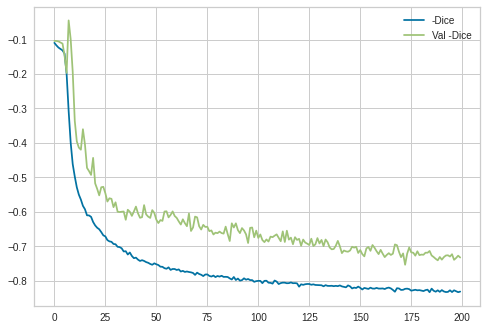

+++++++++++++++++++++++++++++++++++++
[0. 1.]
+++++++++++++++++++++++++++++++++++++


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
46/46 [==============================] - 26s 462ms/step - loss: -0.1030 - iou: 0.0543 - dice_coef: 0.1029 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.7333 - val_loss: -0.1039 - val_iou: 0.0548 - val_dice_coef: 0.1039 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.5222


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 2/200
46/46 [==============================] - 20s 436ms/step - loss: -0.1109 - iou: 0.0587 - dice_coef: 0.1108 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.7386 - val_loss: -0.1077 - val_iou: 0.0569 - val_dice_coef: 0.1077 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.5184


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 3/200
46/46 [==============================] - 19s 431ms/step - loss: -0.1212 - iou: 0.0645 - dice_coef: 0.1212 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.7475 - val_loss: -0.1196 - val_iou: 0.0636 - val_dice_coef: 0.1196 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.7781


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 4/200
46/46 [==============================] - 20s 434ms/step - loss: -0.1318 - iou: 0.0705 - dice_coef: 0.1317 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.7567 - val_loss: -0.0773 - val_iou: 0.0402 - val_dice_coef: 0.0773 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9633


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 5/200
46/46 [==============================] - 20s 432ms/step - loss: -0.1521 - iou: 0.0825 - dice_coef: 0.1523 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.7877 - val_loss: -0.0354 - val_iou: 0.0180 - val_dice_coef: 0.0354 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 6/200
46/46 [==============================] - 20s 436ms/step - loss: -0.2363 - iou: 0.1349 - dice_coef: 0.2369 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.8880 - val_loss: -0.0707 - val_iou: 0.0367 - val_dice_coef: 0.0707 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 7/200
46/46 [==============================] - 20s 436ms/step - loss: -0.3301 - iou: 0.1986 - dice_coef: 0.3307 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9419 - val_loss: -0.0552 - val_iou: 0.0284 - val_dice_coef: 0.0552 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 8/200
46/46 [==============================] - 19s 430ms/step - loss: -0.3978 - iou: 0.2499 - dice_coef: 0.3988 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9564 - val_loss: -0.0603 - val_iou: 0.0311 - val_dice_coef: 0.0603 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9664


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 9/200
46/46 [==============================] - 20s 439ms/step - loss: -0.4425 - iou: 0.2852 - dice_coef: 0.4427 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9634 - val_loss: -0.1680 - val_iou: 0.0924 - val_dice_coef: 0.1680 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9675


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 10/200
46/46 [==============================] - 20s 438ms/step - loss: -0.4830 - iou: 0.3197 - dice_coef: 0.4833 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -0.2453 - val_iou: 0.1406 - val_dice_coef: 0.2453 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9691


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 11/200
46/46 [==============================] - 20s 433ms/step - loss: -0.5095 - iou: 0.3431 - dice_coef: 0.5095 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9694 - val_loss: -0.2831 - val_iou: 0.1661 - val_dice_coef: 0.2831 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9707


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 12/200
46/46 [==============================] - 20s 435ms/step - loss: -0.5336 - iou: 0.3652 - dice_coef: 0.5331 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9715 - val_loss: -0.4290 - val_iou: 0.2773 - val_dice_coef: 0.4290 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9730


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 13/200
46/46 [==============================] - 20s 439ms/step - loss: -0.5530 - iou: 0.3843 - dice_coef: 0.5532 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9731 - val_loss: -0.5002 - val_iou: 0.3367 - val_dice_coef: 0.5002 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9745


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 14/200
46/46 [==============================] - 19s 431ms/step - loss: -0.5760 - iou: 0.4067 - dice_coef: 0.5766 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9746 - val_loss: -0.4874 - val_iou: 0.3237 - val_dice_coef: 0.4874 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9754


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 15/200
46/46 [==============================] - 20s 435ms/step - loss: -0.5907 - iou: 0.4212 - dice_coef: 0.5907 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9753 - val_loss: -0.4745 - val_iou: 0.3156 - val_dice_coef: 0.4745 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9747


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 16/200
46/46 [==============================] - 20s 437ms/step - loss: -0.6058 - iou: 0.4321 - dice_coef: 0.6014 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9767 - val_loss: -0.5548 - val_iou: 0.3890 - val_dice_coef: 0.5548 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9755


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 17/200
46/46 [==============================] - 20s 439ms/step - loss: -0.6132 - iou: 0.4436 - dice_coef: 0.6127 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9767 - val_loss: -0.5527 - val_iou: 0.3894 - val_dice_coef: 0.5527 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9757


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 18/200
46/46 [==============================] - 20s 432ms/step - loss: -0.6255 - iou: 0.4576 - dice_coef: 0.6254 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9777 - val_loss: -0.5559 - val_iou: 0.3926 - val_dice_coef: 0.5559 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9763


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 19/200
46/46 [==============================] - 20s 438ms/step - loss: -0.6339 - iou: 0.4659 - dice_coef: 0.6332 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9779 - val_loss: -0.5475 - val_iou: 0.3834 - val_dice_coef: 0.5475 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9773


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 20/200
46/46 [==============================] - 20s 436ms/step - loss: -0.6404 - iou: 0.4735 - dice_coef: 0.6400 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9783 - val_loss: -0.5330 - val_iou: 0.3685 - val_dice_coef: 0.5330 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9771


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 21/200
46/46 [==============================] - 20s 436ms/step - loss: -0.6479 - iou: 0.4824 - dice_coef: 0.6484 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9789 - val_loss: -0.5278 - val_iou: 0.3625 - val_dice_coef: 0.5278 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9771


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 22/200
46/46 [==============================] - 20s 439ms/step - loss: -0.6633 - iou: 0.4997 - dice_coef: 0.6633 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9799 - val_loss: -0.5875 - val_iou: 0.4220 - val_dice_coef: 0.5875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9787


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 23/200
46/46 [==============================] - 19s 431ms/step - loss: -0.6667 - iou: 0.5024 - dice_coef: 0.6666 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9799 - val_loss: -0.5473 - val_iou: 0.3842 - val_dice_coef: 0.5473 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9766


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 24/200
46/46 [==============================] - 20s 438ms/step - loss: -0.6743 - iou: 0.5126 - dice_coef: 0.6749 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9804 - val_loss: -0.6163 - val_iou: 0.4518 - val_dice_coef: 0.6163 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 25/200
46/46 [==============================] - 20s 439ms/step - loss: -0.6816 - iou: 0.5197 - dice_coef: 0.6814 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9808 - val_loss: -0.6156 - val_iou: 0.4467 - val_dice_coef: 0.6156 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 26/200
46/46 [==============================] - 20s 434ms/step - loss: -0.6850 - iou: 0.5242 - dice_coef: 0.6851 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9810 - val_loss: -0.6521 - val_iou: 0.4909 - val_dice_coef: 0.6521 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 27/200
46/46 [==============================] - 20s 437ms/step - loss: -0.6908 - iou: 0.5310 - dice_coef: 0.6912 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9813 - val_loss: -0.6330 - val_iou: 0.4720 - val_dice_coef: 0.6330 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 28/200
46/46 [==============================] - 20s 443ms/step - loss: -0.6957 - iou: 0.5374 - dice_coef: 0.6958 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9814 - val_loss: -0.6485 - val_iou: 0.4902 - val_dice_coef: 0.6485 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9789


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 29/200
46/46 [==============================] - 20s 434ms/step - loss: -0.7011 - iou: 0.5439 - dice_coef: 0.7012 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9815 - val_loss: -0.6423 - val_iou: 0.4825 - val_dice_coef: 0.6423 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 30/200
46/46 [==============================] - 20s 433ms/step - loss: -0.7024 - iou: 0.5450 - dice_coef: 0.7020 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9817 - val_loss: -0.6341 - val_iou: 0.4754 - val_dice_coef: 0.6341 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 31/200
46/46 [==============================] - 20s 436ms/step - loss: -0.7071 - iou: 0.5528 - dice_coef: 0.7076 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9824 - val_loss: -0.6490 - val_iou: 0.4927 - val_dice_coef: 0.6490 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9793


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 32/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7181 - iou: 0.5650 - dice_coef: 0.7187 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9827 - val_loss: -0.6632 - val_iou: 0.5078 - val_dice_coef: 0.6632 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 33/200
46/46 [==============================] - 20s 433ms/step - loss: -0.7189 - iou: 0.5654 - dice_coef: 0.7194 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9826 - val_loss: -0.6573 - val_iou: 0.5042 - val_dice_coef: 0.6573 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 34/200
46/46 [==============================] - 20s 432ms/step - loss: -0.7209 - iou: 0.5673 - dice_coef: 0.7210 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9831 - val_loss: -0.6694 - val_iou: 0.5100 - val_dice_coef: 0.6694 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 35/200
46/46 [==============================] - 20s 434ms/step - loss: -0.7294 - iou: 0.5780 - dice_coef: 0.7293 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9834 - val_loss: -0.6601 - val_iou: 0.5079 - val_dice_coef: 0.6601 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 36/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7282 - iou: 0.5755 - dice_coef: 0.7281 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9832 - val_loss: -0.6523 - val_iou: 0.4961 - val_dice_coef: 0.6523 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 37/200
46/46 [==============================] - 20s 433ms/step - loss: -0.7229 - iou: 0.5725 - dice_coef: 0.7231 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9830 - val_loss: -0.6492 - val_iou: 0.4958 - val_dice_coef: 0.6492 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 38/200
46/46 [==============================] - 19s 432ms/step - loss: -0.7367 - iou: 0.5876 - dice_coef: 0.7370 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -0.6847 - val_iou: 0.5274 - val_dice_coef: 0.6847 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 39/200
46/46 [==============================] - 20s 434ms/step - loss: -0.7395 - iou: 0.5910 - dice_coef: 0.7397 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -0.6769 - val_iou: 0.5230 - val_dice_coef: 0.6769 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 40/200
46/46 [==============================] - 20s 437ms/step - loss: -0.7402 - iou: 0.5904 - dice_coef: 0.7394 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -0.6846 - val_iou: 0.5323 - val_dice_coef: 0.6846 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 41/200
46/46 [==============================] - 20s 432ms/step - loss: -0.7395 - iou: 0.5914 - dice_coef: 0.7398 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9838 - val_loss: -0.6979 - val_iou: 0.5508 - val_dice_coef: 0.6979 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 42/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7407 - iou: 0.5932 - dice_coef: 0.7407 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -0.6776 - val_iou: 0.5301 - val_dice_coef: 0.6776 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 43/200
46/46 [==============================] - 20s 437ms/step - loss: -0.7464 - iou: 0.6007 - dice_coef: 0.7466 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -0.6690 - val_iou: 0.5133 - val_dice_coef: 0.6690 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 44/200
46/46 [==============================] - 20s 436ms/step - loss: -0.7514 - iou: 0.6066 - dice_coef: 0.7521 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -0.6896 - val_iou: 0.5384 - val_dice_coef: 0.6896 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 45/200
46/46 [==============================] - 19s 431ms/step - loss: -0.7485 - iou: 0.6019 - dice_coef: 0.7489 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -0.7090 - val_iou: 0.5642 - val_dice_coef: 0.7090 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 46/200
46/46 [==============================] - 20s 435ms/step - loss: -0.7482 - iou: 0.6033 - dice_coef: 0.7485 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -0.6920 - val_iou: 0.5481 - val_dice_coef: 0.6920 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 47/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7534 - iou: 0.6087 - dice_coef: 0.7537 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -0.6997 - val_iou: 0.5546 - val_dice_coef: 0.6997 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 48/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7620 - iou: 0.6183 - dice_coef: 0.7615 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.7091 - val_iou: 0.5612 - val_dice_coef: 0.7091 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 49/200
46/46 [==============================] - 20s 435ms/step - loss: -0.7589 - iou: 0.6154 - dice_coef: 0.7586 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.6899 - val_iou: 0.5373 - val_dice_coef: 0.6899 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 50/200
46/46 [==============================] - 20s 436ms/step - loss: -0.7624 - iou: 0.6205 - dice_coef: 0.7625 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -0.7120 - val_iou: 0.5699 - val_dice_coef: 0.7120 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 51/200
46/46 [==============================] - 20s 434ms/step - loss: -0.7609 - iou: 0.6181 - dice_coef: 0.7603 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.7133 - val_iou: 0.5665 - val_dice_coef: 0.7133 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 52/200
46/46 [==============================] - 20s 439ms/step - loss: -0.7682 - iou: 0.6263 - dice_coef: 0.7673 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.7142 - val_iou: 0.5639 - val_dice_coef: 0.7142 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 53/200
46/46 [==============================] - 20s 440ms/step - loss: -0.7667 - iou: 0.6266 - dice_coef: 0.7671 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.7148 - val_iou: 0.5686 - val_dice_coef: 0.7148 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 54/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7655 - iou: 0.6236 - dice_coef: 0.7647 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.7180 - val_iou: 0.5740 - val_dice_coef: 0.7180 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 55/200
46/46 [==============================] - 20s 437ms/step - loss: -0.7712 - iou: 0.6320 - dice_coef: 0.7711 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.7373 - val_iou: 0.5912 - val_dice_coef: 0.7373 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 56/200
46/46 [==============================] - 19s 431ms/step - loss: -0.7667 - iou: 0.6272 - dice_coef: 0.7674 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.7124 - val_iou: 0.5655 - val_dice_coef: 0.7124 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 57/200
46/46 [==============================] - 20s 435ms/step - loss: -0.7713 - iou: 0.6322 - dice_coef: 0.7716 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.6984 - val_iou: 0.5476 - val_dice_coef: 0.6984 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 58/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7648 - iou: 0.6260 - dice_coef: 0.7654 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -0.7101 - val_iou: 0.5697 - val_dice_coef: 0.7101 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 59/200
46/46 [==============================] - 20s 435ms/step - loss: -0.7765 - iou: 0.6415 - dice_coef: 0.7774 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.7284 - val_iou: 0.5870 - val_dice_coef: 0.7284 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 60/200
46/46 [==============================] - 20s 442ms/step - loss: -0.7774 - iou: 0.6386 - dice_coef: 0.7763 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.7168 - val_iou: 0.5688 - val_dice_coef: 0.7168 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 61/200
46/46 [==============================] - 20s 437ms/step - loss: -0.7732 - iou: 0.6345 - dice_coef: 0.7735 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.7228 - val_iou: 0.5758 - val_dice_coef: 0.7228 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 62/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7781 - iou: 0.6414 - dice_coef: 0.7781 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.7243 - val_iou: 0.5829 - val_dice_coef: 0.7243 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 63/200
46/46 [==============================] - 20s 439ms/step - loss: -0.7819 - iou: 0.6386 - dice_coef: 0.7767 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.7208 - val_iou: 0.5800 - val_dice_coef: 0.7208 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 64/200
46/46 [==============================] - 20s 436ms/step - loss: -0.7766 - iou: 0.6380 - dice_coef: 0.7758 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.7249 - val_iou: 0.5820 - val_dice_coef: 0.7249 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 65/200
46/46 [==============================] - 20s 432ms/step - loss: -0.7793 - iou: 0.6425 - dice_coef: 0.7794 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.7185 - val_iou: 0.5766 - val_dice_coef: 0.7185 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 66/200
46/46 [==============================] - 20s 439ms/step - loss: -0.7794 - iou: 0.6448 - dice_coef: 0.7793 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.7203 - val_iou: 0.5801 - val_dice_coef: 0.7203 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 67/200
46/46 [==============================] - 20s 437ms/step - loss: -0.7823 - iou: 0.6473 - dice_coef: 0.7827 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.7158 - val_iou: 0.5720 - val_dice_coef: 0.7158 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 68/200
46/46 [==============================] - 20s 434ms/step - loss: -0.7853 - iou: 0.6500 - dice_coef: 0.7854 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.7325 - val_iou: 0.5933 - val_dice_coef: 0.7325 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 69/200
46/46 [==============================] - 20s 442ms/step - loss: -0.7859 - iou: 0.6517 - dice_coef: 0.7859 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.7273 - val_iou: 0.5846 - val_dice_coef: 0.7273 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 70/200
46/46 [==============================] - 20s 439ms/step - loss: -0.7819 - iou: 0.6462 - dice_coef: 0.7806 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.7136 - val_iou: 0.5699 - val_dice_coef: 0.7136 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 71/200
46/46 [==============================] - 20s 432ms/step - loss: -0.7889 - iou: 0.6558 - dice_coef: 0.7890 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.7321 - val_iou: 0.5913 - val_dice_coef: 0.7321 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 72/200
46/46 [==============================] - 20s 441ms/step - loss: -0.7909 - iou: 0.6590 - dice_coef: 0.7916 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.7223 - val_iou: 0.5844 - val_dice_coef: 0.7223 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 73/200
46/46 [==============================] - 20s 437ms/step - loss: -0.7840 - iou: 0.6504 - dice_coef: 0.7842 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.7326 - val_iou: 0.5932 - val_dice_coef: 0.7326 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 74/200
46/46 [==============================] - 20s 432ms/step - loss: -0.7894 - iou: 0.6569 - dice_coef: 0.7897 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.7286 - val_iou: 0.5897 - val_dice_coef: 0.7286 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 75/200
46/46 [==============================] - 20s 434ms/step - loss: -0.7832 - iou: 0.6514 - dice_coef: 0.7836 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.7225 - val_iou: 0.5834 - val_dice_coef: 0.7225 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 76/200
46/46 [==============================] - 20s 436ms/step - loss: -0.7924 - iou: 0.6626 - dice_coef: 0.7929 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.7298 - val_iou: 0.5882 - val_dice_coef: 0.7298 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 77/200
46/46 [==============================] - 20s 437ms/step - loss: -0.7854 - iou: 0.6515 - dice_coef: 0.7851 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.7319 - val_iou: 0.5951 - val_dice_coef: 0.7319 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 78/200
46/46 [==============================] - 20s 437ms/step - loss: -0.7930 - iou: 0.6625 - dice_coef: 0.7933 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.7343 - val_iou: 0.5939 - val_dice_coef: 0.7343 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 79/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7933 - iou: 0.6623 - dice_coef: 0.7934 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.7189 - val_iou: 0.5797 - val_dice_coef: 0.7189 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 80/200
46/46 [==============================] - 20s 434ms/step - loss: -0.7916 - iou: 0.6610 - dice_coef: 0.7920 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.7272 - val_iou: 0.5859 - val_dice_coef: 0.7272 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 81/200
46/46 [==============================] - 20s 439ms/step - loss: -0.7963 - iou: 0.6661 - dice_coef: 0.7963 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7358 - val_iou: 0.5975 - val_dice_coef: 0.7358 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 82/200
46/46 [==============================] - 20s 437ms/step - loss: -0.7932 - iou: 0.6628 - dice_coef: 0.7933 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.7325 - val_iou: 0.5924 - val_dice_coef: 0.7325 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 83/200
46/46 [==============================] - 20s 436ms/step - loss: -0.7920 - iou: 0.6607 - dice_coef: 0.7920 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.7247 - val_iou: 0.5833 - val_dice_coef: 0.7247 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 84/200
46/46 [==============================] - 20s 436ms/step - loss: -0.7950 - iou: 0.6664 - dice_coef: 0.7951 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.7357 - val_iou: 0.5969 - val_dice_coef: 0.7357 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 85/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7932 - iou: 0.6609 - dice_coef: 0.7930 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.7330 - val_iou: 0.5940 - val_dice_coef: 0.7330 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 86/200
46/46 [==============================] - 20s 435ms/step - loss: -0.7977 - iou: 0.6702 - dice_coef: 0.7983 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.7488 - val_iou: 0.6089 - val_dice_coef: 0.7488 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 87/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7983 - iou: 0.6698 - dice_coef: 0.7982 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7343 - val_iou: 0.5959 - val_dice_coef: 0.7343 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 88/200
46/46 [==============================] - 20s 435ms/step - loss: -0.7975 - iou: 0.6694 - dice_coef: 0.7978 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7308 - val_iou: 0.5955 - val_dice_coef: 0.7308 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 89/200
46/46 [==============================] - 20s 435ms/step - loss: -0.7921 - iou: 0.6642 - dice_coef: 0.7927 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.7396 - val_iou: 0.6027 - val_dice_coef: 0.7396 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 90/200
46/46 [==============================] - 20s 437ms/step - loss: -0.7968 - iou: 0.6684 - dice_coef: 0.7965 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7434 - val_iou: 0.6060 - val_dice_coef: 0.7434 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 91/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8025 - iou: 0.6754 - dice_coef: 0.8027 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.7331 - val_iou: 0.5926 - val_dice_coef: 0.7331 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 92/200
46/46 [==============================] - 20s 436ms/step - loss: -0.7975 - iou: 0.6686 - dice_coef: 0.7980 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.7399 - val_iou: 0.5971 - val_dice_coef: 0.7399 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 93/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8025 - iou: 0.6758 - dice_coef: 0.8030 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7478 - val_iou: 0.6070 - val_dice_coef: 0.7478 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 94/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8007 - iou: 0.6730 - dice_coef: 0.8006 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7405 - val_iou: 0.6026 - val_dice_coef: 0.7405 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 95/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8015 - iou: 0.6743 - dice_coef: 0.8016 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7203 - val_iou: 0.5860 - val_dice_coef: 0.7203 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 96/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8020 - iou: 0.6738 - dice_coef: 0.8011 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7535 - val_iou: 0.6140 - val_dice_coef: 0.7535 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 97/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8046 - iou: 0.6782 - dice_coef: 0.8051 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.7324 - val_iou: 0.5965 - val_dice_coef: 0.7324 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 98/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8004 - iou: 0.6749 - dice_coef: 0.8003 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7341 - val_iou: 0.5991 - val_dice_coef: 0.7341 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 99/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8001 - iou: 0.6737 - dice_coef: 0.8001 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7303 - val_iou: 0.5940 - val_dice_coef: 0.7303 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 100/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8042 - iou: 0.6792 - dice_coef: 0.8048 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7304 - val_iou: 0.5981 - val_dice_coef: 0.7304 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 101/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8062 - iou: 0.6811 - dice_coef: 0.8067 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7486 - val_iou: 0.6093 - val_dice_coef: 0.7486 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 102/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8050 - iou: 0.6801 - dice_coef: 0.8054 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.7387 - val_iou: 0.6049 - val_dice_coef: 0.7387 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 103/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8059 - iou: 0.6796 - dice_coef: 0.8056 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7393 - val_iou: 0.6024 - val_dice_coef: 0.7393 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 104/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8111 - iou: 0.6869 - dice_coef: 0.8115 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7366 - val_iou: 0.6022 - val_dice_coef: 0.7366 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 105/200
46/46 [==============================] - 20s 442ms/step - loss: -0.8060 - iou: 0.6817 - dice_coef: 0.8064 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7270 - val_iou: 0.5854 - val_dice_coef: 0.7270 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 106/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8094 - iou: 0.6859 - dice_coef: 0.8096 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7596 - val_iou: 0.6174 - val_dice_coef: 0.7596 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9846


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 107/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8076 - iou: 0.6826 - dice_coef: 0.8078 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7533 - val_iou: 0.6137 - val_dice_coef: 0.7533 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 108/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8102 - iou: 0.6866 - dice_coef: 0.8107 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7535 - val_iou: 0.6119 - val_dice_coef: 0.7535 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 109/200
46/46 [==============================] - 21s 469ms/step - loss: -0.8115 - iou: 0.6876 - dice_coef: 0.8115 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7383 - val_iou: 0.6032 - val_dice_coef: 0.7383 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 110/200
46/46 [==============================] - 20s 443ms/step - loss: -0.8181 - iou: 0.6887 - dice_coef: 0.8126 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7514 - val_iou: 0.6157 - val_dice_coef: 0.7514 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 111/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8093 - iou: 0.6847 - dice_coef: 0.8090 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7337 - val_iou: 0.6007 - val_dice_coef: 0.7337 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 112/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8083 - iou: 0.6835 - dice_coef: 0.8083 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7510 - val_iou: 0.6132 - val_dice_coef: 0.7510 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 113/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8106 - iou: 0.6861 - dice_coef: 0.8110 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7445 - val_iou: 0.6084 - val_dice_coef: 0.7445 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 114/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8101 - iou: 0.6884 - dice_coef: 0.8101 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7632 - val_iou: 0.6251 - val_dice_coef: 0.7632 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9846


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 115/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8123 - iou: 0.6897 - dice_coef: 0.8122 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7484 - val_iou: 0.6108 - val_dice_coef: 0.7484 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 116/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8079 - iou: 0.6847 - dice_coef: 0.8073 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7396 - val_iou: 0.6016 - val_dice_coef: 0.7396 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 117/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8112 - iou: 0.6889 - dice_coef: 0.8113 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7386 - val_iou: 0.6031 - val_dice_coef: 0.7386 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 118/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8100 - iou: 0.6861 - dice_coef: 0.8103 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7318 - val_iou: 0.5997 - val_dice_coef: 0.7318 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 119/200
46/46 [==============================] - 20s 444ms/step - loss: -0.8175 - iou: 0.6964 - dice_coef: 0.8178 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7522 - val_iou: 0.6175 - val_dice_coef: 0.7522 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 120/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8097 - iou: 0.6859 - dice_coef: 0.8097 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7328 - val_iou: 0.5974 - val_dice_coef: 0.7328 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 121/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8122 - iou: 0.6901 - dice_coef: 0.8124 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7541 - val_iou: 0.6218 - val_dice_coef: 0.7541 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 122/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8172 - iou: 0.6958 - dice_coef: 0.8174 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7439 - val_iou: 0.6079 - val_dice_coef: 0.7439 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 123/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8151 - iou: 0.6927 - dice_coef: 0.8156 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7256 - val_iou: 0.5902 - val_dice_coef: 0.7256 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 124/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8166 - iou: 0.6945 - dice_coef: 0.8168 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7590 - val_iou: 0.6233 - val_dice_coef: 0.7590 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 125/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8153 - iou: 0.6939 - dice_coef: 0.8159 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7551 - val_iou: 0.6190 - val_dice_coef: 0.7551 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 126/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8151 - iou: 0.6940 - dice_coef: 0.8155 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7448 - val_iou: 0.6120 - val_dice_coef: 0.7448 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 127/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8159 - iou: 0.6958 - dice_coef: 0.8163 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7415 - val_iou: 0.6078 - val_dice_coef: 0.7415 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 128/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8192 - iou: 0.7004 - dice_coef: 0.8195 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7521 - val_iou: 0.6173 - val_dice_coef: 0.7521 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 129/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8168 - iou: 0.6961 - dice_coef: 0.8171 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7352 - val_iou: 0.6008 - val_dice_coef: 0.7352 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 130/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8166 - iou: 0.6958 - dice_coef: 0.8165 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7392 - val_iou: 0.6073 - val_dice_coef: 0.7392 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 131/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8193 - iou: 0.6994 - dice_coef: 0.8198 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7582 - val_iou: 0.6210 - val_dice_coef: 0.7582 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 132/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8155 - iou: 0.6962 - dice_coef: 0.8162 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7442 - val_iou: 0.6099 - val_dice_coef: 0.7442 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 133/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8218 - iou: 0.7032 - dice_coef: 0.8220 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7449 - val_iou: 0.6148 - val_dice_coef: 0.7449 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 134/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8189 - iou: 0.6994 - dice_coef: 0.8194 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7329 - val_iou: 0.5981 - val_dice_coef: 0.7329 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 135/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8158 - iou: 0.6946 - dice_coef: 0.8159 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7453 - val_iou: 0.6129 - val_dice_coef: 0.7453 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 136/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8187 - iou: 0.6982 - dice_coef: 0.8187 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7449 - val_iou: 0.6114 - val_dice_coef: 0.7449 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 137/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8189 - iou: 0.6993 - dice_coef: 0.8186 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7541 - val_iou: 0.6192 - val_dice_coef: 0.7541 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 138/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8176 - iou: 0.6984 - dice_coef: 0.8180 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7449 - val_iou: 0.6124 - val_dice_coef: 0.7449 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 139/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8211 - iou: 0.7021 - dice_coef: 0.8216 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7446 - val_iou: 0.6129 - val_dice_coef: 0.7446 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 140/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8249 - iou: 0.7074 - dice_coef: 0.8253 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7417 - val_iou: 0.6099 - val_dice_coef: 0.7417 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 141/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8208 - iou: 0.7010 - dice_coef: 0.8210 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7510 - val_iou: 0.6170 - val_dice_coef: 0.7510 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 142/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8234 - iou: 0.7063 - dice_coef: 0.8238 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7473 - val_iou: 0.6152 - val_dice_coef: 0.7473 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 143/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8177 - iou: 0.6988 - dice_coef: 0.8179 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7563 - val_iou: 0.6230 - val_dice_coef: 0.7563 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 144/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8268 - iou: 0.7110 - dice_coef: 0.8263 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7468 - val_iou: 0.6129 - val_dice_coef: 0.7468 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 145/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8249 - iou: 0.7058 - dice_coef: 0.8253 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7308 - val_iou: 0.5993 - val_dice_coef: 0.7308 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 146/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8240 - iou: 0.7071 - dice_coef: 0.8245 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7352 - val_iou: 0.6014 - val_dice_coef: 0.7352 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 147/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8209 - iou: 0.7019 - dice_coef: 0.8214 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7503 - val_iou: 0.6116 - val_dice_coef: 0.7503 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 148/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8221 - iou: 0.7046 - dice_coef: 0.8218 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7492 - val_iou: 0.6147 - val_dice_coef: 0.7492 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 149/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8212 - iou: 0.7036 - dice_coef: 0.8214 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7384 - val_iou: 0.6056 - val_dice_coef: 0.7384 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 150/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8248 - iou: 0.7078 - dice_coef: 0.8248 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7513 - val_iou: 0.6163 - val_dice_coef: 0.7513 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 151/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8254 - iou: 0.7071 - dice_coef: 0.8255 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7588 - val_iou: 0.6229 - val_dice_coef: 0.7588 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 152/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8220 - iou: 0.7038 - dice_coef: 0.8223 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7367 - val_iou: 0.6054 - val_dice_coef: 0.7367 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 153/200
46/46 [==============================] - 20s 443ms/step - loss: -0.8251 - iou: 0.7083 - dice_coef: 0.8252 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7570 - val_iou: 0.6187 - val_dice_coef: 0.7570 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9846


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 154/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8242 - iou: 0.7076 - dice_coef: 0.8248 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7479 - val_iou: 0.6140 - val_dice_coef: 0.7479 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 155/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8233 - iou: 0.7072 - dice_coef: 0.8233 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7413 - val_iou: 0.6047 - val_dice_coef: 0.7413 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 156/200
46/46 [==============================] - 20s 445ms/step - loss: -0.8265 - iou: 0.7085 - dice_coef: 0.8265 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7540 - val_iou: 0.6229 - val_dice_coef: 0.7540 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 157/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8277 - iou: 0.7022 - dice_coef: 0.8204 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7396 - val_iou: 0.6044 - val_dice_coef: 0.7396 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 158/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8248 - iou: 0.7084 - dice_coef: 0.8250 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7638 - val_iou: 0.6305 - val_dice_coef: 0.7638 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 159/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8248 - iou: 0.7081 - dice_coef: 0.8248 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7457 - val_iou: 0.6126 - val_dice_coef: 0.7457 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 160/200
46/46 [==============================] - 20s 444ms/step - loss: -0.8250 - iou: 0.7093 - dice_coef: 0.8255 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7511 - val_iou: 0.6165 - val_dice_coef: 0.7511 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 161/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8272 - iou: 0.7127 - dice_coef: 0.8276 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7444 - val_iou: 0.6142 - val_dice_coef: 0.7444 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 162/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8253 - iou: 0.7085 - dice_coef: 0.8252 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7502 - val_iou: 0.6165 - val_dice_coef: 0.7502 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 163/200
46/46 [==============================] - 20s 432ms/step - loss: -0.8255 - iou: 0.7089 - dice_coef: 0.8255 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7503 - val_iou: 0.6118 - val_dice_coef: 0.7503 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 164/200
46/46 [==============================] - 20s 442ms/step - loss: -0.8252 - iou: 0.7092 - dice_coef: 0.8255 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7455 - val_iou: 0.6099 - val_dice_coef: 0.7455 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 165/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8268 - iou: 0.7110 - dice_coef: 0.8269 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7624 - val_iou: 0.6252 - val_dice_coef: 0.7624 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9847


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 166/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8263 - iou: 0.7105 - dice_coef: 0.8266 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7497 - val_iou: 0.6206 - val_dice_coef: 0.7497 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 167/200
46/46 [==============================] - 20s 443ms/step - loss: -0.8249 - iou: 0.7098 - dice_coef: 0.8251 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7506 - val_iou: 0.6149 - val_dice_coef: 0.7506 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 168/200
46/46 [==============================] - 20s 445ms/step - loss: -0.8306 - iou: 0.7154 - dice_coef: 0.8310 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7412 - val_iou: 0.6090 - val_dice_coef: 0.7412 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 169/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8278 - iou: 0.7123 - dice_coef: 0.8280 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7390 - val_iou: 0.6047 - val_dice_coef: 0.7390 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 170/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8245 - iou: 0.7103 - dice_coef: 0.8247 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7403 - val_iou: 0.6067 - val_dice_coef: 0.7403 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 171/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8285 - iou: 0.7139 - dice_coef: 0.8286 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7442 - val_iou: 0.6111 - val_dice_coef: 0.7442 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 172/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8251 - iou: 0.7092 - dice_coef: 0.8255 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7485 - val_iou: 0.6141 - val_dice_coef: 0.7485 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 173/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8260 - iou: 0.7098 - dice_coef: 0.8263 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7489 - val_iou: 0.6153 - val_dice_coef: 0.7489 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 174/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8318 - iou: 0.7174 - dice_coef: 0.8318 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7512 - val_iou: 0.6198 - val_dice_coef: 0.7512 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 175/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8279 - iou: 0.7149 - dice_coef: 0.8284 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7419 - val_iou: 0.6072 - val_dice_coef: 0.7419 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 176/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8297 - iou: 0.7155 - dice_coef: 0.8301 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7368 - val_iou: 0.6031 - val_dice_coef: 0.7368 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 177/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8335 - iou: 0.7184 - dice_coef: 0.8330 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7496 - val_iou: 0.6172 - val_dice_coef: 0.7496 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 178/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8315 - iou: 0.7173 - dice_coef: 0.8313 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7599 - val_iou: 0.6249 - val_dice_coef: 0.7599 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9846


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 179/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8305 - iou: 0.7156 - dice_coef: 0.8305 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7416 - val_iou: 0.6076 - val_dice_coef: 0.7416 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 180/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8336 - iou: 0.7218 - dice_coef: 0.8338 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7487 - val_iou: 0.6157 - val_dice_coef: 0.7487 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 181/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8279 - iou: 0.7119 - dice_coef: 0.8277 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7522 - val_iou: 0.6190 - val_dice_coef: 0.7522 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 182/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8292 - iou: 0.7160 - dice_coef: 0.8296 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7525 - val_iou: 0.6210 - val_dice_coef: 0.7525 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 183/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8333 - iou: 0.7211 - dice_coef: 0.8331 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7426 - val_iou: 0.6127 - val_dice_coef: 0.7426 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 184/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8331 - iou: 0.7201 - dice_coef: 0.8335 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -0.7457 - val_iou: 0.6080 - val_dice_coef: 0.7457 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 185/200
46/46 [==============================] - 20s 433ms/step - loss: -0.8301 - iou: 0.7168 - dice_coef: 0.8303 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7489 - val_iou: 0.6127 - val_dice_coef: 0.7489 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 186/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8351 - iou: 0.7234 - dice_coef: 0.8351 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -0.7545 - val_iou: 0.6227 - val_dice_coef: 0.7545 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 187/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8303 - iou: 0.7150 - dice_coef: 0.8308 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7490 - val_iou: 0.6191 - val_dice_coef: 0.7490 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 188/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8305 - iou: 0.7169 - dice_coef: 0.8312 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7461 - val_iou: 0.6091 - val_dice_coef: 0.7461 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 189/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8310 - iou: 0.7170 - dice_coef: 0.8310 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7535 - val_iou: 0.6150 - val_dice_coef: 0.7535 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 190/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8303 - iou: 0.7172 - dice_coef: 0.8308 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7507 - val_iou: 0.6223 - val_dice_coef: 0.7507 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 191/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8336 - iou: 0.7224 - dice_coef: 0.8338 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7444 - val_iou: 0.6115 - val_dice_coef: 0.7444 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 192/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8369 - iou: 0.7251 - dice_coef: 0.8363 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -0.7410 - val_iou: 0.6102 - val_dice_coef: 0.7410 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 193/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8358 - iou: 0.7244 - dice_coef: 0.8364 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -0.7544 - val_iou: 0.6245 - val_dice_coef: 0.7544 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 194/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8321 - iou: 0.7189 - dice_coef: 0.8325 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7482 - val_iou: 0.6166 - val_dice_coef: 0.7482 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 195/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8341 - iou: 0.7195 - dice_coef: 0.8335 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7554 - val_iou: 0.6184 - val_dice_coef: 0.7554 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 196/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8307 - iou: 0.7172 - dice_coef: 0.8309 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7451 - val_iou: 0.6142 - val_dice_coef: 0.7451 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 197/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8364 - iou: 0.7256 - dice_coef: 0.8365 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7444 - val_iou: 0.6115 - val_dice_coef: 0.7444 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 198/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8363 - iou: 0.7251 - dice_coef: 0.8367 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7498 - val_iou: 0.6162 - val_dice_coef: 0.7498 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 199/200
46/46 [==============================] - 20s 434ms/step - loss: -0.8331 - iou: 0.7205 - dice_coef: 0.8329 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7575 - val_iou: 0.6249 - val_dice_coef: 0.7575 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 200/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8316 - iou: 0.7196 - dice_coef: 0.8323 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7533 - val_iou: 0.6169 - val_dice_coef: 0.7533 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


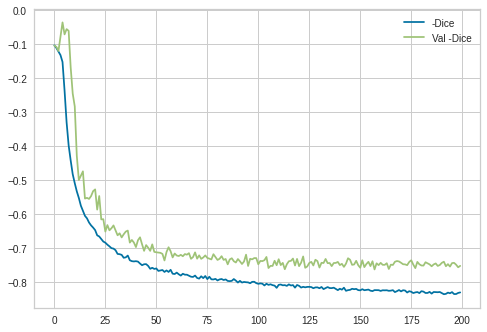

+++++++++++++++++++++++++++++++++++++
[0. 1.]
+++++++++++++++++++++++++++++++++++++


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
46/46 [==============================] - 26s 460ms/step - loss: -0.1077 - iou: 0.0569 - dice_coef: 0.1077 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.7585 - val_loss: -0.1038 - val_iou: 0.0548 - val_dice_coef: 0.1038 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9644


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 2/200
46/46 [==============================] - 20s 439ms/step - loss: -0.1181 - iou: 0.0628 - dice_coef: 0.1182 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.7614 - val_loss: -0.1044 - val_iou: 0.0551 - val_dice_coef: 0.1044 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9364


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 3/200
46/46 [==============================] - 20s 438ms/step - loss: -0.1460 - iou: 0.0789 - dice_coef: 0.1461 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.7646 - val_loss: -0.1076 - val_iou: 0.0568 - val_dice_coef: 0.1076 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9084


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 4/200
46/46 [==============================] - 20s 444ms/step - loss: -0.1825 - iou: 0.1005 - dice_coef: 0.1825 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.8143 - val_loss: -0.1092 - val_iou: 0.0578 - val_dice_coef: 0.1092 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9340


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 5/200
46/46 [==============================] - 20s 447ms/step - loss: -0.2069 - iou: 0.1150 - dice_coef: 0.2062 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.8553 - val_loss: -0.1069 - val_iou: 0.0565 - val_dice_coef: 0.1069 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9544


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 6/200
46/46 [==============================] - 20s 441ms/step - loss: -0.2267 - iou: 0.1277 - dice_coef: 0.2263 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.8833 - val_loss: -0.0956 - val_iou: 0.0502 - val_dice_coef: 0.0956 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9661


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 7/200
46/46 [==============================] - 20s 450ms/step - loss: -0.2542 - iou: 0.1458 - dice_coef: 0.2542 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9157 - val_loss: -0.0730 - val_iou: 0.0379 - val_dice_coef: 0.0730 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 8/200
46/46 [==============================] - 20s 440ms/step - loss: -0.3234 - iou: 0.1931 - dice_coef: 0.3224 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9470 - val_loss: -0.0518 - val_iou: 0.0266 - val_dice_coef: 0.0518 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9667


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 9/200
46/46 [==============================] - 20s 438ms/step - loss: -0.4253 - iou: 0.2707 - dice_coef: 0.4249 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9629 - val_loss: -0.0450 - val_iou: 0.0231 - val_dice_coef: 0.0450 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 10/200
46/46 [==============================] - 20s 442ms/step - loss: -0.4841 - iou: 0.3201 - dice_coef: 0.4840 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9680 - val_loss: -0.0657 - val_iou: 0.0341 - val_dice_coef: 0.0657 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9676


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 11/200
46/46 [==============================] - 20s 435ms/step - loss: -0.5209 - iou: 0.3522 - dice_coef: 0.5198 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9705 - val_loss: -0.1341 - val_iou: 0.0723 - val_dice_coef: 0.1341 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9690


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 12/200
46/46 [==============================] - 20s 440ms/step - loss: -0.5419 - iou: 0.3733 - dice_coef: 0.5422 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9723 - val_loss: -0.2665 - val_iou: 0.1555 - val_dice_coef: 0.2665 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9712


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 13/200
46/46 [==============================] - 20s 438ms/step - loss: -0.5714 - iou: 0.4014 - dice_coef: 0.5715 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9741 - val_loss: -0.2942 - val_iou: 0.1740 - val_dice_coef: 0.2942 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9725


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 14/200
46/46 [==============================] - 20s 438ms/step - loss: -0.5866 - iou: 0.4179 - dice_coef: 0.5868 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9751 - val_loss: -0.3262 - val_iou: 0.1976 - val_dice_coef: 0.3262 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9729


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 15/200
46/46 [==============================] - 20s 436ms/step - loss: -0.6000 - iou: 0.4297 - dice_coef: 0.5989 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9759 - val_loss: -0.3833 - val_iou: 0.2407 - val_dice_coef: 0.3833 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9743


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 16/200
46/46 [==============================] - 20s 438ms/step - loss: -0.6087 - iou: 0.4393 - dice_coef: 0.6085 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9764 - val_loss: -0.4563 - val_iou: 0.3002 - val_dice_coef: 0.4563 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9753


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 17/200
46/46 [==============================] - 20s 435ms/step - loss: -0.6302 - iou: 0.4629 - dice_coef: 0.6307 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9778 - val_loss: -0.4537 - val_iou: 0.2973 - val_dice_coef: 0.4537 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9763


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 18/200
46/46 [==============================] - 20s 437ms/step - loss: -0.6330 - iou: 0.4650 - dice_coef: 0.6325 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9781 - val_loss: -0.5253 - val_iou: 0.3632 - val_dice_coef: 0.5253 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9776


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 19/200
46/46 [==============================] - 20s 438ms/step - loss: -0.6487 - iou: 0.4832 - dice_coef: 0.6488 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9789 - val_loss: -0.5364 - val_iou: 0.3704 - val_dice_coef: 0.5364 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9783


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 20/200
46/46 [==============================] - 20s 435ms/step - loss: -0.6544 - iou: 0.4886 - dice_coef: 0.6541 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9795 - val_loss: -0.5571 - val_iou: 0.3929 - val_dice_coef: 0.5571 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9781


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 21/200
46/46 [==============================] - 20s 441ms/step - loss: -0.6594 - iou: 0.4940 - dice_coef: 0.6592 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9794 - val_loss: -0.5738 - val_iou: 0.4127 - val_dice_coef: 0.5738 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9778


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 22/200
46/46 [==============================] - 20s 438ms/step - loss: -0.6701 - iou: 0.5068 - dice_coef: 0.6694 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9801 - val_loss: -0.6094 - val_iou: 0.4470 - val_dice_coef: 0.6094 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9787


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 23/200
46/46 [==============================] - 20s 438ms/step - loss: -0.6754 - iou: 0.5117 - dice_coef: 0.6747 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9802 - val_loss: -0.5578 - val_iou: 0.3959 - val_dice_coef: 0.5578 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9780


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 24/200
46/46 [==============================] - 20s 439ms/step - loss: -0.6810 - iou: 0.5190 - dice_coef: 0.6809 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9806 - val_loss: -0.6341 - val_iou: 0.4705 - val_dice_coef: 0.6341 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 25/200
46/46 [==============================] - 20s 437ms/step - loss: -0.6913 - iou: 0.5307 - dice_coef: 0.6912 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9813 - val_loss: -0.5952 - val_iou: 0.4308 - val_dice_coef: 0.5952 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 26/200
46/46 [==============================] - 20s 437ms/step - loss: -0.6952 - iou: 0.5361 - dice_coef: 0.6957 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9814 - val_loss: -0.5903 - val_iou: 0.4276 - val_dice_coef: 0.5903 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 27/200
46/46 [==============================] - 20s 441ms/step - loss: -0.6994 - iou: 0.5416 - dice_coef: 0.6996 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9815 - val_loss: -0.6515 - val_iou: 0.4916 - val_dice_coef: 0.6515 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 28/200
46/46 [==============================] - 20s 442ms/step - loss: -0.7041 - iou: 0.5472 - dice_coef: 0.7044 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9823 - val_loss: -0.6505 - val_iou: 0.4925 - val_dice_coef: 0.6505 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 29/200
46/46 [==============================] - 20s 435ms/step - loss: -0.7100 - iou: 0.5533 - dice_coef: 0.7102 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9821 - val_loss: -0.6219 - val_iou: 0.4628 - val_dice_coef: 0.6219 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 30/200
46/46 [==============================] - 20s 441ms/step - loss: -0.7172 - iou: 0.5631 - dice_coef: 0.7175 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9826 - val_loss: -0.6505 - val_iou: 0.4947 - val_dice_coef: 0.6505 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 31/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7160 - iou: 0.5613 - dice_coef: 0.7160 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9825 - val_loss: -0.6550 - val_iou: 0.4984 - val_dice_coef: 0.6550 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 32/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7202 - iou: 0.5667 - dice_coef: 0.7195 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9828 - val_loss: -0.6518 - val_iou: 0.4985 - val_dice_coef: 0.6518 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 33/200
46/46 [==============================] - 20s 437ms/step - loss: -0.7280 - iou: 0.5759 - dice_coef: 0.7284 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9833 - val_loss: -0.6594 - val_iou: 0.5023 - val_dice_coef: 0.6594 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 34/200
46/46 [==============================] - 20s 437ms/step - loss: -0.7238 - iou: 0.5709 - dice_coef: 0.7232 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9828 - val_loss: -0.6750 - val_iou: 0.5221 - val_dice_coef: 0.6750 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 35/200
46/46 [==============================] - 20s 439ms/step - loss: -0.7337 - iou: 0.5826 - dice_coef: 0.7339 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -0.6716 - val_iou: 0.5164 - val_dice_coef: 0.6716 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 36/200
46/46 [==============================] - 20s 442ms/step - loss: -0.7304 - iou: 0.5794 - dice_coef: 0.7305 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9831 - val_loss: -0.6649 - val_iou: 0.5106 - val_dice_coef: 0.6649 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 37/200
46/46 [==============================] - 20s 436ms/step - loss: -0.7366 - iou: 0.5863 - dice_coef: 0.7367 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9836 - val_loss: -0.6942 - val_iou: 0.5419 - val_dice_coef: 0.6942 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 38/200
46/46 [==============================] - 20s 435ms/step - loss: -0.7353 - iou: 0.5858 - dice_coef: 0.7351 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -0.6735 - val_iou: 0.5177 - val_dice_coef: 0.6735 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 39/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7461 - iou: 0.5987 - dice_coef: 0.7463 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -0.6821 - val_iou: 0.5309 - val_dice_coef: 0.6821 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 40/200
46/46 [==============================] - 20s 440ms/step - loss: -0.7434 - iou: 0.5972 - dice_coef: 0.7437 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -0.6786 - val_iou: 0.5287 - val_dice_coef: 0.6786 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 41/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7500 - iou: 0.6046 - dice_coef: 0.7503 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -0.7067 - val_iou: 0.5570 - val_dice_coef: 0.7067 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 42/200
46/46 [==============================] - 20s 439ms/step - loss: -0.7473 - iou: 0.6005 - dice_coef: 0.7466 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -0.6758 - val_iou: 0.5221 - val_dice_coef: 0.6758 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 43/200
46/46 [==============================] - 20s 442ms/step - loss: -0.7514 - iou: 0.6064 - dice_coef: 0.7518 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -0.6911 - val_iou: 0.5396 - val_dice_coef: 0.6911 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 44/200
46/46 [==============================] - 20s 440ms/step - loss: -0.7541 - iou: 0.6089 - dice_coef: 0.7541 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -0.6951 - val_iou: 0.5476 - val_dice_coef: 0.6951 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 45/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7563 - iou: 0.6125 - dice_coef: 0.7552 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -0.6972 - val_iou: 0.5435 - val_dice_coef: 0.6972 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 46/200
46/46 [==============================] - 20s 435ms/step - loss: -0.7543 - iou: 0.6098 - dice_coef: 0.7543 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -0.6994 - val_iou: 0.5513 - val_dice_coef: 0.6994 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 47/200
46/46 [==============================] - 20s 441ms/step - loss: -0.7589 - iou: 0.6166 - dice_coef: 0.7590 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.6954 - val_iou: 0.5446 - val_dice_coef: 0.6954 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 48/200
46/46 [==============================] - 20s 441ms/step - loss: -0.7592 - iou: 0.6169 - dice_coef: 0.7595 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9847 - val_loss: -0.6990 - val_iou: 0.5503 - val_dice_coef: 0.6990 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 49/200
46/46 [==============================] - 20s 436ms/step - loss: -0.7607 - iou: 0.6207 - dice_coef: 0.7611 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.6973 - val_iou: 0.5481 - val_dice_coef: 0.6973 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 50/200
46/46 [==============================] - 20s 439ms/step - loss: -0.7623 - iou: 0.6208 - dice_coef: 0.7631 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.7024 - val_iou: 0.5557 - val_dice_coef: 0.7024 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 51/200
46/46 [==============================] - 20s 447ms/step - loss: -0.7629 - iou: 0.6221 - dice_coef: 0.7629 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.7043 - val_iou: 0.5599 - val_dice_coef: 0.7043 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 52/200
46/46 [==============================] - 20s 445ms/step - loss: -0.7736 - iou: 0.6278 - dice_coef: 0.7693 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.7045 - val_iou: 0.5595 - val_dice_coef: 0.7045 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 53/200
46/46 [==============================] - 20s 440ms/step - loss: -0.7666 - iou: 0.6264 - dice_coef: 0.7666 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -0.7116 - val_iou: 0.5671 - val_dice_coef: 0.7116 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 54/200
46/46 [==============================] - 20s 441ms/step - loss: -0.7736 - iou: 0.6347 - dice_coef: 0.7736 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.7100 - val_iou: 0.5675 - val_dice_coef: 0.7100 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 55/200
46/46 [==============================] - 20s 435ms/step - loss: -0.7719 - iou: 0.6339 - dice_coef: 0.7720 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.7069 - val_iou: 0.5640 - val_dice_coef: 0.7069 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 56/200
46/46 [==============================] - 20s 447ms/step - loss: -0.7689 - iou: 0.6301 - dice_coef: 0.7692 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.6996 - val_iou: 0.5577 - val_dice_coef: 0.6996 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 57/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7708 - iou: 0.6307 - dice_coef: 0.7701 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -0.7133 - val_iou: 0.5688 - val_dice_coef: 0.7133 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 58/200
46/46 [==============================] - 20s 441ms/step - loss: -0.7755 - iou: 0.6384 - dice_coef: 0.7755 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.6950 - val_iou: 0.5482 - val_dice_coef: 0.6950 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 59/200
46/46 [==============================] - 20s 441ms/step - loss: -0.7703 - iou: 0.6308 - dice_coef: 0.7696 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.7216 - val_iou: 0.5820 - val_dice_coef: 0.7216 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 60/200
46/46 [==============================] - 20s 443ms/step - loss: -0.7786 - iou: 0.6428 - dice_coef: 0.7788 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.7161 - val_iou: 0.5754 - val_dice_coef: 0.7161 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 61/200
46/46 [==============================] - 20s 439ms/step - loss: -0.7762 - iou: 0.6403 - dice_coef: 0.7766 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.7173 - val_iou: 0.5722 - val_dice_coef: 0.7173 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 62/200
46/46 [==============================] - 20s 448ms/step - loss: -0.7783 - iou: 0.6414 - dice_coef: 0.7782 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.7177 - val_iou: 0.5716 - val_dice_coef: 0.7177 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 63/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7755 - iou: 0.6373 - dice_coef: 0.7744 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.7342 - val_iou: 0.5910 - val_dice_coef: 0.7342 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 64/200
46/46 [==============================] - 20s 436ms/step - loss: -0.7807 - iou: 0.6450 - dice_coef: 0.7803 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.7144 - val_iou: 0.5729 - val_dice_coef: 0.7144 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 65/200
46/46 [==============================] - 20s 437ms/step - loss: -0.7804 - iou: 0.6442 - dice_coef: 0.7803 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.7183 - val_iou: 0.5742 - val_dice_coef: 0.7183 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 66/200
46/46 [==============================] - 20s 437ms/step - loss: -0.7859 - iou: 0.6524 - dice_coef: 0.7862 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.7148 - val_iou: 0.5746 - val_dice_coef: 0.7148 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 67/200
46/46 [==============================] - 20s 440ms/step - loss: -0.7872 - iou: 0.6537 - dice_coef: 0.7872 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.7266 - val_iou: 0.5827 - val_dice_coef: 0.7266 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 68/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7820 - iou: 0.6483 - dice_coef: 0.7821 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.7258 - val_iou: 0.5826 - val_dice_coef: 0.7258 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 69/200
46/46 [==============================] - 20s 437ms/step - loss: -0.7833 - iou: 0.6502 - dice_coef: 0.7833 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.7221 - val_iou: 0.5850 - val_dice_coef: 0.7221 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 70/200
46/46 [==============================] - 20s 441ms/step - loss: -0.7866 - iou: 0.6538 - dice_coef: 0.7867 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.7247 - val_iou: 0.5845 - val_dice_coef: 0.7247 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 71/200
46/46 [==============================] - 20s 442ms/step - loss: -0.7897 - iou: 0.6575 - dice_coef: 0.7897 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.7296 - val_iou: 0.5902 - val_dice_coef: 0.7296 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 72/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7883 - iou: 0.6560 - dice_coef: 0.7883 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.7349 - val_iou: 0.5948 - val_dice_coef: 0.7349 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 73/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7871 - iou: 0.6545 - dice_coef: 0.7874 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.7169 - val_iou: 0.5792 - val_dice_coef: 0.7169 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 74/200
46/46 [==============================] - 20s 442ms/step - loss: -0.7973 - iou: 0.6661 - dice_coef: 0.7969 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.7298 - val_iou: 0.5867 - val_dice_coef: 0.7298 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 75/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7914 - iou: 0.6611 - dice_coef: 0.7920 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.7289 - val_iou: 0.5834 - val_dice_coef: 0.7289 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 76/200
46/46 [==============================] - 20s 441ms/step - loss: -0.7895 - iou: 0.6574 - dice_coef: 0.7893 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.7220 - val_iou: 0.5783 - val_dice_coef: 0.7220 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 77/200
46/46 [==============================] - 20s 440ms/step - loss: -0.7916 - iou: 0.6583 - dice_coef: 0.7916 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.7298 - val_iou: 0.5911 - val_dice_coef: 0.7298 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 78/200
46/46 [==============================] - 20s 441ms/step - loss: -0.7997 - iou: 0.6712 - dice_coef: 0.7998 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7380 - val_iou: 0.5998 - val_dice_coef: 0.7380 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 79/200
46/46 [==============================] - 20s 439ms/step - loss: -0.7930 - iou: 0.6604 - dice_coef: 0.7933 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.7369 - val_iou: 0.5975 - val_dice_coef: 0.7369 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 80/200
46/46 [==============================] - 20s 438ms/step - loss: -0.7956 - iou: 0.6643 - dice_coef: 0.7950 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.7260 - val_iou: 0.5898 - val_dice_coef: 0.7260 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 81/200
46/46 [==============================] - 20s 439ms/step - loss: -0.7962 - iou: 0.6664 - dice_coef: 0.7962 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.7288 - val_iou: 0.5875 - val_dice_coef: 0.7288 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 82/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8011 - iou: 0.6718 - dice_coef: 0.8006 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7371 - val_iou: 0.5999 - val_dice_coef: 0.7371 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 83/200
46/46 [==============================] - 20s 440ms/step - loss: -0.7989 - iou: 0.6704 - dice_coef: 0.7993 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7207 - val_iou: 0.5802 - val_dice_coef: 0.7207 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 84/200
46/46 [==============================] - 20s 437ms/step - loss: -0.7993 - iou: 0.6725 - dice_coef: 0.7998 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7387 - val_iou: 0.5968 - val_dice_coef: 0.7387 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 85/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8003 - iou: 0.6721 - dice_coef: 0.8008 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7410 - val_iou: 0.6005 - val_dice_coef: 0.7410 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 86/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8010 - iou: 0.6726 - dice_coef: 0.8013 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7323 - val_iou: 0.5940 - val_dice_coef: 0.7323 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 87/200
46/46 [==============================] - 20s 437ms/step - loss: -0.7992 - iou: 0.6715 - dice_coef: 0.7991 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7250 - val_iou: 0.5881 - val_dice_coef: 0.7250 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 88/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8008 - iou: 0.6730 - dice_coef: 0.8006 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7282 - val_iou: 0.5904 - val_dice_coef: 0.7282 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 89/200
46/46 [==============================] - 20s 443ms/step - loss: -0.8030 - iou: 0.6760 - dice_coef: 0.8030 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7294 - val_iou: 0.5941 - val_dice_coef: 0.7294 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 90/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8004 - iou: 0.6726 - dice_coef: 0.8011 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7430 - val_iou: 0.6086 - val_dice_coef: 0.7430 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 91/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8011 - iou: 0.6759 - dice_coef: 0.8014 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7386 - val_iou: 0.5986 - val_dice_coef: 0.7386 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 92/200
46/46 [==============================] - 20s 443ms/step - loss: -0.8023 - iou: 0.6748 - dice_coef: 0.8023 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7406 - val_iou: 0.5988 - val_dice_coef: 0.7406 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 93/200
46/46 [==============================] - 20s 440ms/step - loss: -0.7986 - iou: 0.6714 - dice_coef: 0.7983 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.7408 - val_iou: 0.6059 - val_dice_coef: 0.7408 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 94/200
46/46 [==============================] - 20s 443ms/step - loss: -0.8039 - iou: 0.6792 - dice_coef: 0.8043 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.7331 - val_iou: 0.5958 - val_dice_coef: 0.7331 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 95/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8021 - iou: 0.6745 - dice_coef: 0.8023 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7374 - val_iou: 0.6011 - val_dice_coef: 0.7374 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 96/200
46/46 [==============================] - 20s 442ms/step - loss: -0.8063 - iou: 0.6805 - dice_coef: 0.8066 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7438 - val_iou: 0.6041 - val_dice_coef: 0.7438 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 97/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8030 - iou: 0.6794 - dice_coef: 0.8038 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7447 - val_iou: 0.6055 - val_dice_coef: 0.7447 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 98/200
46/46 [==============================] - 20s 442ms/step - loss: -0.8054 - iou: 0.6796 - dice_coef: 0.8054 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7248 - val_iou: 0.5876 - val_dice_coef: 0.7248 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 99/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8129 - iou: 0.6815 - dice_coef: 0.8086 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7401 - val_iou: 0.6009 - val_dice_coef: 0.7401 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 100/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8085 - iou: 0.6834 - dice_coef: 0.8090 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7493 - val_iou: 0.6126 - val_dice_coef: 0.7493 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 101/200
46/46 [==============================] - 20s 443ms/step - loss: -0.8097 - iou: 0.6854 - dice_coef: 0.8097 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7317 - val_iou: 0.5928 - val_dice_coef: 0.7317 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 102/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8063 - iou: 0.6829 - dice_coef: 0.8066 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7491 - val_iou: 0.6124 - val_dice_coef: 0.7491 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 103/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8058 - iou: 0.6832 - dice_coef: 0.8062 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.7421 - val_iou: 0.6087 - val_dice_coef: 0.7421 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 104/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8094 - iou: 0.6867 - dice_coef: 0.8100 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7373 - val_iou: 0.6040 - val_dice_coef: 0.7373 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 105/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8066 - iou: 0.6822 - dice_coef: 0.8068 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7463 - val_iou: 0.6070 - val_dice_coef: 0.7463 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 106/200
46/46 [==============================] - 20s 445ms/step - loss: -0.8091 - iou: 0.6859 - dice_coef: 0.8092 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7476 - val_iou: 0.6106 - val_dice_coef: 0.7476 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 107/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8119 - iou: 0.6883 - dice_coef: 0.8123 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7562 - val_iou: 0.6188 - val_dice_coef: 0.7562 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 108/200
46/46 [==============================] - 20s 453ms/step - loss: -0.8103 - iou: 0.6885 - dice_coef: 0.8110 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7449 - val_iou: 0.6109 - val_dice_coef: 0.7449 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 109/200
46/46 [==============================] - 20s 443ms/step - loss: -0.8116 - iou: 0.6884 - dice_coef: 0.8117 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7437 - val_iou: 0.6080 - val_dice_coef: 0.7437 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 110/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8113 - iou: 0.6866 - dice_coef: 0.8110 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7474 - val_iou: 0.6137 - val_dice_coef: 0.7474 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 111/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8125 - iou: 0.6916 - dice_coef: 0.8128 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7461 - val_iou: 0.6071 - val_dice_coef: 0.7461 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 112/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8133 - iou: 0.6896 - dice_coef: 0.8133 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7362 - val_iou: 0.5954 - val_dice_coef: 0.7362 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 113/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8138 - iou: 0.6911 - dice_coef: 0.8137 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7352 - val_iou: 0.6016 - val_dice_coef: 0.7352 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 114/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8166 - iou: 0.6936 - dice_coef: 0.8165 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7549 - val_iou: 0.6185 - val_dice_coef: 0.7549 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 115/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8135 - iou: 0.6921 - dice_coef: 0.8137 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7342 - val_iou: 0.6024 - val_dice_coef: 0.7342 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 116/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8130 - iou: 0.6896 - dice_coef: 0.8129 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7440 - val_iou: 0.6084 - val_dice_coef: 0.7440 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 117/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8131 - iou: 0.6911 - dice_coef: 0.8129 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7337 - val_iou: 0.5978 - val_dice_coef: 0.7337 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 118/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8180 - iou: 0.6976 - dice_coef: 0.8181 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7474 - val_iou: 0.6089 - val_dice_coef: 0.7474 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 119/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8122 - iou: 0.6895 - dice_coef: 0.8119 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7451 - val_iou: 0.6153 - val_dice_coef: 0.7451 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 120/200
46/46 [==============================] - 20s 442ms/step - loss: -0.8162 - iou: 0.6952 - dice_coef: 0.8163 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7401 - val_iou: 0.6065 - val_dice_coef: 0.7401 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 121/200
46/46 [==============================] - 20s 446ms/step - loss: -0.8181 - iou: 0.6989 - dice_coef: 0.8182 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7478 - val_iou: 0.6126 - val_dice_coef: 0.7478 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 122/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8167 - iou: 0.6951 - dice_coef: 0.8161 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7302 - val_iou: 0.5976 - val_dice_coef: 0.7302 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 123/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8147 - iou: 0.6926 - dice_coef: 0.8148 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7343 - val_iou: 0.5974 - val_dice_coef: 0.7343 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 124/200
46/46 [==============================] - 20s 442ms/step - loss: -0.8217 - iou: 0.7040 - dice_coef: 0.8218 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7392 - val_iou: 0.6087 - val_dice_coef: 0.7392 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 125/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8148 - iou: 0.6938 - dice_coef: 0.8147 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7429 - val_iou: 0.6082 - val_dice_coef: 0.7429 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 126/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8170 - iou: 0.6963 - dice_coef: 0.8166 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7451 - val_iou: 0.6110 - val_dice_coef: 0.7451 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 127/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8217 - iou: 0.7015 - dice_coef: 0.8213 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7486 - val_iou: 0.6143 - val_dice_coef: 0.7486 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 128/200
46/46 [==============================] - 20s 445ms/step - loss: -0.8180 - iou: 0.6993 - dice_coef: 0.8181 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7438 - val_iou: 0.6116 - val_dice_coef: 0.7438 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 129/200
46/46 [==============================] - 20s 444ms/step - loss: -0.8175 - iou: 0.6977 - dice_coef: 0.8177 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7346 - val_iou: 0.6030 - val_dice_coef: 0.7346 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 130/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8199 - iou: 0.6999 - dice_coef: 0.8198 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7552 - val_iou: 0.6201 - val_dice_coef: 0.7552 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 131/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8198 - iou: 0.7004 - dice_coef: 0.8202 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7588 - val_iou: 0.6213 - val_dice_coef: 0.7588 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 132/200
46/46 [==============================] - 20s 443ms/step - loss: -0.8223 - iou: 0.7034 - dice_coef: 0.8221 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7399 - val_iou: 0.6038 - val_dice_coef: 0.7399 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 133/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8169 - iou: 0.6973 - dice_coef: 0.8175 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7511 - val_iou: 0.6159 - val_dice_coef: 0.7511 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 134/200
46/46 [==============================] - 20s 443ms/step - loss: -0.8197 - iou: 0.7011 - dice_coef: 0.8200 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7429 - val_iou: 0.6107 - val_dice_coef: 0.7429 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 135/200
46/46 [==============================] - 20s 442ms/step - loss: -0.8192 - iou: 0.6987 - dice_coef: 0.8188 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7545 - val_iou: 0.6219 - val_dice_coef: 0.7545 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 136/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8209 - iou: 0.7025 - dice_coef: 0.8212 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7443 - val_iou: 0.6102 - val_dice_coef: 0.7443 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 137/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8201 - iou: 0.7017 - dice_coef: 0.8206 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7389 - val_iou: 0.6086 - val_dice_coef: 0.7389 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 138/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8234 - iou: 0.7060 - dice_coef: 0.8236 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7430 - val_iou: 0.6064 - val_dice_coef: 0.7430 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 139/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8215 - iou: 0.7022 - dice_coef: 0.8214 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7371 - val_iou: 0.6018 - val_dice_coef: 0.7371 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 140/200
46/46 [==============================] - 20s 442ms/step - loss: -0.8222 - iou: 0.7056 - dice_coef: 0.8225 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7464 - val_iou: 0.6178 - val_dice_coef: 0.7464 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 141/200
46/46 [==============================] - 20s 442ms/step - loss: -0.8260 - iou: 0.7085 - dice_coef: 0.8259 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7439 - val_iou: 0.6020 - val_dice_coef: 0.7439 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 142/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8243 - iou: 0.7063 - dice_coef: 0.8241 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7435 - val_iou: 0.6115 - val_dice_coef: 0.7435 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 143/200
46/46 [==============================] - 20s 443ms/step - loss: -0.8274 - iou: 0.7105 - dice_coef: 0.8275 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7432 - val_iou: 0.6094 - val_dice_coef: 0.7432 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 144/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8227 - iou: 0.7051 - dice_coef: 0.8228 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7492 - val_iou: 0.6151 - val_dice_coef: 0.7492 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 145/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8278 - iou: 0.7102 - dice_coef: 0.8278 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7457 - val_iou: 0.6150 - val_dice_coef: 0.7457 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 146/200
46/46 [==============================] - 20s 445ms/step - loss: -0.8313 - iou: 0.7076 - dice_coef: 0.8226 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7330 - val_iou: 0.5990 - val_dice_coef: 0.7330 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 147/200
46/46 [==============================] - 20s 443ms/step - loss: -0.8254 - iou: 0.7087 - dice_coef: 0.8253 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7557 - val_iou: 0.6163 - val_dice_coef: 0.7557 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 148/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8272 - iou: 0.7101 - dice_coef: 0.8267 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7381 - val_iou: 0.6017 - val_dice_coef: 0.7381 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 149/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8252 - iou: 0.7076 - dice_coef: 0.8251 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7531 - val_iou: 0.6184 - val_dice_coef: 0.7531 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 150/200
46/46 [==============================] - 20s 442ms/step - loss: -0.8259 - iou: 0.7105 - dice_coef: 0.8260 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7514 - val_iou: 0.6158 - val_dice_coef: 0.7514 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 151/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8261 - iou: 0.7071 - dice_coef: 0.8254 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7389 - val_iou: 0.6039 - val_dice_coef: 0.7389 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 152/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8316 - iou: 0.7165 - dice_coef: 0.8319 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7427 - val_iou: 0.6121 - val_dice_coef: 0.7427 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 153/200
46/46 [==============================] - 20s 445ms/step - loss: -0.8274 - iou: 0.7121 - dice_coef: 0.8278 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7542 - val_iou: 0.6185 - val_dice_coef: 0.7542 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 154/200
46/46 [==============================] - 20s 450ms/step - loss: -0.8282 - iou: 0.7129 - dice_coef: 0.8287 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7491 - val_iou: 0.6117 - val_dice_coef: 0.7491 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 155/200
46/46 [==============================] - 20s 442ms/step - loss: -0.8262 - iou: 0.7085 - dice_coef: 0.8261 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7365 - val_iou: 0.6044 - val_dice_coef: 0.7365 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 156/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8279 - iou: 0.7133 - dice_coef: 0.8280 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7437 - val_iou: 0.6109 - val_dice_coef: 0.7437 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 157/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8279 - iou: 0.7125 - dice_coef: 0.8284 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7457 - val_iou: 0.6115 - val_dice_coef: 0.7457 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 158/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8263 - iou: 0.7102 - dice_coef: 0.8264 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7466 - val_iou: 0.6152 - val_dice_coef: 0.7466 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 159/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8295 - iou: 0.7147 - dice_coef: 0.8297 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7560 - val_iou: 0.6236 - val_dice_coef: 0.7560 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 160/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8286 - iou: 0.7126 - dice_coef: 0.8285 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7398 - val_iou: 0.6065 - val_dice_coef: 0.7398 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 161/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8320 - iou: 0.7166 - dice_coef: 0.8317 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7519 - val_iou: 0.6156 - val_dice_coef: 0.7519 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 162/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8281 - iou: 0.7127 - dice_coef: 0.8279 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7415 - val_iou: 0.6086 - val_dice_coef: 0.7415 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 163/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8328 - iou: 0.7186 - dice_coef: 0.8330 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7544 - val_iou: 0.6198 - val_dice_coef: 0.7544 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 164/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8233 - iou: 0.7040 - dice_coef: 0.8227 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7423 - val_iou: 0.6091 - val_dice_coef: 0.7423 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 165/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8316 - iou: 0.7180 - dice_coef: 0.8323 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7449 - val_iou: 0.6153 - val_dice_coef: 0.7449 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 166/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8324 - iou: 0.7167 - dice_coef: 0.8323 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7408 - val_iou: 0.6074 - val_dice_coef: 0.7408 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 167/200
46/46 [==============================] - 20s 443ms/step - loss: -0.8344 - iou: 0.7219 - dice_coef: 0.8344 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7538 - val_iou: 0.6185 - val_dice_coef: 0.7538 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 168/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8316 - iou: 0.7174 - dice_coef: 0.8320 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7506 - val_iou: 0.6134 - val_dice_coef: 0.7506 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 169/200
46/46 [==============================] - 20s 442ms/step - loss: -0.8313 - iou: 0.7161 - dice_coef: 0.8309 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7374 - val_iou: 0.6054 - val_dice_coef: 0.7374 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 170/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8274 - iou: 0.7122 - dice_coef: 0.8276 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7673 - val_iou: 0.6307 - val_dice_coef: 0.7673 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9847


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 171/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8314 - iou: 0.7166 - dice_coef: 0.8314 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7574 - val_iou: 0.6232 - val_dice_coef: 0.7574 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 172/200
46/46 [==============================] - 20s 442ms/step - loss: -0.8306 - iou: 0.7173 - dice_coef: 0.8308 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7546 - val_iou: 0.6200 - val_dice_coef: 0.7546 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 173/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8335 - iou: 0.7197 - dice_coef: 0.8336 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7497 - val_iou: 0.6183 - val_dice_coef: 0.7497 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 174/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8317 - iou: 0.7184 - dice_coef: 0.8322 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7347 - val_iou: 0.6035 - val_dice_coef: 0.7347 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 175/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8375 - iou: 0.7264 - dice_coef: 0.8377 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7536 - val_iou: 0.6217 - val_dice_coef: 0.7536 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 176/200
46/46 [==============================] - 20s 445ms/step - loss: -0.8290 - iou: 0.7140 - dice_coef: 0.8288 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7492 - val_iou: 0.6200 - val_dice_coef: 0.7492 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 177/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8356 - iou: 0.7227 - dice_coef: 0.8355 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7514 - val_iou: 0.6185 - val_dice_coef: 0.7514 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 178/200
46/46 [==============================] - 20s 444ms/step - loss: -0.8299 - iou: 0.7173 - dice_coef: 0.8300 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7509 - val_iou: 0.6165 - val_dice_coef: 0.7509 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 179/200
46/46 [==============================] - 20s 443ms/step - loss: -0.8341 - iou: 0.7206 - dice_coef: 0.8344 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7587 - val_iou: 0.6194 - val_dice_coef: 0.7587 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9848


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 180/200
46/46 [==============================] - 20s 448ms/step - loss: -0.8365 - iou: 0.7247 - dice_coef: 0.8368 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -0.7560 - val_iou: 0.6182 - val_dice_coef: 0.7560 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 181/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8306 - iou: 0.7179 - dice_coef: 0.8308 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7364 - val_iou: 0.6049 - val_dice_coef: 0.7364 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 182/200
46/46 [==============================] - 20s 442ms/step - loss: -0.8325 - iou: 0.7212 - dice_coef: 0.8329 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7444 - val_iou: 0.6125 - val_dice_coef: 0.7444 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 183/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8341 - iou: 0.7215 - dice_coef: 0.8343 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7465 - val_iou: 0.6130 - val_dice_coef: 0.7465 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 184/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8367 - iou: 0.7241 - dice_coef: 0.8360 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -0.7453 - val_iou: 0.6086 - val_dice_coef: 0.7453 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 185/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8333 - iou: 0.7218 - dice_coef: 0.8336 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7434 - val_iou: 0.6094 - val_dice_coef: 0.7434 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 186/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8379 - iou: 0.7264 - dice_coef: 0.8380 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7390 - val_iou: 0.6066 - val_dice_coef: 0.7390 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 187/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8330 - iou: 0.7198 - dice_coef: 0.8326 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7421 - val_iou: 0.6078 - val_dice_coef: 0.7421 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 188/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8381 - iou: 0.7272 - dice_coef: 0.8384 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -0.7533 - val_iou: 0.6216 - val_dice_coef: 0.7533 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 189/200
46/46 [==============================] - 20s 444ms/step - loss: -0.8331 - iou: 0.7218 - dice_coef: 0.8331 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7439 - val_iou: 0.6139 - val_dice_coef: 0.7439 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 190/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8387 - iou: 0.7275 - dice_coef: 0.8391 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -0.7544 - val_iou: 0.6187 - val_dice_coef: 0.7544 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 191/200
46/46 [==============================] - 20s 439ms/step - loss: -0.8337 - iou: 0.7226 - dice_coef: 0.8340 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7448 - val_iou: 0.6125 - val_dice_coef: 0.7448 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 192/200
46/46 [==============================] - 20s 445ms/step - loss: -0.8371 - iou: 0.7259 - dice_coef: 0.8371 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7377 - val_iou: 0.6112 - val_dice_coef: 0.7377 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 193/200
46/46 [==============================] - 20s 445ms/step - loss: -0.8447 - iou: 0.7272 - dice_coef: 0.8386 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9898 - val_loss: -0.7566 - val_iou: 0.6197 - val_dice_coef: 0.7566 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 194/200
46/46 [==============================] - 20s 437ms/step - loss: -0.8371 - iou: 0.7258 - dice_coef: 0.8373 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -0.7522 - val_iou: 0.6174 - val_dice_coef: 0.7522 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 195/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8377 - iou: 0.7284 - dice_coef: 0.8381 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7502 - val_iou: 0.6167 - val_dice_coef: 0.7502 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 196/200
46/46 [==============================] - 20s 443ms/step - loss: -0.8355 - iou: 0.7246 - dice_coef: 0.8358 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7400 - val_iou: 0.6081 - val_dice_coef: 0.7400 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 197/200
46/46 [==============================] - 20s 444ms/step - loss: -0.8377 - iou: 0.7277 - dice_coef: 0.8379 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7504 - val_iou: 0.6185 - val_dice_coef: 0.7504 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 198/200
46/46 [==============================] - 20s 447ms/step - loss: -0.8381 - iou: 0.7268 - dice_coef: 0.8384 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7376 - val_iou: 0.6052 - val_dice_coef: 0.7376 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 199/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8395 - iou: 0.7301 - dice_coef: 0.8395 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -0.7550 - val_iou: 0.6259 - val_dice_coef: 0.7550 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 200/200
46/46 [==============================] - 20s 442ms/step - loss: -0.8387 - iou: 0.7295 - dice_coef: 0.8389 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7438 - val_iou: 0.6133 - val_dice_coef: 0.7438 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


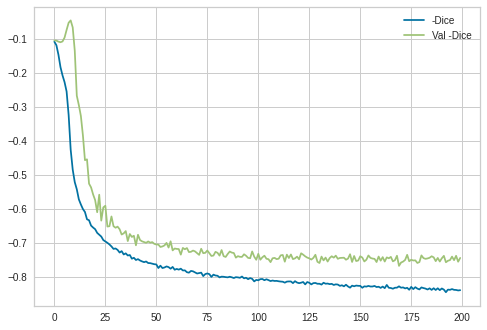

+++++++++++++++++++++++++++++++++++++
[0. 1.]
+++++++++++++++++++++++++++++++++++++


In [ ]:
from sklearn.metrics import accuracy_score,balanced_accuracy_score,f1_score,roc_auc_score,confusion_matrix,recall_score
from joblib import dump
import pandas as pd
import os

EPOCHS = 200
BATCH_SIZE = batch_size

a = 1
# phi_units = 16
metrics = [iou, dice_coef, sensitivity, specificity, 'binary_accuracy']

excel_write = pd.ExcelWriter('results.xlsx')

for phi_units in [8,16,32,64,128]:
  results_template = 'results_a-{}_phi-units-{}' # string template
  basepath = results_template.format(a,phi_units)
  try:
    os.mkdir(basepath)
  except:
    print('File exists')

  tf.keras.backend.clear_session()

  seg_model = create_model(phi_units)

  seg_model.compile(optimizer=Adam(lr=1e-4),
                    loss={'output':dice_coef_loss},
                    metrics = metrics)

  callbacks = [tf.keras.callbacks.ModelCheckpoint(basepath+'/Model_Checkpoint',
                                                  monitor='val_output_loss',
                                                  verbose=0,
                                                  mode = 'min')]

  history = seg_model.fit(train_gen,
                          steps_per_epoch=len(df_train_images) // BATCH_SIZE, 
                          epochs=EPOCHS , 
                          callbacks=callbacks,
                          validation_data = val_gen,
                          validation_steps=len(df_val_images) // BATCH_SIZE)

  # seg_model = tf.keras.Model(inputs = [seg_model.input],outputs=[seg_model.output[0]])


  plt.plot(history.history['loss'],label = '-Dice')
  plt.plot(history.history['val_loss'],label = 'Val -Dice')
  plt.legend()
  plt.savefig(basepath+'/LearningCurve.png')
  plt.show()


  seg_model.save(basepath+'/model.h5')
  ## Calculo de metricas de rendimiento. 


  filesname = df_test_images['filepath'].to_list()
  masks_files = df_test_images['mask'].to_list()
  # test_t = df_test_images['nerve_name'].to_list()
  template = 'there is nerve: {}\t Dice: {}\t AUC: {}'
  Acc = []
  Dice = []
  GM = []
  Sen = []
  Spe = []
  AUC = []
  CM = []
  there_is_nerve = []
  show = True
  for path_file,mask_file in zip(filesname,masks_files):
    image1 = cv2.resize(cv2.imread(path_file),(height,width))
    mask = cv2.resize(cv2.imread(mask_file,0),(height,width)).reshape(-1,)
    if mask.sum()==0:
      there_is_nerve.append(False)
    else:
      there_is_nerve.append(True)
      mask = mask/mask.max()
      mask[mask >= 0.5] = 1.
      mask[mask <0.5] = 0.
      if show:
        print('+++++++++++++++++++++++++++++++++++++')
        print(np.unique(mask))
        print('+++++++++++++++++++++++++++++++++++++')
        show = False
    # print(np.unique(mask))
    mask_est = np.squeeze(seg_model.predict(np.expand_dims(image1,0)/255)[0,:,:,:].astype(np.uint8)).reshape(-1,)
    CM.append(confusion_matrix(mask,mask_est,labels=[0,1]))
    Acc.append(accuracy_score(mask,mask_est))
    sen = recall_score(mask,mask_est,pos_label=1,zero_division=0)
    spe = recall_score(mask,mask_est,pos_label=0,zero_division=0)
    Sen.append(sen)
    Spe.append(spe)
    GM.append(sqrt(sen*spe))
    Dice.append(f1_score(mask,mask_est,pos_label=1,zero_division=0))
    try:
      AUC.append(roc_auc_score(mask,mask_est))
    except:
      AUC.append('null')

  mdict = {'Acc':Acc,
          'GM': GM,
          'Dice':Dice,
          'AUC':AUC,
          'Sen':Sen,
          'Spe':Spe,}

  pd.DataFrame(mdict).to_excel(excel_write,sheet_name='a-{}__phi-{}'.format(a,phi_units))

  # plt.boxplot([Acc,GM,Dice,Sen,Spe,AUC])
  # plt.xticks([1,2,3,4,5,6],['Acc','GM','Dice','Sen','Spe','AUC'])
  # plt.savefig(basepath+'/Boxplot_all')
  # plt.show()

  # for name_nerve in ['ciatico','cubital','femoral','mediano']:
  #   Acc_aux = [Acc[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  #   Sen_aux = [Sen[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  #   Spe_aux = [Spe[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  #   Dice_aux = [Dice[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  #   GM_aux = [GM[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  #   AUC_aux = [AUC[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  # plt.boxplot([Acc,GM,Dice,Sen,Spe,AUC])
  # plt.xticks([1,2,3,4,5,6],['Acc','GM','Dice','Sen','Spe','AUC'])
  # plt.title(name_nerve)
  # plt.savefig(basepath+'/Boxplot')
  # plt.show()

  savedata = {'Acc':Acc,
              'GM':GM,
              'Dice':Dice,
              'Sen':Sen,
              'Spe':Spe,
              'AUC':AUC,
              'CM':CM,
              'train':df_train_images.to_dict(),
              'test':df_test_images.to_dict(),
              'val':df_val_images.to_dict()}
  dump(savedata,basepath+'/results.joblib')

excel_write.save()


In [ ]:
!zip -r results_ResUnet results* results.xlsx

  adding: results_a-1_phi-units-128/ (stored 0%)
  adding: results_a-1_phi-units-128/results.joblib (deflated 69%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/ (stored 0%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/keras_metadata.pb (deflated 95%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/variables/ (stored 0%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/variables/variables.index (deflated 82%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/saved_model.pb (deflated 93%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/assets/ (stored 0%)
  adding: results_a-1_phi-units-128/model.h5 (deflated 19%)
  adding: results_a-1_phi-units-128/LearningCurve.png (deflated 6%)
  adding: results_a-1_phi-units-16/ (stored 0%)
  adding: results_a-1_phi-units-16/results.joblib (deflated 77%)
  adding: results_a-1_phi-units-16/Model_Checkpoint/ (stor